<a href="https://colab.research.google.com/github/Jmqcooper1/nlp1/blob/main/NLP1_2024_Practical_2_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------


# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification.

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical.
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


## Preparing the data

Let's first download the data set and take a look.

In [20]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import logging
from pathlib import Path
import torch.cuda as cuda
plt.style.use('default')

In [3]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-13 18:30:15--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-13 18:30:15--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K  3.25MB/s    in 0.2s    

2024-12-13 18:30:15 (3.25 MB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [4]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [5]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [6]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-6-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [7]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [8]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [9]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


In [10]:
def extract_subtrees(treestring):
    """Extract all valid subtrees with their sentiments from a tree string."""
    tree = Tree.fromstring(treestring)
    subtrees = []

    def tree_to_string(t):
        if isinstance(t, str):
            return t
        label = t.label()
        if len(t) == 1 and isinstance(t[0], str):
            return f"({label} {t[0]})"
        return f"({label} {' '.join(tree_to_string(c) for c in t)})"

    def extract_recursive(t):
        if not isinstance(t, str):
            if t.label() in '01234':
                subtrees.append(tree_to_string(t))
            for child in t:
                extract_recursive(child)

    extract_recursive(tree)
    return subtrees

def create_subtree_dataset(input_file, output_file):
    """Create new dataset with all valid subtrees."""
    print(f"Creating subtree dataset from {input_file}")
    subtree_count = 0
    original_count = 0

    with open(output_file, 'w', encoding='utf-8') as f_out:
        for line in filereader(input_file):
            original_count += 1
            subtrees = extract_subtrees(line)
            for subtree in subtrees:
                f_out.write(subtree + '\n')
                subtree_count += 1

            if original_count % 100 == 0:
                print(f"Processed {original_count} trees, extracted {subtree_count} subtrees")

    print(f"\nDataset creation complete:")
    print(f"Original trees: {original_count}")
    print(f"Total subtrees: {subtree_count}")
    print(f"Average subtrees per tree: {subtree_count/original_count:.1f}")

create_subtree_dataset("trees/train.txt", "trees/train_with_subtrees.txt")

Creating subtree dataset from trees/train.txt
Processed 100 trees, extracted 4186 subtrees
Processed 200 trees, extracted 7984 subtrees
Processed 300 trees, extracted 11956 subtrees
Processed 400 trees, extracted 15532 subtrees
Processed 500 trees, extracted 19382 subtrees
Processed 600 trees, extracted 23424 subtrees
Processed 700 trees, extracted 27502 subtrees
Processed 800 trees, extracted 31282 subtrees
Processed 900 trees, extracted 35168 subtrees
Processed 1000 trees, extracted 39374 subtrees
Processed 1100 trees, extracted 43326 subtrees
Processed 1200 trees, extracted 46958 subtrees
Processed 1300 trees, extracted 50950 subtrees
Processed 1400 trees, extracted 54732 subtrees
Processed 1500 trees, extracted 58396 subtrees
Processed 1600 trees, extracted 62110 subtrees
Processed 1700 trees, extracted 65750 subtrees
Processed 1800 trees, extracted 69786 subtrees
Processed 1900 trees, extracted 73554 subtrees
Processed 2000 trees, extracted 77554 subtrees
Processed 2100 trees, ext

You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [11]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)

# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
train_data_subtrees = list(examplereader("trees/train_with_subtrees.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("train with subtrees", len(train_data_subtrees))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
train with subtrees 318582
dev 1101
test 2210


Let's check out an `Example` object.

In [12]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:",  example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


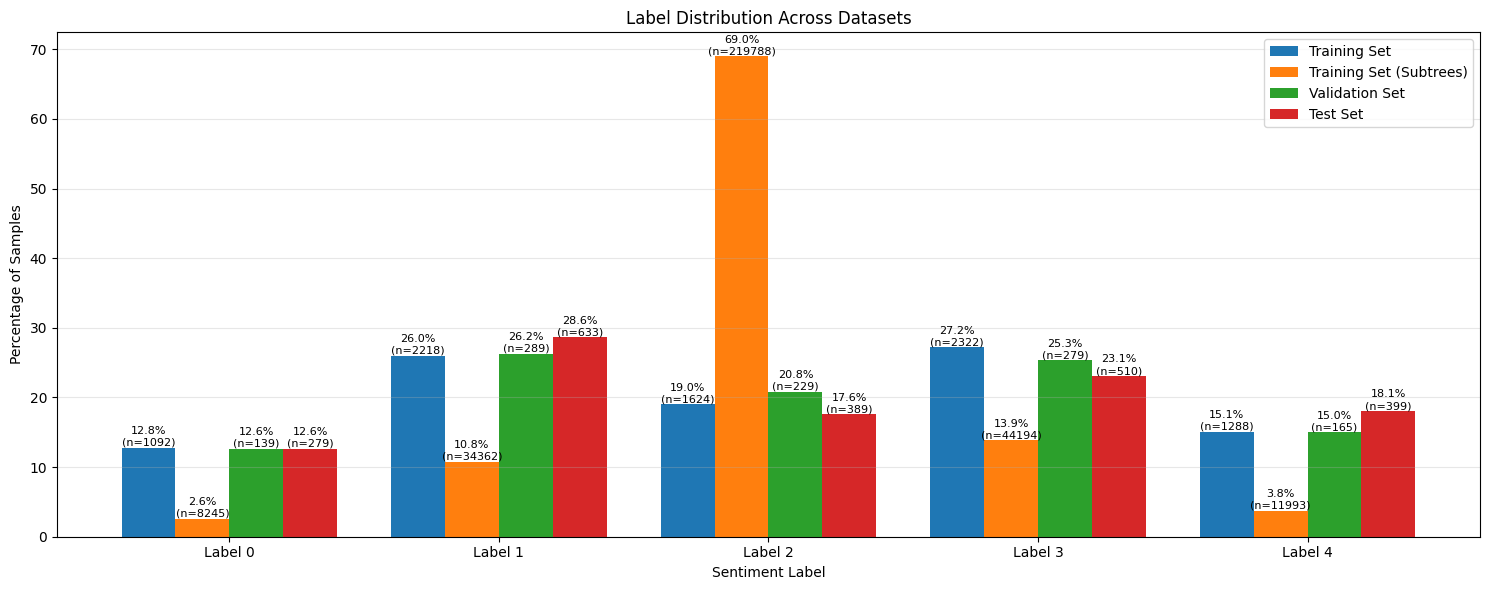


Training Set Statistics:
Label 0: 1092 samples ( 12.8%)
Label 1: 2218 samples ( 26.0%)
Label 2: 1624 samples ( 19.0%)
Label 3: 2322 samples ( 27.2%)
Label 4: 1288 samples ( 15.1%)

Training Set (Subtrees) Statistics:
Label 0: 8245 samples (  2.6%)
Label 1: 34362 samples ( 10.8%)
Label 2: 219788 samples ( 69.0%)
Label 3: 44194 samples ( 13.9%)
Label 4: 11993 samples (  3.8%)

Validation Set Statistics:
Label 0:  139 samples ( 12.6%)
Label 1:  289 samples ( 26.2%)
Label 2:  229 samples ( 20.8%)
Label 3:  279 samples ( 25.3%)
Label 4:  165 samples ( 15.0%)

Test Set Statistics:
Label 0:  279 samples ( 12.6%)
Label 1:  633 samples ( 28.6%)
Label 2:  389 samples ( 17.6%)
Label 3:  510 samples ( 23.1%)
Label 4:  399 samples ( 18.1%)


In [97]:
def plot_label_distribution(datasets, names, figsize=(15, 6)):
    """
    Plot label distribution for each dataset side by side

    Args:
        datasets: List of datasets (train, dev, test)
        names: List of dataset names
        figsize: Figure size
    """
    plt.figure(figsize=figsize)

    n_datasets = len(datasets)
    unique_labels = sorted(list(set([ex.label for data in datasets for ex in data])))
    n_labels = len(unique_labels)

    width = 0.8 / n_datasets

    for i, (data, name) in enumerate(zip(datasets, names)):
        labels = [ex.label for ex in data]
        counts = [labels.count(label) for label in unique_labels]
        percentages = [count/len(labels)*100 for count in counts]

        x = np.arange(n_labels) + (i * width) - (width * n_datasets/2) + width/2

        plt.bar(x, percentages, width, label=name)

        for j, percentage in enumerate(percentages):
            plt.text(x[j], percentage, f'{percentage:.1f}%\n(n={counts[j]})',
                    ha='center', va='bottom', fontsize=8)

    plt.title('Label Distribution Across Datasets')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Percentage of Samples')
    plt.xticks(np.arange(n_labels), [f'Label {l}' for l in unique_labels])
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_label_distribution(
    [train_data, train_data_subtrees, dev_data, test_data],
    ['Training Set', 'Training Set (Subtrees)', 'Validation Set', 'Test Set']
)

def print_distribution_stats(data, name):
    print(f"\n{name} Statistics:")
    labels = [ex.label for ex in data]
    total = len(labels)
    for label in sorted(set(labels)):
        count = labels.count(label)
        percentage = count/total*100
        print(f"Label {label}: {count:4d} samples ({percentage:5.1f}%)")

for data, name in zip([train_data, train_data_subtrees, dev_data, test_data],
    ['Training Set', 'Training Set (Subtrees)', 'Validation Set', 'Test Set']):
    print_distribution_stats(data, name)


Sentence Length Statistics:

Training Set:
Mean length: 19.14
Median length: 18.00
Std dev: 9.31
Min length: 2
Max length: 52

Validation Set:
Mean length: 19.32
Median length: 19.00
Std dev: 8.86
Min length: 2
Max length: 49

Test Set:
Mean length: 19.19
Median length: 18.00
Std dev: 8.99
Min length: 2
Max length: 56


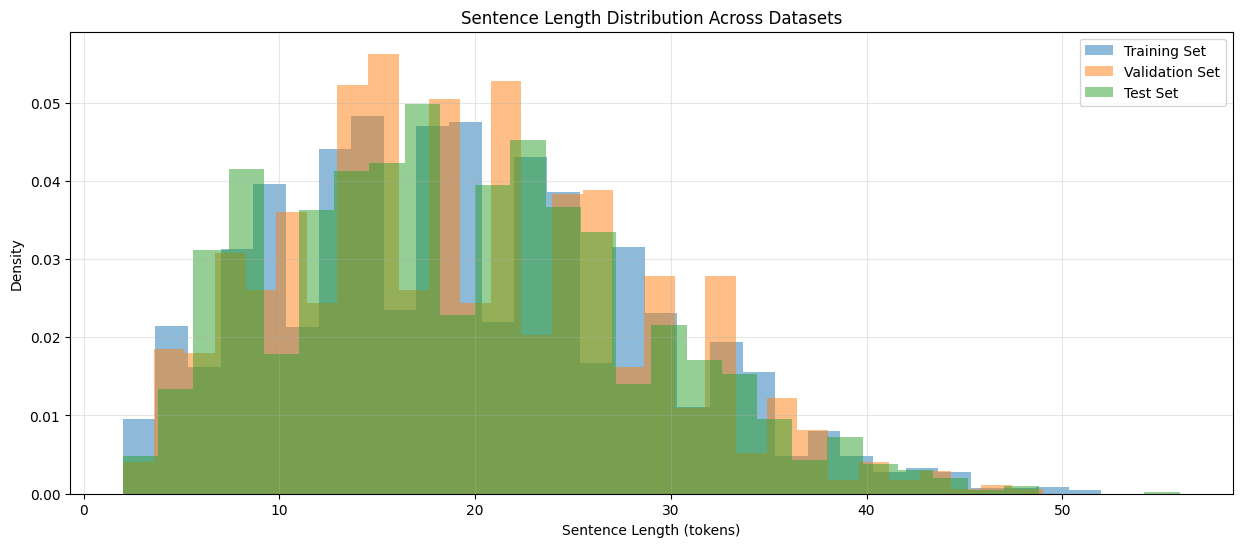

In [13]:
def analyze_sentence_lengths(datasets, names, figsize=(15, 6)):
    """
    Analyze and plot sentence length distribution for each dataset

    Args:
        datasets: List of datasets (train, dev, test)
        names: List of dataset names
        figsize: Figure size
    """
    lengths_per_dataset = []
    for data in datasets:
        lengths = [len(ex.tokens) for ex in data]
        lengths_per_dataset.append(lengths)

    plt.figure(figsize=figsize)

    for lengths, name in zip(lengths_per_dataset, names):
        plt.hist(lengths, bins=30, alpha=0.5, label=name, density=True)

    plt.title('Sentence Length Distribution Across Datasets')
    plt.xlabel('Sentence Length (tokens)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    print("\nSentence Length Statistics:")
    for lengths, name in zip(lengths_per_dataset, names):
        print(f"\n{name}:")
        print(f"Mean length: {np.mean(lengths):.2f}")
        print(f"Median length: {np.median(lengths):.2f}")
        print(f"Std dev: {np.std(lengths):.2f}")
        print(f"Min length: {min(lengths)}")
        print(f"Max length: {max(lengths)}")

    plt.show()

analyze_sentence_lengths(
    [train_data, dev_data, test_data],
    ['Training Set', 'Validation Set', 'Test Set']
)

Binning strategy -> 4 bins:

Short sentences: 2-10 tokens (roughly < mean-1std)

Medium sentences: 11-25 tokens (around mean ± std)

Long sentences: 26-40 tokens (> mean+1std)

Very long sentences: 40+ tokens (outliers)

#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [26]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [27]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [16]:
# What is the ID for "century?"
v.w2i["century"]

1973

In [17]:
# What are the first 10 words in the vocabulary (based on their IDs)?
for i in range(10):
    print(v.i2w[i])

<unk>
<pad>
.
,
the
and
a
of
to
's


In [18]:
# What are the 10 most common words?
v.freqs.most_common(10)

[('.', 8024),
 (',', 7131),
 ('the', 6037),
 ('and', 4431),
 ('a', 4403),
 ('of', 4386),
 ('to', 2995),
 ("'s", 2544),
 ('is', 2536),
 ('that', 1915)]

In [19]:
# And how many words are there with frequency 1?
# (A fancy name for these is hapax legomena.)
list(v.freqs.values()).count(1)

9543

In [20]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.
# You could use the `choice` function from the already imported `random` package
random.choices(v.i2w, k=20)

['Cliffhanger',
 'worn',
 'subtext',
 'Leroy',
 'tides',
 'woozy',
 'irreversible',
 'nonbelievers',
 'Maids',
 'highly',
 'Hollywood-action',
 'embracing',
 '2002',
 'room',
 'hysterics',
 'Yvan',
 'handsome',
 'found',
 'requisite',
 'Saddam']

#### Sentiment label vocabulary

In [30]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [31]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [21]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.1+cu121


In [22]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [23]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
# torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [32]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)

    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [33]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [34]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [35]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [36]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [37]:
from sklearn.metrics import f1_score, confusion_matrix

def process_length_bins(sent_length):
    """Determine which length bin a sentence belongs to."""
    if sent_length <= 10:
        return 'short'
    elif sent_length <= 25:
        return 'medium'
    elif sent_length <= 40:
        return 'long'
    else:
        return 'very_long'

def update_length_metrics(length_bins, length_bin, prediction, target):
    """Update metrics for length-based performance."""
    length_bins[length_bin]['preds'].append(prediction)
    length_bins[length_bin]['targets'].append(target)
    length_bins[length_bin]['correct'] += int(prediction == target)
    length_bins[length_bin]['total'] += 1

def process_tree_output(tree_info, tree_level_metrics, predictions, targets):
    """Process tree-level predictions and update metrics."""
    for b_idx, logits in enumerate(tree_info['logits']):
        level_preds = logits.argmax(dim=-1).squeeze(-1)
        levels = tree_info['levels'][b_idx]
        target = targets[b_idx]

        predictions_to_extend = []

        for level in levels:
            if level not in tree_level_metrics['errors']:
                tree_level_metrics['errors'][level] = {'correct': 0, 'total': 0}

        for i, level in enumerate(levels):
            pred_idx = i % len(level_preds)
            pred = level_preds[pred_idx].cpu().item()

            predictions_to_extend.append(pred)

            tree_level_metrics['errors'][level]['total'] += 1
            if pred == target.item():
                tree_level_metrics['errors'][level]['correct'] += 1

        tree_level_metrics['predictions'].extend(predictions_to_extend)
        tree_level_metrics['targets'].extend([target.item()] * len(predictions_to_extend))
        tree_level_metrics['levels'].extend(levels)

def calculate_performance_metrics(all_predictions, all_targets, length_bins, tree_level_metrics):
    """Calculate all performance metrics."""
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    length_performance = {}
    for bin_name, bin_data in length_bins.items():
        if bin_data['total'] > 0:
            bin_preds = np.array(bin_data['preds'])
            bin_targets = np.array(bin_data['targets'])
            length_performance[bin_name] = {
                'accuracy': bin_data['correct'] / bin_data['total'],
                'weighted_f1': f1_score(bin_targets, bin_preds, average='weighted') if len(bin_preds) > 0 else 0,
                'count': bin_data['total']
            }

    tree_metrics = {}
    if tree_level_metrics['predictions']:
        tree_preds = np.array(tree_level_metrics['predictions'])
        tree_targets = np.array(tree_level_metrics['targets'])
        tree_levels = np.array(tree_level_metrics['levels'])

        for level in sorted(set(tree_levels)):
            level_mask = tree_levels == level
            level_preds = tree_preds[level_mask]
            level_targets = tree_targets[level_mask]

            tree_metrics[f'level_{level}'] = {
                'accuracy': tree_level_metrics['errors'][level]['correct'] / tree_level_metrics['errors'][level]['total'],
                'weighted_f1': f1_score(level_targets, level_preds, average='weighted'),
                'confusion_matrix': confusion_matrix(level_targets, level_preds).tolist(),
                'count': tree_level_metrics['errors'][level]['total']
            }

    metrics = {
        'accuracy': len([1 for p, t in zip(all_predictions, all_targets) if p == t]) / len(all_predictions),
        'weighted_f1': f1_score(all_targets, all_predictions, average='weighted'),
        'macro_f1': f1_score(all_targets, all_predictions, average='macro'),
        'per_class_f1': f1_score(all_targets, all_predictions, average=None).tolist(),
        'confusion_matrix': confusion_matrix(all_targets, all_predictions).tolist(),
        'length_performance': length_performance,
        'tree_metrics': tree_metrics if tree_metrics else None
    }

    return metrics

In [38]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
    """Evaluate model with multiple metrics including length-based and tree-level performance."""
    correct = 0
    total = 0
    total_loss = 0

    length_bins = {
        'short': {'preds': [], 'targets': [], 'correct': 0, 'total': 0},
        'medium': {'preds': [], 'targets': [], 'correct': 0, 'total': 0},
        'long': {'preds': [], 'targets': [], 'correct': 0, 'total': 0},
        'very_long': {'preds': [], 'targets': [], 'correct': 0, 'total': 0},
    }

    tree_level_metrics = {
        'predictions': [],
        'targets': [],
        'levels': [],
        'errors': {}
    }

    all_predictions = []
    all_targets = []
    model.eval()

    batch_fn = kwargs.get('batch_fn')
    batch_prep_fn = kwargs.get('prep_fn', prep_fn)

    is_batch_processing = (batch_fn is not None and
                         batch_prep_fn is not None and
                         getattr(batch_fn, '__name__', '') == 'get_minibatch' and
                         (getattr(batch_prep_fn, '__name__', '') == 'prepare_minibatch' or
                          getattr(batch_prep_fn, '__name__', '') == 'prepare_treelstm_minibatch'))


    if is_batch_processing:
        batch_size = kwargs.get('eval_batch_size', kwargs.get('batch_size', 1))
        for batch in batch_fn(data, batch_size=batch_size, shuffle=False):
            x, targets = prep_fn(batch, model.vocab)

            with torch.no_grad():
                output = model(x)
                if isinstance(output, dict):
                    logits = output['final_logits']
                    tree_info = output.get('tree_info')
                    if tree_info:
                        process_tree_output(tree_info, tree_level_metrics, logits, targets)
                else:
                    logits = output

            predictions = logits.argmax(dim=-1)

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

            for i, example in enumerate(batch):
                sent_length = len(example.tokens)
                length_bin = process_length_bins(sent_length)

                pred = predictions[i].item()
                targ = targets[i].item()

                update_length_metrics(length_bins, length_bin, pred, targ)

                all_predictions.append(pred)
                all_targets.append(targ)

    else:
        for example in data:
            sent_length = len(example.tokens)
            length_bin = process_length_bins(sent_length)

            x, target = prep_fn(example, model.vocab)

            with torch.no_grad():
                output = model(x)
                if isinstance(output, dict):
                    logits = output['final_logits']
                    tree_info = output.get('tree_info')
                    if tree_info:
                        process_tree_output(tree_info, tree_level_metrics, logits, target)
                else:
                    logits = output

            prediction = logits.argmax(dim=-1)

            correct += (prediction == target).sum().item()
            total += 1

            pred_item = prediction.item()
            targ_item = target.item()
            update_length_metrics(length_bins, length_bin, pred_item, targ_item)

            all_predictions.append(pred_item)
            all_targets.append(targ_item)

    metrics = calculate_performance_metrics(all_predictions, all_targets, length_bins, tree_level_metrics)

    return total_loss, metrics

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [39]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [40]:
from torch import optim

Besides implementations of stochastic gradient descent (SGD), this package also implements the optimisation algorithm Adam, which we'll be using in this practical.
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling:

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimisation algorithms using gradient information, [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [41]:
def validate(model, data, eval_fn, batch_fn, prep_fn, eval_batch_size):
    """Helper function to evaluate the model."""
    model.eval()
    with torch.no_grad():
        kwargs = {
            'eval_batch_size': eval_batch_size,
            'batch_size': eval_batch_size,
            'batch_fn': batch_fn,
            'prep_fn': prep_fn
        }
        total_loss, metrics = eval_fn(model, data, **kwargs)
    return total_loss, metrics

def save_checkpoint(model, optimizer, path, best_eval, best_iter, iter_i, extra_data=None):
    """Helper function to save model checkpoint."""
    ckpt = {
        "state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_eval": best_eval,
        "best_iter": best_iter,
        "current_iter": iter_i
    }
    if extra_data:
        ckpt.update(extra_data)
    torch.save(ckpt, path)

In [42]:
def train_model(model, optimizer, train_data,
                num_iterations=10000,
                print_every=500,
                eval_every=500,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=32,
                eval_batch_size=128,
                patience=5,
                scheduler=None,
                max_norm=1.0,
                warmup_steps=100,
                accumulation_steps=4,
                checkpoint_every=1000):
    """Train a model with optimized training process.

    Args:
        model: The neural network model
        optimizer: The optimizer (e.g., Adam)
        num_iterations: Maximum number of training iterations
        print_every: Steps between printing progress
        eval_every: Steps between evaluations
        batch_fn: Function to get batches of data
        prep_fn: Function to prepare examples
        eval_fn: Function to evaluate model
        batch_size: Training batch size
        eval_batch_size: Evaluation batch size
        patience: Early stopping patience
        scheduler: Learning rate scheduler
        max_norm: Maximum gradient norm
        warmup_steps: Number of warmup steps
        accumulation_steps: Number of steps for gradient accumulation
        checkpoint_every: Steps between checkpoints
    """
    try:
        iter_i = 0
        train_loss = 0.
        print_num = 0
        start = time.time()
        criterion = nn.CrossEntropyLoss()
        best_eval = 0.
        best_iter = 0
        no_improvement = 0

        losses = []
        accuracies = []
        val_losses = []
        lrs = []

        checkpoint_dir = Path("checkpoints")
        checkpoint_dir.mkdir(exist_ok=True)

        if eval_batch_size is None:
            eval_batch_size = batch_size

        initial_lr = optimizer.param_groups[0]['lr']

        while True:
            pbar = tqdm(batch_fn(train_data, batch_size=batch_size),
                        desc=f'Iteration {iter_i}')

            for batch_idx, batch in enumerate(pbar):
                model.train()
                x, targets = prep_fn(batch, model.vocab)

                if isinstance(x, tuple):
                    words, transitions = x
                    words = words.to(next(model.parameters()).device)
                    x = (words, transitions)
                else:
                    x = x.to(next(model.parameters()).device)
                targets = targets.to(next(model.parameters()).device)

                output = model(x)

                if isinstance(output, dict):
                    logits = output['final_logits']
                else:
                    logits = output

                loss = criterion(logits.view([targets.size(0), -1]), targets.view(-1))
                loss = loss / accumulation_steps
                train_loss += loss.item() * accumulation_steps

                loss.backward()

                if (batch_idx + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

                    if iter_i < warmup_steps:
                        lr_scale = min(1., float(iter_i + 1) / warmup_steps)
                        for pg in optimizer.param_groups:
                            pg['lr'] = lr_scale * initial_lr

                    optimizer.step()
                    optimizer.zero_grad()

                    lrs.append(optimizer.param_groups[0]['lr'])

                print_num += 1
                iter_i += 1

                pbar.set_description(
                    f'Iter {iter_i}: loss={loss.item():.4f}, '
                    f'lr={optimizer.param_groups[0]["lr"]:.6f}'
                )

                if iter_i % print_every == 0:
                    avg_loss = train_loss / print_num
                    print(f"\nIter {iter_i}: loss={avg_loss:.4f}, "
                          f"time={time.time()-start:.2f}s")
                    losses.append(avg_loss)
                    print_num = 0
                    train_loss = 0.

                if iter_i % eval_every == 0:
                    val_loss, metrics = validate(
                        model, dev_data, eval_fn, batch_fn, prep_fn, eval_batch_size
                    )

                    accuracies.append(metrics['accuracy'])
                    val_losses.append(val_loss)
                    print(f"iter {iter_i}: dev acc={metrics['accuracy']:.4f}, "
                        f"val_loss={val_loss:.4f}, "
                        f"weighted_f1={metrics['weighted_f1']:.4f}")

                    if metrics['weighted_f1'] > best_eval:
                        print("new highscore")
                        best_eval = metrics['weighted_f1']
                        best_iter = iter_i
                        no_improvement = 0

                        save_checkpoint(
                            model, optimizer,
                            f"{checkpoint_dir}/{model.__class__.__name__}_best.pt",
                            best_eval, best_iter, iter_i
                        )
                    else:
                        no_improvement += 1

                    if scheduler is not None:
                        scheduler.step(metrics['weighted_f1'])

                    if no_improvement >= patience:
                        print(f"Early stopping triggered after {iter_i} iterations")
                        break

                if iter_i % checkpoint_every == 0:
                    save_checkpoint(
                        model, optimizer,
                        f"{checkpoint_dir}/{model.__class__.__name__}_{iter_i}.pt",
                        best_eval, best_iter, iter_i
                    )

                if iter_i % 1000 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

                if iter_i >= num_iterations:
                    print("Reached maximum iterations")
                    break

            if no_improvement >= patience or iter_i >= num_iterations:
                break

        print("\nTraining finished! Loading best model...")
        best_model_path = f"{checkpoint_dir}/{model.__class__.__name__}_best.pt"
        ckpt = torch.load(best_model_path)
        model.load_state_dict(ckpt["state_dict"])

        model.eval()
        with torch.no_grad():
            train_loss, train_metrics = eval_fn(
                model, train_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
            dev_loss, dev_metrics = eval_fn(
                model, dev_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
            test_loss, test_metrics = eval_fn(
                model, test_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)

        print(f"Best model (iter {best_iter}):")
        print(f"Train: acc={train_metrics['accuracy']:.4f}, w_f1={train_metrics['weighted_f1']:.4f}")
        print(f"Dev:   acc={dev_metrics['accuracy']:.4f}, w_f1={dev_metrics['weighted_f1']:.4f}")
        print(f"Test:  acc={test_metrics['accuracy']:.4f}, w_f1={test_metrics['weighted_f1']:.4f}")

        return {
            'losses': losses,
            'accuracies': accuracies,
            'val_losses': val_losses,
            'learning_rates': lrs,
            'best_weighted_f1': best_eval,
            'best_iteration': best_iter,
            'final_metrics': {
                'train': train_metrics,
                'dev': dev_metrics,
                'test': test_metrics,
                'train_loss': train_loss,
                'dev_loss': dev_loss,
                'test_loss': test_loss
            }
        }

    except Exception as e:
        print(f"Error during training: {str(e)}")
        save_checkpoint(
            model, optimizer,
            f"{checkpoint_dir}/{model.__class__.__name__}_emergency.pt",
            best_eval, best_iter, iter_i,
            {'error': str(e)}
        )
        raise e

### Training the BOW model

In [43]:
def train_with_multiple_seeds(model_class, model_args, seeds=[42, 123, 456],
                            pretrained_vectors=None, freeze_embeddings=True, use_subtrees=False,
                            **train_kwargs):
    """
    Train a model multiple times with different seeds.
    Handles both regular and pre-trained models.

    Args:
        model_class: The class of the model
        model_args: Dictionary of arguments for model initialization
        seeds: List of random seeds to use
        pretrained_vectors: Optional pre-trained word vectors
        freeze_embeddings: Whether to freeze embeddings (if pre-trained)
        **train_kwargs: Arguments for train_model function
    """
    all_stats = []

    print(f"Training with seeds: {seeds}")
    if pretrained_vectors is not None:
        print(f"Using pre-trained embeddings ({'frozen' if freeze_embeddings else 'trainable'})")

    training_data = train_data_subtrees if use_subtrees else train_data
    print(f"Training with {'subtree-enhanced' if use_subtrees else 'original'} dataset "
          f"({len(training_data)} examples)")

    for seed in seeds:
        print(f"\nTraining with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        model = model_class(**model_args)

        if pretrained_vectors is not None:
            with torch.no_grad():
                model.embed.weight.data.copy_(torch.from_numpy(pretrained_vectors))
                model.embed.weight.requires_grad = not freeze_embeddings

        model = model.to(device)

        optimizer = optim.AdamW(
            model.parameters(),
            lr=2e-4,
            weight_decay=0.01
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        stats = train_model(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            train_data=training_data,
            **train_kwargs
        )
        all_stats.append(stats)

    test_accuracies = [s['final_metrics']['test']['accuracy'] for s in all_stats]
    test_f1_scores = [s['final_metrics']['test']['weighted_f1'] for s in all_stats]

    mean_test_acc = np.mean(test_accuracies)
    std_test_acc = np.std(test_accuracies)
    mean_test_f1 = np.mean(test_f1_scores)
    std_test_f1 = np.std(test_f1_scores)

    combined_stats = all_stats[0].copy()
    combined_stats.update({
        'mean_test_acc': mean_test_acc,
        'std_test_acc': std_test_acc,
        'mean_test_f1': mean_test_f1,
        'std_test_f1': std_test_f1,
        'individual_runs': {
            f'seed_{seed}': stats for seed, stats in zip(seeds, all_stats)
        }
    })

    print(f"\nFinal Results across {len(seeds)} seeds:")
    print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")
    print(f"Test Weighted F1: {mean_test_f1:.4f} ± {std_test_f1:.4f}")

    return combined_stats

In [44]:
def plot_research_results(training_stats_list, model_names, figsize=(20, 10)):
    """Plot comprehensive results for all research questions."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))

    # 1. Training Loss Only
    plt.figure(figsize=figsize)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        plt.plot(stats['losses'], color=colors[i], label=name)
    plt.title('Training Loss Across Models')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Accuracy Comparison with std dev
    plt.figure(figsize=figsize)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        runs = list(stats['individual_runs'].values())
        min_len = min(len(run['accuracies']) for run in runs)
        all_accs = np.array([run['accuracies'][:min_len] for run in runs])
        mean_acc = np.mean(all_accs, axis=0)
        std_acc = np.std(all_accs, axis=0)
        plt.plot(mean_acc, color=colors[i], label=name)
        plt.fill_between(range(len(mean_acc)), mean_acc-std_acc, mean_acc+std_acc,
                        color=colors[i], alpha=0.2)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Weighted F1 Comparison
    plt.figure(figsize=figsize)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        f1_scores = [run['final_metrics']['test']['weighted_f1']
                    for run in stats['individual_runs'].values()]
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        plt.bar(i, mean_f1, yerr=std_f1, color=colors[i], label=name)
    plt.title('Weighted F1-Score Comparison')
    plt.ylabel('Weighted F1-Score')
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Research Q: Sentence Length Impact
    plt.figure(figsize=figsize)
    bins = ['short', 'medium', 'long', 'very_long']
    x = np.arange(len(bins))
    width = 0.8 / len(model_names)

    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        length_metrics = []
        for bin in bins:
            if bin in stats['final_metrics']['test']['length_performance']:
                length_metrics.append(stats['final_metrics']['test']['length_performance'][bin]['weighted_f1'])
            else:
                length_metrics.append(0)
        plt.bar(x + i*width, length_metrics, width, label=name, color=colors[i])

    plt.title('Performance Across Sentence Lengths')
    plt.xlabel('Sentence Length')
    plt.ylabel('Weighted F1-Score')
    plt.xticks(x + width*len(model_names)/2, bins)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Research Q: Node Supervision Impact
    plt.figure(figsize=figsize)
    base_models = {}
    for i, name in enumerate(model_names):
        base_name = name.replace('_subtrees', '').replace('_original', '')
        if base_name not in base_models:
            base_models[base_name] = []
        base_models[base_name].append((name, training_stats_list[i]))

    x = np.arange(len(base_models))
    width = 0.35

    for i, (base_name, versions) in enumerate(base_models.items()):
        for j, (name, stats) in enumerate(versions):
            f1_scores = [run['final_metrics']['test']['weighted_f1']
                        for run in stats['individual_runs'].values()]
            mean_f1 = np.mean(f1_scores)
            std_f1 = np.std(f1_scores)
            offset = -width/2 if 'original' in name.lower() else width/2
            plt.bar(i + offset, mean_f1, width,
                   yerr=std_f1,
                   label=f'{"Original" if "original" in name.lower() else "Subtree"}',
                   color=colors[i*2 + j])

    plt.title('Impact of Node-Level Supervision')
    plt.xlabel('Model Type')
    plt.ylabel('Weighted F1-Score')
    plt.xticks(x, base_models.keys())
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # 6. Research Q: Tree Error Analysis (TreeLSTM specific)
    treelstm_models = [(stats, name) for stats, name in zip(training_stats_list, model_names)
                       if 'treelstm' in name.lower()]

    if treelstm_models:
        plt.figure(figsize=figsize)
        for i, (stats, name) in enumerate(treelstm_models):
            tree_metrics = stats['final_metrics']['test']['tree_metrics']
            levels = sorted(int(level.split('_')[1]) for level in tree_metrics.keys())
            error_rates = [1 - tree_metrics[f'level_{level}']['accuracy'] for level in levels]
            plt.plot(levels, error_rates, 'o-', color=colors[i], label=name)

        plt.title('TreeLSTM Error Rates by Tree Level')
        plt.xlabel('Tree Level')
        plt.ylabel('Error Rate')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [45]:
results = {}

# Common training arguments (no batch settings)
base_train_kwargs = {
    'num_iterations': 30000,
    'print_every': 500,
    'eval_every': 500,
    'patience': 5,
    'max_norm': 1.0,
    'warmup_steps': 100,
    'accumulation_steps': 4,
    'checkpoint_every': 1000,
    'eval_fn': simple_evaluate
}

# Model-specific settings
bow_kwargs = {
    'batch_size': 32,
    'eval_batch_size': 128
}

cbow_kwargs = {
    'batch_size': 32,
    'eval_batch_size': 128
}

deepcbow_kwargs = {
    'batch_size': 32,
    'eval_batch_size': 128
}

pt_deepcbow_kwargs = {
    'batch_size': 32,
    'eval_batch_size': 128
}

lstm_no_batch_kwargs = {
    'batch_size': 1,
    'eval_batch_size': 1,
    'batch_fn': get_examples,
    'prep_fn': prepare_example,
    'freeze_embeddings': True
}


In [41]:
# If everything is in place we can now train our first model!
bow_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 5,
    'vocab': v
}

results['bow_original'] = train_with_multiple_seeds(
    model_class=BOW,
    model_args=bow_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **bow_kwargs
)

results['bow_subtrees'] = train_with_multiple_seeds(
    model_class=BOW,
    model_args=bow_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **bow_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.1859, lr=0.000200: : 494it [00:02, 386.73it/s]


Iter 500: loss=5.3366, time=2.33s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 576: loss=0.0000, lr=0.000200: : 574it [00:02, 218.91it/s]

iter 500: dev acc=0.1916, val_loss=0.0000, weighted_f1=0.1712
new highscore


Iter 1000: loss=0.9604, lr=0.000200: : 980it [00:03, 384.68it/s]


Iter 1000: loss=5.9400, time=3.97s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1075: loss=2.7748, lr=0.000200: : 1058it [00:04, 228.04it/s]

iter 1000: dev acc=0.1907, val_loss=0.0000, weighted_f1=0.1720
new highscore


Iter 1500: loss=2.0584, lr=0.000200: : 1492it [00:05, 395.43it/s]


Iter 1500: loss=5.3728, time=5.59s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1582: loss=0.7187, lr=0.000200: : 1575it [00:06, 248.55it/s]

iter 1500: dev acc=0.1926, val_loss=0.0000, weighted_f1=0.1747
new highscore


Iter 2000: loss=1.4435, lr=0.000200: : 1984it [00:07, 391.17it/s]


Iter 2000: loss=5.2222, time=7.14s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2081: loss=2.6170, lr=0.000200: : 2066it [00:07, 231.88it/s]

iter 2000: dev acc=0.1926, val_loss=0.0000, weighted_f1=0.1755
new highscore


Iter 2500: loss=1.3199, lr=0.000200: : 2482it [00:08, 409.29it/s]


Iter 2500: loss=4.9985, time=8.71s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2587: loss=1.6930, lr=0.000200: : 2568it [00:09, 245.00it/s]

iter 2500: dev acc=0.1907, val_loss=0.0000, weighted_f1=0.1744


Iter 3000: loss=0.5089, lr=0.000200: : 2972it [00:10, 386.35it/s]


Iter 3000: loss=5.4326, time=10.30s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3082: loss=0.5064, lr=0.000200: : 3056it [00:10, 248.28it/s]

iter 3000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1745


Iter 3500: loss=1.8388, lr=0.000200: : 3475it [00:11, 409.66it/s]


Iter 3500: loss=5.0793, time=11.81s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3580: loss=2.1812, lr=0.000100: : 3557it [00:12, 233.90it/s]

iter 3500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1748


Iter 4000: loss=1.2118, lr=0.000100: : 3975it [00:13, 405.38it/s]


Iter 4000: loss=5.0324, time=13.39s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4079: loss=1.3179, lr=0.000100: : 4057it [00:13, 240.04it/s]

iter 4000: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1747


Iter 4500: loss=0.8632, lr=0.000100: : 4477it [00:14, 405.94it/s]


Iter 4500: loss=5.1396, time=14.93s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4500: loss=0.8632, lr=0.000100: : 4499it [00:15, 295.33it/s]

iter 4500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1753
Early stopping triggered after 4500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 2000):
Train: acc=0.2068, w_f1=0.1994
Dev:   acc=0.1926, w_f1=0.1755
Test:  acc=0.2027, w_f1=0.1803

Training with seed 123


Iter 82: loss=2.2740, lr=0.000160: : 41it [00:00, 406.24it/s]

Shuffling training data


Iter 500: loss=4.6042, lr=0.000200: : 480it [00:01, 416.53it/s]


Iter 500: loss=5.4440, time=1.19s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 579: loss=0.5361, lr=0.000200: : 563it [00:01, 232.84it/s]

iter 500: dev acc=0.1780, val_loss=0.0000, weighted_f1=0.1623
new highscore


Iter 1000: loss=2.8833, lr=0.000200: : 987it [00:02, 400.13it/s]


Iter 1000: loss=5.2880, time=2.77s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1081: loss=0.9450, lr=0.000200: : 1071it [00:03, 250.72it/s]

iter 1000: dev acc=0.1835, val_loss=0.0000, weighted_f1=0.1689
new highscore


Iter 1500: loss=2.5628, lr=0.000200: : 1485it [00:04, 403.89it/s]


Iter 1500: loss=5.2866, time=4.30s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1581: loss=0.6086, lr=0.000200: : 1567it [00:04, 243.44it/s]

iter 1500: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1675


Iter 2000: loss=1.3152, lr=0.000200: : 1989it [00:05, 400.93it/s]


Iter 2000: loss=5.5802, time=5.84s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2079: loss=3.7876, lr=0.000200: : 2072it [00:06, 250.08it/s]

iter 2000: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1747
new highscore


Iter 2500: loss=2.7341, lr=0.000200: : 2482it [00:07, 398.44it/s]


Iter 2500: loss=4.9431, time=7.38s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2584: loss=0.2309, lr=0.000200: : 2566it [00:07, 244.98it/s]

iter 2500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1759
new highscore


Iter 3000: loss=0.0212, lr=0.000200: : 2963it [00:09, 355.97it/s]


Iter 3000: loss=5.1916, time=9.01s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3074: loss=4.7314, lr=0.000200: : 3039it [00:09, 219.51it/s]

iter 3000: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1770
new highscore


Iter 3500: loss=4.6856, lr=0.000200: : 3492it [00:10, 380.78it/s]


Iter 3500: loss=5.3068, time=10.69s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3583: loss=1.1292, lr=0.000200: : 3573it [00:11, 243.24it/s]

iter 3500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1768


Iter 4000: loss=1.7703, lr=0.000200: : 3987it [00:12, 393.51it/s]


Iter 4000: loss=5.1589, time=12.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4078: loss=3.4934, lr=0.000200: : 4068it [00:12, 243.30it/s]

iter 4000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1784
new highscore


Iter 4500: loss=0.8051, lr=0.000200: : 4472it [00:13, 397.22it/s]


Iter 4500: loss=5.2665, time=13.78s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4582: loss=0.0769, lr=0.000200: : 4556it [00:14, 247.91it/s]

iter 4500: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1802
new highscore


Iter 5000: loss=3.7591, lr=0.000200: : 4996it [00:15, 392.52it/s]


Iter 5000: loss=5.4487, time=15.35s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5079: loss=2.3878, lr=0.000200: : 5077it [00:15, 231.32it/s]

iter 5000: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1796


Iter 5500: loss=0.4123, lr=0.000200: : 5478it [00:16, 385.38it/s]


Iter 5500: loss=5.1920, time=16.96s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5579: loss=1.7485, lr=0.000200: : 5558it [00:17, 236.56it/s]

iter 5500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1803
new highscore


Iter 6000: loss=1.3876, lr=0.000200: : 5968it [00:18, 395.42it/s]


Iter 6000: loss=5.1759, time=18.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6079: loss=2.1820, lr=0.000200: : 6050it [00:19, 244.52it/s]

iter 6000: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1785


Iter 6500: loss=2.8813, lr=0.000200: : 6497it [00:20, 399.48it/s]


Iter 6500: loss=5.0331, time=20.09s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6581: loss=0.6324, lr=0.000200: : 6578it [00:20, 247.33it/s]

iter 6500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1803


Iter 7000: loss=0.2058, lr=0.000200: : 6972it [00:21, 384.62it/s]


Iter 7000: loss=5.1202, time=21.67s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7076: loss=0.0584, lr=0.000200: : 7053it [00:22, 239.33it/s]

iter 7000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1829
new highscore


Iter 7500: loss=1.9671, lr=0.000200: : 7465it [00:23, 392.04it/s]


Iter 7500: loss=4.9089, time=23.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7582: loss=0.1515, lr=0.000200: : 7547it [00:23, 233.11it/s]

iter 7500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1825


Iter 8000: loss=2.9119, lr=0.000200: : 7997it [00:24, 400.82it/s]


Iter 8000: loss=5.0838, time=24.82s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8081: loss=1.5078, lr=0.000200: : 8080it [00:25, 250.25it/s]

iter 8000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1839
new highscore


Iter 8500: loss=3.9343, lr=0.000200: : 8495it [00:26, 396.32it/s]


Iter 8500: loss=4.6684, time=26.35s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8544: loss=0.6088, lr=0.000200: : 8544it [00:26, 319.41it/s]


iter 8500: dev acc=0.1907, val_loss=0.0000, weighted_f1=0.1852
new highscore


Iter 8582: loss=0.8484, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=1.1530, lr=0.000200: : 417it [00:01, 400.94it/s]


Iter 9000: loss=4.7187, time=27.89s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9083: loss=0.1214, lr=0.000200: : 500it [00:01, 239.56it/s]

iter 9000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1846


Iter 9500: loss=0.1364, lr=0.000200: : 921it [00:02, 401.40it/s]


Iter 9500: loss=4.8011, time=29.43s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9583: loss=2.8243, lr=0.000200: : 1005it [00:03, 249.39it/s]

iter 9500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1835


Iter 10000: loss=1.8107, lr=0.000200: : 1417it [00:04, 393.23it/s]


Iter 10000: loss=5.1706, time=30.98s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10083: loss=1.6293, lr=0.000100: : 1500it [00:04, 247.04it/s]

iter 10000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1828


Iter 10500: loss=1.2564, lr=0.000100: : 1917it [00:05, 397.78it/s]


Iter 10500: loss=4.5122, time=32.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10580: loss=1.3083, lr=0.000100: : 2000it [00:06, 241.45it/s]

iter 10500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1827


Iter 11000: loss=0.0987, lr=0.000100: : 2436it [00:07, 380.95it/s]


Iter 11000: loss=4.9280, time=34.13s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11000: loss=0.0987, lr=0.000100: : 2455it [00:07, 319.75it/s]

iter 11000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1826
Early stopping triggered after 11000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 8500):
Train: acc=0.2128, w_f1=0.2135
Dev:   acc=0.1907, w_f1=0.1852
Test:  acc=0.1914, w_f1=0.1920

Training with seed 456


Iter 79: loss=2.7287, lr=0.000152: : 40it [00:00, 393.63it/s]

Shuffling training data


Iter 500: loss=1.0052, lr=0.000200: : 497it [00:01, 406.31it/s]


Iter 500: loss=5.4609, time=1.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 581: loss=0.8010, lr=0.000200: : 579it [00:01, 249.97it/s]

iter 500: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1665
new highscore


Iter 1000: loss=0.0650, lr=0.000200: : 988it [00:02, 396.00it/s]


Iter 1000: loss=5.6213, time=2.81s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1079: loss=0.5662, lr=0.000200: : 1070it [00:03, 231.10it/s]

iter 1000: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1690
new highscore


Iter 1500: loss=0.9024, lr=0.000200: : 1488it [00:04, 402.14it/s]


Iter 1500: loss=5.0370, time=4.38s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1580: loss=1.7280, lr=0.000200: : 1570it [00:04, 245.56it/s]

iter 1500: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1698
new highscore


Iter 2000: loss=2.0146, lr=0.000200: : 1973it [00:05, 389.34it/s]


Iter 2000: loss=5.3109, time=5.95s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2080: loss=2.0714, lr=0.000200: : 2053it [00:06, 242.31it/s]

iter 2000: dev acc=0.1826, val_loss=0.0000, weighted_f1=0.1682


Iter 2500: loss=1.9347, lr=0.000200: : 2495it [00:07, 390.05it/s]


Iter 2500: loss=5.2584, time=7.52s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2579: loss=1.3584, lr=0.000200: : 2575it [00:08, 233.74it/s]

iter 2500: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1695


Iter 3000: loss=1.2952, lr=0.000200: : 2975it [00:09, 389.90it/s]


Iter 3000: loss=5.3514, time=9.12s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3081: loss=1.0336, lr=0.000200: : 3058it [00:09, 236.78it/s]

iter 3000: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1702
new highscore


Iter 3500: loss=0.0074, lr=0.000200: : 3472it [00:10, 402.44it/s]


Iter 3500: loss=5.3978, time=10.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3578: loss=0.5656, lr=0.000200: : 3554it [00:11, 247.86it/s]

iter 3500: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1715
new highscore


Iter 4000: loss=2.2132, lr=0.000200: : 3966it [00:12, 402.37it/s]


Iter 4000: loss=5.3757, time=12.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4081: loss=0.7474, lr=0.000200: : 4049it [00:12, 249.07it/s]

iter 4000: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1716
new highscore


Iter 4500: loss=3.5605, lr=0.000200: : 4462it [00:13, 403.21it/s]


Iter 4500: loss=4.9063, time=13.76s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4579: loss=1.2186, lr=0.000200: : 4544it [00:14, 240.34it/s]

iter 4500: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1719
new highscore


Iter 5000: loss=1.0080, lr=0.000200: : 4997it [00:15, 402.25it/s]


Iter 5000: loss=5.1076, time=15.32s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5080: loss=0.9001, lr=0.000200: : 5079it [00:15, 249.20it/s]

iter 5000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1736
new highscore


Iter 5500: loss=2.2530, lr=0.000200: : 5489it [00:16, 399.01it/s]


Iter 5500: loss=5.0271, time=16.86s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5579: loss=1.7812, lr=0.000200: : 5570it [00:17, 234.69it/s]

iter 5500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1736
new highscore


Iter 6000: loss=1.4297, lr=0.000200: : 5976it [00:18, 391.80it/s]


Iter 6000: loss=5.2431, time=18.45s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6076: loss=1.9719, lr=0.000200: : 6057it [00:18, 238.50it/s]

iter 6000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1756
new highscore


Iter 6500: loss=0.0013, lr=0.000200: : 6489it [00:20, 375.64it/s]


Iter 6500: loss=4.9963, time=20.07s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6576: loss=0.2268, lr=0.000200: : 6565it [00:20, 229.04it/s]

iter 6500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1739


Iter 7000: loss=2.4406, lr=0.000200: : 6977it [00:21, 392.61it/s]


Iter 7000: loss=5.1965, time=21.63s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7083: loss=1.3136, lr=0.000200: : 7058it [00:22, 240.47it/s]

iter 7000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1743


Iter 7500: loss=0.5774, lr=0.000200: : 7465it [00:23, 396.12it/s]


Iter 7500: loss=5.2440, time=23.20s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7585: loss=0.3337, lr=0.000100: : 7549it [00:23, 244.34it/s]

iter 7500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1745


Iter 8000: loss=0.3440, lr=0.000100: : 7987it [00:24, 390.70it/s]


Iter 8000: loss=5.0588, time=24.78s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8081: loss=1.1302, lr=0.000100: : 8070it [00:25, 247.75it/s]

iter 8000: dev acc=0.1853, val_loss=0.0000, weighted_f1=0.1724


Iter 8500: loss=0.7447, lr=0.000100: : 8472it [00:26, 383.50it/s]


Iter 8500: loss=5.0929, time=26.34s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8500: loss=0.7447, lr=0.000100: : 8499it [00:26, 318.79it/s]

iter 8500: dev acc=0.1853, val_loss=0.0000, weighted_f1=0.1723
Early stopping triggered after 8500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 6000):
Train: acc=0.2044, w_f1=0.2003
Dev:   acc=0.1898, w_f1=0.1756
Test:  acc=0.2018, w_f1=0.1891

Final Results across 3 seeds:
Test Accuracy: 0.1986 ± 0.0051
Test Weighted F1: 0.1871 ± 0.0050
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.4612, lr=0.000200: : 474it [00:01, 374.28it/s]


Iter 500: loss=2.8728, time=1.54s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 573: loss=0.5641, lr=0.000200: : 549it [00:02, 227.28it/s]

iter 500: dev acc=0.1916, val_loss=0.0000, weighted_f1=0.1711
new highscore


Iter 1000: loss=1.5966, lr=0.000200: : 989it [00:03, 401.73it/s]


Iter 1000: loss=2.6663, time=3.13s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1081: loss=0.7026, lr=0.000200: : 1072it [00:03, 247.09it/s]

iter 1000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1702


Iter 1500: loss=0.6283, lr=0.000200: : 1492it [00:04, 405.44it/s]


Iter 1500: loss=2.6951, time=4.65s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1583: loss=0.5014, lr=0.000200: : 1577it [00:05, 252.95it/s]

iter 1500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1703


Iter 2000: loss=0.5437, lr=0.000200: : 1991it [00:06, 405.77it/s]


Iter 2000: loss=2.3818, time=6.18s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2080: loss=0.0227, lr=0.000200: : 2074it [00:06, 242.40it/s]

iter 2000: dev acc=0.1907, val_loss=0.0000, weighted_f1=0.1729
new highscore


Iter 2500: loss=1.1658, lr=0.000200: : 2489it [00:07, 408.81it/s]


Iter 2500: loss=2.8456, time=7.73s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2583: loss=0.6323, lr=0.000200: : 2573it [00:08, 254.27it/s]

iter 2500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1701


Iter 3000: loss=0.4744, lr=0.000200: : 2987it [00:09, 393.21it/s]


Iter 3000: loss=2.7190, time=9.26s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3081: loss=0.4941, lr=0.000200: : 3068it [00:09, 245.45it/s]

iter 3000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1701


Iter 3500: loss=0.5439, lr=0.000200: : 3475it [00:10, 389.24it/s]


Iter 3500: loss=2.6768, time=10.82s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3582: loss=0.2680, lr=0.000100: : 3556it [00:11, 237.56it/s]

iter 3500: dev acc=0.1826, val_loss=0.0000, weighted_f1=0.1656


Iter 4000: loss=0.4786, lr=0.000100: : 3965it [00:12, 394.74it/s]


Iter 4000: loss=2.5992, time=12.39s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4079: loss=1.0863, lr=0.000100: : 4045it [00:12, 237.26it/s]

iter 4000: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1651


Iter 4500: loss=0.0696, lr=0.000100: : 4488it [00:13, 385.92it/s]


Iter 4500: loss=2.6118, time=13.98s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4500: loss=0.0696, lr=0.000100: : 4499it [00:14, 314.63it/s]

iter 4500: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1651
Early stopping triggered after 4500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 2000):
Train: acc=0.1684, w_f1=0.2095
Dev:   acc=0.1907, w_f1=0.1729
Test:  acc=0.2072, w_f1=0.1826

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.6464, lr=0.000200: : 462it [00:01, 381.87it/s]


Iter 500: loss=2.8663, time=1.49s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 575: loss=0.8921, lr=0.000200: : 540it [00:02, 221.15it/s]

iter 500: dev acc=0.1753, val_loss=0.0000, weighted_f1=0.1590
new highscore


Iter 1000: loss=0.3318, lr=0.000200: : 972it [00:03, 381.98it/s]


Iter 1000: loss=2.6949, time=3.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1080: loss=2.0056, lr=0.000200: : 1053it [00:03, 227.94it/s]

iter 1000: dev acc=0.1780, val_loss=0.0000, weighted_f1=0.1626
new highscore


Iter 1500: loss=0.4957, lr=0.000200: : 1499it [00:04, 391.79it/s]


Iter 1500: loss=3.0459, time=4.71s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1581: loss=0.6190, lr=0.000200: : 1579it [00:05, 245.55it/s]

iter 1500: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1676
new highscore


Iter 2000: loss=0.5833, lr=0.000200: : 1994it [00:06, 400.04it/s]


Iter 2000: loss=2.6693, time=6.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2082: loss=1.2234, lr=0.000200: : 2078it [00:06, 248.47it/s]

iter 2000: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1717
new highscore


Iter 2500: loss=0.2829, lr=0.000200: : 2485it [00:07, 393.28it/s]


Iter 2500: loss=2.6598, time=7.79s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2579: loss=0.7640, lr=0.000200: : 2566it [00:08, 245.64it/s]

iter 2500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1756
new highscore


Iter 3000: loss=0.7237, lr=0.000200: : 2972it [00:09, 389.54it/s]


Iter 3000: loss=2.7797, time=9.34s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3082: loss=0.0465, lr=0.000200: : 3054it [00:09, 242.32it/s]

iter 3000: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1759
new highscore


Iter 3500: loss=0.3083, lr=0.000200: : 3463it [00:10, 396.23it/s]


Iter 3500: loss=2.5956, time=10.90s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3582: loss=0.5028, lr=0.000200: : 3548it [00:11, 250.39it/s]

iter 3500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1764
new highscore


Iter 4000: loss=0.1169, lr=0.000200: : 3961it [00:12, 403.56it/s]


Iter 4000: loss=2.4993, time=12.43s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4082: loss=0.0247, lr=0.000200: : 4045it [00:12, 248.22it/s]

iter 4000: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1780
new highscore


Iter 4500: loss=0.5933, lr=0.000200: : 4493it [00:13, 394.06it/s]


Iter 4500: loss=2.7562, time=13.99s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4575: loss=0.4140, lr=0.000200: : 4572it [00:14, 231.86it/s]

iter 4500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1788
new highscore


Iter 5000: loss=0.1140, lr=0.000200: : 4973it [00:15, 399.95it/s]


Iter 5000: loss=2.3838, time=15.60s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5080: loss=0.9584, lr=0.000200: : 5056it [00:16, 249.11it/s]

iter 5000: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1799
new highscore


Iter 5500: loss=0.2562, lr=0.000200: : 5468it [00:17, 397.26it/s]


Iter 5500: loss=2.7374, time=17.14s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5580: loss=0.1275, lr=0.000200: : 5551it [00:17, 239.30it/s]

iter 5500: dev acc=0.1889, val_loss=0.0000, weighted_f1=0.1803
new highscore


Iter 6000: loss=1.2463, lr=0.000200: : 5997it [00:18, 391.72it/s]


Iter 6000: loss=2.7219, time=18.72s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6083: loss=1.4251, lr=0.000200: : 6079it [00:19, 241.97it/s]

iter 6000: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1757


Iter 6500: loss=0.4609, lr=0.000200: : 6490it [00:20, 393.44it/s]


Iter 6500: loss=2.3391, time=20.28s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6581: loss=0.6642, lr=0.000200: : 6571it [00:20, 241.77it/s]

iter 6500: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1769


Iter 7000: loss=0.6511, lr=0.000200: : 6971it [00:21, 382.42it/s]


Iter 7000: loss=2.4670, time=21.87s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7079: loss=0.3413, lr=0.000100: : 7051it [00:22, 241.95it/s]

iter 7000: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1789


Iter 7500: loss=0.8650, lr=0.000100: : 7499it [00:23, 397.95it/s]


Iter 7500: loss=2.5414, time=23.41s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7581: loss=1.3340, lr=0.000100: : 7579it [00:23, 245.67it/s]

iter 7500: dev acc=0.1853, val_loss=0.0000, weighted_f1=0.1783


Iter 8000: loss=0.4796, lr=0.000100: : 7988it [00:24, 394.20it/s]


Iter 8000: loss=2.2893, time=24.96s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8000: loss=0.4796, lr=0.000100: : 7999it [00:25, 316.37it/s]

iter 8000: dev acc=0.1853, val_loss=0.0000, weighted_f1=0.1782
Early stopping triggered after 8000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 5500):
Train: acc=0.2313, w_f1=0.2950
Dev:   acc=0.1889, w_f1=0.1803
Test:  acc=0.1787, w_f1=0.1737

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=1.1138, lr=0.000200: : 488it [00:01, 383.35it/s]


Iter 500: loss=2.6700, time=1.48s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 581: loss=0.9652, lr=0.000200: : 569it [00:01, 242.89it/s]

iter 500: dev acc=0.1807, val_loss=0.0000, weighted_f1=0.1655
new highscore


Iter 1000: loss=0.9821, lr=0.000200: : 966it [00:03, 376.04it/s]


Iter 1000: loss=2.6783, time=3.06s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1075: loss=0.1724, lr=0.000200: : 1044it [00:03, 226.68it/s]

iter 1000: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1661
new highscore


Iter 1500: loss=0.5544, lr=0.000200: : 1475it [00:04, 397.52it/s]


Iter 1500: loss=2.8269, time=4.69s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1583: loss=0.5719, lr=0.000200: : 1558it [00:05, 243.99it/s]

iter 1500: dev acc=0.1835, val_loss=0.0000, weighted_f1=0.1687
new highscore


Iter 2000: loss=1.3375, lr=0.000200: : 1967it [00:06, 391.85it/s]


Iter 2000: loss=2.7150, time=6.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2082: loss=0.4620, lr=0.000200: : 2048it [00:06, 245.78it/s]

iter 2000: dev acc=0.1817, val_loss=0.0000, weighted_f1=0.1675


Iter 2500: loss=0.8181, lr=0.000200: : 2492it [00:07, 391.61it/s]


Iter 2500: loss=2.7082, time=7.80s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2581: loss=0.6844, lr=0.000200: : 2573it [00:08, 239.08it/s]

iter 2500: dev acc=0.1826, val_loss=0.0000, weighted_f1=0.1685


Iter 3000: loss=0.4464, lr=0.000200: : 2980it [00:09, 397.57it/s]


Iter 3000: loss=2.4921, time=9.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3080: loss=1.2049, lr=0.000200: : 3064it [00:09, 244.20it/s]

iter 3000: dev acc=0.1835, val_loss=0.0000, weighted_f1=0.1692
new highscore


Iter 3500: loss=2.0445, lr=0.000200: : 3477it [00:10, 403.31it/s]


Iter 3500: loss=2.5423, time=10.91s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3581: loss=0.4719, lr=0.000200: : 3559it [00:11, 248.26it/s]

iter 3500: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1704
new highscore


Iter 4000: loss=0.3957, lr=0.000200: : 3966it [00:12, 396.13it/s]


Iter 4000: loss=2.7741, time=12.46s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4081: loss=2.0273, lr=0.000200: : 4049it [00:12, 248.94it/s]

iter 4000: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1701


Iter 4500: loss=0.7133, lr=0.000200: : 4499it [00:14, 398.60it/s]


Iter 4500: loss=2.4784, time=14.00s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4577: loss=0.6724, lr=0.000200: : 4540it [00:14, 206.90it/s]

iter 4500: dev acc=0.1844, val_loss=0.0000, weighted_f1=0.1711
new highscore


Iter 5000: loss=0.2133, lr=0.000200: : 4978it [00:15, 379.73it/s]


Iter 5000: loss=2.6317, time=15.60s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5075: loss=0.1209, lr=0.000200: : 5056it [00:16, 224.85it/s]

iter 5000: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1727
new highscore


Iter 5500: loss=0.3633, lr=0.000200: : 5464it [00:17, 388.57it/s]


Iter 5500: loss=2.4275, time=17.20s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5582: loss=0.7387, lr=0.000200: : 5547it [00:17, 245.21it/s]

iter 5500: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1778
new highscore


Iter 6000: loss=0.4432, lr=0.000200: : 5999it [00:18, 396.57it/s]


Iter 6000: loss=2.2715, time=18.75s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6079: loss=0.6248, lr=0.000200: : 6040it [00:19, 198.57it/s]

iter 6000: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1751


Iter 6500: loss=0.2646, lr=0.000200: : 6487it [00:20, 387.63it/s]


Iter 6500: loss=2.4414, time=20.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6583: loss=1.8739, lr=0.000200: : 6568it [00:20, 244.91it/s]

iter 6500: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1751


Iter 7000: loss=0.2780, lr=0.000200: : 6974it [00:21, 394.82it/s]


Iter 7000: loss=2.3482, time=21.92s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7081: loss=0.3360, lr=0.000100: : 7056it [00:22, 245.38it/s]

iter 7000: dev acc=0.1862, val_loss=0.0000, weighted_f1=0.1741


Iter 7500: loss=0.5848, lr=0.000100: : 7460it [00:23, 385.35it/s]


Iter 7500: loss=2.3450, time=23.48s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7582: loss=0.2443, lr=0.000100: : 7543it [00:23, 241.61it/s]

iter 7500: dev acc=0.1880, val_loss=0.0000, weighted_f1=0.1776


Iter 8000: loss=0.8080, lr=0.000100: : 7986it [00:25, 402.55it/s]


Iter 8000: loss=2.3613, time=25.05s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8000: loss=0.8080, lr=0.000100: : 7999it [00:25, 314.61it/s]

iter 8000: dev acc=0.1871, val_loss=0.0000, weighted_f1=0.1764
Early stopping triggered after 8000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 5500):
Train: acc=0.2497, w_f1=0.3175
Dev:   acc=0.1898, w_f1=0.1778
Test:  acc=0.2005, w_f1=0.1877

Final Results across 3 seeds:
Test Accuracy: 0.1955 ± 0.0122
Test Weighted F1: 0.1813 ± 0.0058


Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [42]:
# YOUR CODE HERE
class CBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300):
        super(CBOW, self).__init__()
        self.vocab = vocab

        self.embed = nn.Embedding(vocab_size, embedding_dim)

        self.linear = nn.Linear(embedding_dim, num_classes, bias=True)

    def forward(self, inputs):
        embeds = self.embed(inputs)
        summed = embeds.sum(1)

        logits = self.linear(summed)

        return logits

In [43]:
cbow_args = {
    'vocab_size': len(v.w2i),
    'num_classes': 5,
    'vocab': v,
    'embedding_dim': 300,
}

results['cbow_original'] = train_with_multiple_seeds(
    model_class=CBOW,
    model_args=cbow_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **cbow_kwargs
)

results['cbow_subtrees'] = train_with_multiple_seeds(
    model_class=CBOW,
    model_args=cbow_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **cbow_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.1166, lr=0.000200: : 489it [00:01, 352.62it/s]


Iter 500: loss=3.0013, time=1.59s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 531: loss=1.0488, lr=0.000200: : 525it [00:02, 148.95it/s]

iter 500: dev acc=0.2107, val_loss=0.0000, weighted_f1=0.2082
new highscore


Iter 1000: loss=0.5830, lr=0.000200: : 966it [00:03, 362.52it/s]


Iter 1000: loss=2.8013, time=3.44s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2162, val_loss=0.0000, weighted_f1=0.2164
new highscore


Iter 1500: loss=0.3223, lr=0.000200: : 1482it [00:05, 326.98it/s]


Iter 1500: loss=2.6881, time=5.60s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1513: loss=0.9356, lr=0.000200: : 1482it [00:06, 326.98it/s]

iter 1500: dev acc=0.2298, val_loss=0.0000, weighted_f1=0.2283
new highscore


Iter 2000: loss=0.1731, lr=0.000200: : 1964it [00:07, 334.17it/s]


Iter 2000: loss=2.4488, time=7.58s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2036: loss=1.0802, lr=0.000200: : 2000it [00:08, 141.38it/s]

iter 2000: dev acc=0.2334, val_loss=0.0000, weighted_f1=0.2275


Iter 2500: loss=0.3431, lr=0.000200: : 2472it [00:09, 356.62it/s]


Iter 2500: loss=2.5345, time=9.47s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2569: loss=0.1218, lr=0.000200: : 2544it [00:10, 202.68it/s]

iter 2500: dev acc=0.2262, val_loss=0.0000, weighted_f1=0.2178


Iter 3000: loss=0.0046, lr=0.000200: : 2976it [00:11, 347.38it/s]


Iter 3000: loss=2.2980, time=11.25s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2361, val_loss=0.0000, weighted_f1=0.2305
new highscore


Iter 3500: loss=0.0802, lr=0.000200: : 3472it [00:13, 354.84it/s]


Iter 3500: loss=2.1780, time=13.32s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3573: loss=0.2439, lr=0.000200: : 3546it [00:13, 200.31it/s]

iter 3500: dev acc=0.2289, val_loss=0.0000, weighted_f1=0.2241


Iter 4000: loss=1.1058, lr=0.000200: : 3989it [00:15, 356.59it/s]


Iter 4000: loss=2.1751, time=15.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.2352, val_loss=0.0000, weighted_f1=0.2329
new highscore


Iter 4500: loss=0.2545, lr=0.000200: : 4498it [00:17, 346.92it/s]


Iter 4500: loss=2.1589, time=17.15s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4508: loss=0.1874, lr=0.000200: : 4498it [00:17, 346.92it/s]

iter 4500: dev acc=0.2398, val_loss=0.0000, weighted_f1=0.2353
new highscore


Iter 5000: loss=0.2153, lr=0.000200: : 4967it [00:19, 343.06it/s]


Iter 5000: loss=1.9136, time=19.09s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 5000: dev acc=0.2489, val_loss=0.0000, weighted_f1=0.2461
new highscore


Iter 5500: loss=0.3685, lr=0.000200: : 5479it [00:21, 358.79it/s]


Iter 5500: loss=2.0935, time=21.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5572: loss=0.6242, lr=0.000200: : 5554it [00:21, 208.11it/s]

iter 5500: dev acc=0.2280, val_loss=0.0000, weighted_f1=0.2237


Iter 6000: loss=0.8806, lr=0.000200: : 5989it [00:22, 345.93it/s]


Iter 6000: loss=2.0548, time=22.87s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6033: loss=0.7404, lr=0.000200: : 6024it [00:23, 143.00it/s]

iter 6000: dev acc=0.2434, val_loss=0.0000, weighted_f1=0.2338


Iter 6500: loss=0.3084, lr=0.000200: : 6492it [00:24, 355.55it/s]


Iter 6500: loss=2.0218, time=24.78s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6513: loss=1.0498, lr=0.000200: : 6492it [00:25, 355.55it/s]

iter 6500: dev acc=0.2543, val_loss=0.0000, weighted_f1=0.2499
new highscore


Iter 7000: loss=0.2481, lr=0.000200: : 6965it [00:26, 351.43it/s]


Iter 7000: loss=1.9540, time=26.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7032: loss=0.1108, lr=0.000200: : 7001it [00:27, 151.56it/s]

iter 7000: dev acc=0.2380, val_loss=0.0000, weighted_f1=0.2281


Iter 7500: loss=0.4670, lr=0.000200: : 7485it [00:28, 328.36it/s]


Iter 7500: loss=1.9639, time=28.61s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7573: loss=1.0122, lr=0.000200: : 7556it [00:29, 200.58it/s]

iter 7500: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.2465


Iter 8000: loss=2.3112, lr=0.000200: : 7998it [00:30, 355.53it/s]


Iter 8000: loss=1.9523, time=30.35s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 8000: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.2582
new highscore


Iter 8500: loss=0.4648, lr=0.000200: : 8464it [00:32, 350.37it/s]


Iter 8500: loss=1.9474, time=32.42s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8544: loss=0.6679, lr=0.000200: : 8544it [00:32, 259.71it/s]


iter 8500: dev acc=0.2489, val_loss=0.0000, weighted_f1=0.2441


Iter 8569: loss=0.3827, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.4377, lr=0.000200: : 434it [00:01, 351.50it/s]


Iter 9000: loss=1.6679, time=34.21s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 9000: dev acc=0.2698, val_loss=0.0000, weighted_f1=0.2649
new highscore


Iter 9500: loss=0.4660, lr=0.000200: : 923it [00:03, 330.89it/s]


Iter 9500: loss=1.5753, time=36.27s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9571: loss=0.2863, lr=0.000200: : 992it [00:03, 187.72it/s]

iter 9500: dev acc=0.2589, val_loss=0.0000, weighted_f1=0.2462


Iter 10000: loss=0.1944, lr=0.000200: : 1422it [00:05, 326.58it/s]


Iter 10000: loss=1.7430, time=38.13s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10031: loss=0.8329, lr=0.000200: : 1456it [00:05, 143.81it/s]

iter 10000: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.2558


Iter 10500: loss=0.4350, lr=0.000200: : 1950it [00:07, 335.72it/s]


Iter 10500: loss=1.7250, time=40.04s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10569: loss=0.1345, lr=0.000100: : 2020it [00:07, 194.93it/s]

iter 10500: dev acc=0.2679, val_loss=0.0000, weighted_f1=0.2589


Iter 11000: loss=0.5230, lr=0.000100: : 2442it [00:08, 347.68it/s]


Iter 11000: loss=1.6670, time=41.85s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 11000: dev acc=0.2716, val_loss=0.0000, weighted_f1=0.2706
new highscore


Iter 11500: loss=0.4610, lr=0.000100: : 2952it [00:10, 345.82it/s]


Iter 11500: loss=1.6625, time=43.89s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11510: loss=0.1881, lr=0.000100: : 2952it [00:11, 345.82it/s]

iter 11500: dev acc=0.2734, val_loss=0.0000, weighted_f1=0.2713
new highscore


Iter 12000: loss=0.1756, lr=0.000100: : 3425it [00:12, 340.40it/s]


Iter 12000: loss=1.6145, time=45.87s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 12000: dev acc=0.2870, val_loss=0.0000, weighted_f1=0.2817
new highscore


Iter 12500: loss=0.3705, lr=0.000100: : 3928it [00:14, 347.94it/s]


Iter 12500: loss=1.6047, time=47.89s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 12571: loss=0.2171, lr=0.000100: : 4000it [00:15, 200.92it/s]

iter 12500: dev acc=0.2861, val_loss=0.0000, weighted_f1=0.2788


Iter 13000: loss=0.3894, lr=0.000100: : 4431it [00:16, 345.32it/s]


Iter 13000: loss=1.5968, time=49.69s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 13030: loss=0.2493, lr=0.000100: : 4466it [00:17, 146.69it/s]

iter 13000: dev acc=0.2834, val_loss=0.0000, weighted_f1=0.2792


Iter 13500: loss=0.2442, lr=0.000100: : 4928it [00:18, 346.02it/s]


Iter 13500: loss=1.5081, time=51.58s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 13571: loss=0.2650, lr=0.000050: : 4999it [00:19, 201.34it/s]

iter 13500: dev acc=0.2906, val_loss=0.0000, weighted_f1=0.2773


Iter 14000: loss=0.0805, lr=0.000050: : 5425it [00:20, 345.73it/s]


Iter 14000: loss=1.6358, time=53.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 14036: loss=0.4820, lr=0.000050: : 5460it [00:21, 148.75it/s]

iter 14000: dev acc=0.2834, val_loss=0.0000, weighted_f1=0.2717


Iter 14500: loss=0.1019, lr=0.000050: : 5920it [00:22, 349.22it/s]


Iter 14500: loss=1.6135, time=55.26s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 14500: loss=0.1019, lr=0.000050: : 5955it [00:22, 262.14it/s]

iter 14500: dev acc=0.2752, val_loss=0.0000, weighted_f1=0.2689
Early stopping triggered after 14500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 12000):
Train: acc=0.3773, w_f1=0.3715
Dev:   acc=0.2870, w_f1=0.2817
Test:  acc=0.2783, w_f1=0.2788

Training with seed 123


Iter 51: loss=0.8834, lr=0.000096: : 36it [00:00, 350.55it/s]

Shuffling training data


Iter 500: loss=1.6756, lr=0.000200: : 469it [00:01, 340.67it/s]


Iter 500: loss=3.1442, time=1.44s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 512: loss=1.3387, lr=0.000200: : 504it [00:01, 135.57it/s]

iter 500: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.2009
new highscore


Iter 1000: loss=0.9678, lr=0.000200: : 993it [00:03, 336.14it/s]


Iter 1000: loss=2.8569, time=3.42s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2153, val_loss=0.0000, weighted_f1=0.2131
new highscore


Iter 1500: loss=0.0061, lr=0.000200: : 1465it [00:05, 335.05it/s]


Iter 1500: loss=2.7651, time=5.57s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1509: loss=0.1496, lr=0.000200: : 1500it [00:06, 130.06it/s]

iter 1500: dev acc=0.2216, val_loss=0.0000, weighted_f1=0.2182
new highscore


Iter 2000: loss=0.6940, lr=0.000200: : 1979it [00:07, 339.79it/s]


Iter 2000: loss=2.4965, time=7.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2009: loss=0.3570, lr=0.000200: : 1979it [00:08, 339.79it/s]

iter 2000: dev acc=0.2162, val_loss=0.0000, weighted_f1=0.2142


Iter 2500: loss=1.2356, lr=0.000200: : 2496it [00:09, 328.60it/s]


Iter 2500: loss=2.3946, time=9.56s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2575: loss=0.4363, lr=0.000200: : 2568it [00:10, 200.31it/s]

iter 2500: dev acc=0.2216, val_loss=0.0000, weighted_f1=0.2131


Iter 3000: loss=0.1944, lr=0.000200: : 2999it [00:11, 349.34it/s]


Iter 3000: loss=2.3396, time=11.33s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2298, val_loss=0.0000, weighted_f1=0.2272
new highscore


Iter 3500: loss=0.7347, lr=0.000200: : 3496it [00:13, 335.88it/s]


Iter 3500: loss=2.2841, time=13.46s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3568: loss=0.7730, lr=0.000200: : 3565it [00:14, 194.17it/s]

iter 3500: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.2083


Iter 4000: loss=0.5668, lr=0.000200: : 3999it [00:15, 343.33it/s]


Iter 4000: loss=2.3203, time=15.25s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4007: loss=0.2390, lr=0.000200: : 3999it [00:15, 343.33it/s]

iter 4000: dev acc=0.2107, val_loss=0.0000, weighted_f1=0.2074


Iter 4500: loss=0.0861, lr=0.000200: : 4477it [00:17, 343.13it/s]


Iter 4500: loss=2.1377, time=17.33s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4517: loss=1.1308, lr=0.000200: : 4512it [00:17, 139.79it/s]

iter 4500: dev acc=0.2289, val_loss=0.0000, weighted_f1=0.2297
new highscore


Iter 5000: loss=0.5575, lr=0.000200: : 4983it [00:19, 348.74it/s]


Iter 5000: loss=2.1129, time=19.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5008: loss=0.0761, lr=0.000200: : 4983it [00:19, 348.74it/s]

iter 5000: dev acc=0.2298, val_loss=0.0000, weighted_f1=0.2263


Iter 5500: loss=1.3776, lr=0.000200: : 5484it [00:21, 342.45it/s]


Iter 5500: loss=2.0742, time=21.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5571: loss=1.2136, lr=0.000200: : 5556it [00:21, 202.71it/s]

iter 5500: dev acc=0.2307, val_loss=0.0000, weighted_f1=0.2273


Iter 6000: loss=0.8223, lr=0.000200: : 5983it [00:23, 348.59it/s]


Iter 6000: loss=2.1346, time=23.03s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6013: loss=0.1015, lr=0.000100: : 5983it [00:23, 348.59it/s]

iter 6000: dev acc=0.2271, val_loss=0.0000, weighted_f1=0.2242


Iter 6500: loss=0.5703, lr=0.000100: : 6483it [00:25, 343.29it/s]


Iter 6500: loss=1.9637, time=25.06s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6518: loss=0.1876, lr=0.000100: : 6483it [00:25, 343.29it/s]

iter 6500: dev acc=0.2361, val_loss=0.0000, weighted_f1=0.2349
new highscore


Iter 7000: loss=0.0753, lr=0.000100: : 6986it [00:26, 348.96it/s]


Iter 7000: loss=1.9534, time=26.99s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 7000: dev acc=0.2380, val_loss=0.0000, weighted_f1=0.2373
new highscore


Iter 7500: loss=0.1184, lr=0.000100: : 7465it [00:29, 331.38it/s]


Iter 7500: loss=1.9646, time=29.17s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7571: loss=0.3014, lr=0.000100: : 7536it [00:29, 199.60it/s]

iter 7500: dev acc=0.2398, val_loss=0.0000, weighted_f1=0.2339


Iter 8000: loss=0.4922, lr=0.000100: : 7995it [00:30, 342.87it/s]


Iter 8000: loss=1.9298, time=30.96s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 8000: dev acc=0.2425, val_loss=0.0000, weighted_f1=0.2416
new highscore


Iter 8500: loss=0.5255, lr=0.000100: : 8491it [00:33, 349.33it/s]


Iter 8500: loss=1.8909, time=33.08s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8544: loss=0.5976, lr=0.000100: : 8544it [00:33, 254.72it/s]


iter 8500: dev acc=0.2425, val_loss=0.0000, weighted_f1=0.2398


Iter 8569: loss=0.3159, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.2680, lr=0.000100: : 428it [00:01, 349.23it/s]


Iter 9000: loss=1.7143, time=34.86s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9007: loss=0.3117, lr=0.000100: : 428it [00:01, 349.23it/s]

iter 9000: dev acc=0.2425, val_loss=0.0000, weighted_f1=0.2399


Iter 9500: loss=0.1315, lr=0.000100: : 928it [00:03, 341.11it/s]


Iter 9500: loss=1.7143, time=36.83s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9508: loss=0.8385, lr=0.000100: : 963it [00:03, 130.40it/s]

iter 9500: dev acc=0.2498, val_loss=0.0000, weighted_f1=0.2496
new highscore


Iter 10000: loss=0.5359, lr=0.000100: : 1455it [00:05, 330.55it/s]


Iter 10000: loss=1.7181, time=38.86s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 10000: dev acc=0.2625, val_loss=0.0000, weighted_f1=0.2572
new highscore


Iter 10500: loss=0.3442, lr=0.000100: : 1926it [00:07, 334.44it/s]


Iter 10500: loss=1.6695, time=41.11s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10571: loss=0.2210, lr=0.000100: : 1997it [00:08, 200.34it/s]

iter 10500: dev acc=0.2380, val_loss=0.0000, weighted_f1=0.2312


Iter 11000: loss=0.2188, lr=0.000100: : 2423it [00:09, 348.00it/s]


Iter 11000: loss=1.6276, time=42.89s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11006: loss=0.2369, lr=0.000100: : 2459it [00:09, 135.47it/s]

iter 11000: dev acc=0.2452, val_loss=0.0000, weighted_f1=0.2414


Iter 11500: loss=0.2893, lr=0.000100: : 2950it [00:11, 342.79it/s]


Iter 11500: loss=1.6524, time=44.89s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11570: loss=0.3591, lr=0.000050: : 3020it [00:11, 201.21it/s]

iter 11500: dev acc=0.2543, val_loss=0.0000, weighted_f1=0.2522


Iter 12000: loss=0.3683, lr=0.000050: : 3448it [00:13, 339.90it/s]


Iter 12000: loss=1.7518, time=46.67s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 12011: loss=0.6067, lr=0.000050: : 3448it [00:13, 339.90it/s]

iter 12000: dev acc=0.2516, val_loss=0.0000, weighted_f1=0.2482


Iter 12500: loss=0.7729, lr=0.000050: : 3955it [00:15, 354.73it/s]


Iter 12500: loss=1.6444, time=48.61s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 12500: loss=0.7729, lr=0.000050: : 3955it [00:15, 256.54it/s]

iter 12500: dev acc=0.2498, val_loss=0.0000, weighted_f1=0.2465
Early stopping triggered after 12500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 10000):
Train: acc=0.3371, w_f1=0.3233
Dev:   acc=0.2625, w_f1=0.2572
Test:  acc=0.2593, w_f1=0.2573

Training with seed 456


Iter 56: loss=2.1399, lr=0.000112: : 38it [00:00, 370.94it/s]

Shuffling training data


Iter 500: loss=0.0091, lr=0.000200: : 475it [00:01, 342.76it/s]


Iter 500: loss=3.1400, time=1.43s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 515: loss=0.1384, lr=0.000200: : 510it [00:01, 138.22it/s]

iter 500: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.2099
new highscore


Iter 1000: loss=0.1495, lr=0.000200: : 970it [00:03, 334.95it/s]


Iter 1000: loss=2.7224, time=3.38s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1014: loss=0.8067, lr=0.000200: : 1004it [00:03, 134.88it/s]

iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.2081


Iter 1500: loss=0.5922, lr=0.000200: : 1492it [00:05, 335.76it/s]


Iter 1500: loss=2.6523, time=5.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1520: loss=0.9200, lr=0.000200: : 1492it [00:05, 335.76it/s]

iter 1500: dev acc=0.2325, val_loss=0.0000, weighted_f1=0.2236
new highscore


Iter 2000: loss=0.3152, lr=0.000200: : 1992it [00:07, 340.96it/s]


Iter 2000: loss=2.4821, time=7.28s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 2000: dev acc=0.2434, val_loss=0.0000, weighted_f1=0.2372
new highscore


Iter 2500: loss=0.8706, lr=0.000200: : 2483it [00:09, 335.46it/s]


Iter 2500: loss=2.4235, time=9.38s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2510: loss=0.6160, lr=0.000200: : 2483it [00:09, 335.46it/s]

iter 2500: dev acc=0.2534, val_loss=0.0000, weighted_f1=0.2410
new highscore


Iter 3000: loss=0.3908, lr=0.000200: : 2997it [00:11, 330.46it/s]


Iter 3000: loss=2.2073, time=11.40s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3017: loss=0.6144, lr=0.000200: : 2997it [00:11, 330.46it/s]

iter 3000: dev acc=0.2380, val_loss=0.0000, weighted_f1=0.2334


Iter 3500: loss=1.9764, lr=0.000200: : 3486it [00:13, 340.31it/s]


Iter 3500: loss=2.1743, time=13.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3571: loss=0.5473, lr=0.000200: : 3556it [00:13, 197.15it/s]

iter 3500: dev acc=0.2552, val_loss=0.0000, weighted_f1=0.2397


Iter 4000: loss=0.1727, lr=0.000200: : 3983it [00:15, 337.80it/s]


Iter 4000: loss=2.2071, time=15.17s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.2607, val_loss=0.0000, weighted_f1=0.2443
new highscore


Iter 4500: loss=0.8921, lr=0.000200: : 4470it [00:17, 333.34it/s]


Iter 4500: loss=2.2520, time=17.29s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4518: loss=0.2481, lr=0.000200: : 4504it [00:17, 132.38it/s]

iter 4500: dev acc=0.2725, val_loss=0.0000, weighted_f1=0.2600
new highscore


Iter 5000: loss=0.4979, lr=0.000200: : 4968it [00:19, 340.92it/s]


Iter 5000: loss=2.1822, time=19.23s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5015: loss=0.0694, lr=0.000200: : 5003it [00:19, 139.30it/s]

iter 5000: dev acc=0.2579, val_loss=0.0000, weighted_f1=0.2495


Iter 5500: loss=0.3883, lr=0.000200: : 5492it [00:21, 342.36it/s]


Iter 5500: loss=2.0007, time=21.20s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5568: loss=0.2946, lr=0.000200: : 5560it [00:21, 187.84it/s]

iter 5500: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.2532


Iter 6000: loss=0.5236, lr=0.000200: : 5978it [00:23, 331.64it/s]


Iter 6000: loss=2.0183, time=23.07s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 6000: dev acc=0.2688, val_loss=0.0000, weighted_f1=0.2602
new highscore


Iter 6500: loss=0.1649, lr=0.000200: : 6475it [00:25, 346.45it/s]


Iter 6500: loss=1.9751, time=25.19s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6572: loss=0.5786, lr=0.000200: : 6548it [00:25, 203.59it/s]

iter 6500: dev acc=0.2770, val_loss=0.0000, weighted_f1=0.2589


Iter 7000: loss=0.1956, lr=0.000200: : 6977it [00:26, 349.67it/s]


Iter 7000: loss=1.8860, time=26.97s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7011: loss=0.3978, lr=0.000200: : 6977it [00:27, 349.67it/s]

iter 7000: dev acc=0.2688, val_loss=0.0000, weighted_f1=0.2450


Iter 7500: loss=0.1991, lr=0.000200: : 7466it [00:28, 337.67it/s]


Iter 7500: loss=1.9476, time=29.00s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7509: loss=1.1393, lr=0.000200: : 7501it [00:29, 130.28it/s]

iter 7500: dev acc=0.2825, val_loss=0.0000, weighted_f1=0.2691
new highscore


Iter 8000: loss=0.6113, lr=0.000200: : 7996it [00:30, 342.99it/s]


Iter 8000: loss=1.9550, time=31.00s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8008: loss=0.8903, lr=0.000200: : 7996it [00:31, 342.99it/s]

iter 8000: dev acc=0.2670, val_loss=0.0000, weighted_f1=0.2585


Iter 8500: loss=0.0866, lr=0.000200: : 8486it [00:32, 339.84it/s]


Iter 8500: loss=1.9348, time=33.00s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8544: loss=0.5988, lr=0.000200: : 8544it [00:33, 255.20it/s]


iter 8500: dev acc=0.2516, val_loss=0.0000, weighted_f1=0.2413


Iter 8565: loss=0.4194, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.2551, lr=0.000200: : 444it [00:01, 337.54it/s]


Iter 9000: loss=1.6649, time=34.85s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9024: loss=0.6401, lr=0.000100: : 478it [00:01, 139.31it/s]

iter 9000: dev acc=0.2661, val_loss=0.0000, weighted_f1=0.2573


Iter 9500: loss=0.5982, lr=0.000100: : 931it [00:03, 344.91it/s]


Iter 9500: loss=1.7356, time=36.79s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9571: loss=0.3580, lr=0.000100: : 1002it [00:03, 197.46it/s]

iter 9500: dev acc=0.2698, val_loss=0.0000, weighted_f1=0.2557


Iter 10000: loss=0.0940, lr=0.000100: : 1428it [00:05, 342.71it/s]


Iter 10000: loss=1.5854, time=38.59s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10000: loss=0.0940, lr=0.000100: : 1455it [00:05, 266.92it/s]

iter 10000: dev acc=0.2916, val_loss=0.0000, weighted_f1=0.2677
Early stopping triggered after 10000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 7500):
Train: acc=0.3357, w_f1=0.3238
Dev:   acc=0.2825, w_f1=0.2691
Test:  acc=0.2724, w_f1=0.2618

Final Results across 3 seeds:
Test Accuracy: 0.2700 ± 0.0079
Test Weighted F1: 0.2660 ± 0.0093
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.5966, lr=0.000200: : 496it [00:01, 350.48it/s]


Iter 500: loss=1.9244, time=1.65s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 509: loss=0.2505, lr=0.000200: : 496it [00:02, 350.48it/s]

iter 500: dev acc=0.1898, val_loss=0.0000, weighted_f1=0.1756
new highscore


Iter 1000: loss=0.3058, lr=0.000200: : 978it [00:03, 324.35it/s]


Iter 1000: loss=1.8714, time=3.66s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1005: loss=0.1959, lr=0.000200: : 978it [00:04, 324.35it/s]

iter 1000: dev acc=0.1980, val_loss=0.0000, weighted_f1=0.1597


Iter 1500: loss=0.2446, lr=0.000200: : 1468it [00:05, 346.46it/s]


Iter 1500: loss=1.8567, time=5.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1571: loss=0.3919, lr=0.000200: : 1540it [00:06, 192.55it/s]

iter 1500: dev acc=0.1962, val_loss=0.0000, weighted_f1=0.1548


Iter 2000: loss=0.2989, lr=0.000200: : 1970it [00:07, 342.59it/s]


Iter 2000: loss=1.7548, time=7.51s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2006: loss=0.0839, lr=0.000100: : 2005it [00:08, 128.93it/s]

iter 2000: dev acc=0.1998, val_loss=0.0000, weighted_f1=0.1485


Iter 2500: loss=0.5145, lr=0.000100: : 2491it [00:09, 339.63it/s]


Iter 2500: loss=1.6457, time=9.54s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2570: loss=0.1407, lr=0.000100: : 2562it [00:10, 180.26it/s]

iter 2500: dev acc=0.1998, val_loss=0.0000, weighted_f1=0.1409


Iter 3000: loss=0.1493, lr=0.000100: : 2983it [00:11, 336.13it/s]


Iter 3000: loss=1.8234, time=11.44s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.1493, lr=0.000100: : 2999it [00:11, 254.56it/s]

iter 3000: dev acc=0.1989, val_loss=0.0000, weighted_f1=0.1378
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.3282, w_f1=0.3942
Dev:   acc=0.1898, w_f1=0.1756
Test:  acc=0.1910, w_f1=0.1798

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3136, lr=0.000200: : 490it [00:01, 329.15it/s]


Iter 500: loss=2.0825, time=1.69s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 515: loss=0.0847, lr=0.000200: : 490it [00:02, 329.15it/s]

iter 500: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.1973
new highscore


Iter 1000: loss=0.3071, lr=0.000200: : 978it [00:03, 340.19it/s]


Iter 1000: loss=1.8717, time=3.66s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1010: loss=0.0891, lr=0.000200: : 978it [00:04, 340.19it/s]

iter 1000: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.1734


Iter 1500: loss=0.3435, lr=0.000200: : 1475it [00:05, 322.84it/s]


Iter 1500: loss=1.8603, time=5.77s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1571: loss=0.2712, lr=0.000200: : 1544it [00:06, 190.67it/s]

iter 1500: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.1452


Iter 2000: loss=0.2283, lr=0.000200: : 1999it [00:07, 342.85it/s]


Iter 2000: loss=1.7139, time=7.57s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2004: loss=2.7465, lr=0.000100: : 1999it [00:08, 342.85it/s]

iter 2000: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.1299


Iter 2500: loss=0.2384, lr=0.000100: : 2478it [00:09, 334.89it/s]


Iter 2500: loss=1.8442, time=9.64s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2568: loss=0.5945, lr=0.000100: : 2545it [00:10, 192.58it/s]

iter 2500: dev acc=0.2025, val_loss=0.0000, weighted_f1=0.1294


Iter 3000: loss=0.1258, lr=0.000100: : 2970it [00:11, 337.22it/s]


Iter 3000: loss=1.7610, time=11.45s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.1258, lr=0.000100: : 2999it [00:11, 254.33it/s]

iter 3000: dev acc=0.1998, val_loss=0.0000, weighted_f1=0.1191
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.2353, w_f1=0.2939
Dev:   acc=0.2062, w_f1=0.1973
Test:  acc=0.1891, w_f1=0.1852

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.6831, lr=0.000200: : 493it [00:01, 340.05it/s]


Iter 500: loss=1.9970, time=1.67s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 507: loss=0.3565, lr=0.000200: : 493it [00:02, 340.05it/s]

iter 500: dev acc=0.1771, val_loss=0.0000, weighted_f1=0.1628
new highscore


Iter 1000: loss=0.3367, lr=0.000200: : 976it [00:03, 334.85it/s]


Iter 1000: loss=1.8884, time=3.67s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.1749
new highscore


Iter 1500: loss=0.4617, lr=0.000200: : 1481it [00:05, 321.03it/s]


Iter 1500: loss=1.8730, time=5.93s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1513: loss=0.3585, lr=0.000200: : 1481it [00:06, 321.03it/s]

iter 1500: dev acc=0.2162, val_loss=0.0000, weighted_f1=0.1907
new highscore


Iter 2000: loss=0.4830, lr=0.000200: : 1984it [00:07, 340.31it/s]


Iter 2000: loss=1.8151, time=7.93s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2005: loss=0.4392, lr=0.000200: : 1984it [00:08, 340.31it/s]

iter 2000: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.1645


Iter 2500: loss=0.4294, lr=0.000200: : 2465it [00:09, 332.05it/s]


Iter 2500: loss=1.7968, time=9.99s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2569: loss=0.3747, lr=0.000200: : 2536it [00:10, 196.41it/s]

iter 2500: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.1542


Iter 3000: loss=0.5838, lr=0.000200: : 2998it [00:11, 350.32it/s]


Iter 3000: loss=1.7270, time=11.78s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3011: loss=0.4241, lr=0.000100: : 2998it [00:12, 350.32it/s]

iter 3000: dev acc=0.2153, val_loss=0.0000, weighted_f1=0.1407


Iter 3500: loss=0.1127, lr=0.000100: : 3491it [00:13, 343.52it/s]


Iter 3500: loss=1.6912, time=13.80s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3571: loss=0.2608, lr=0.000100: : 3561it [00:14, 198.46it/s]

iter 3500: dev acc=0.2134, val_loss=0.0000, weighted_f1=0.1374


Iter 4000: loss=0.3583, lr=0.000100: : 3984it [00:15, 347.95it/s]


Iter 4000: loss=1.7080, time=15.61s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4000: loss=0.3583, lr=0.000100: : 3999it [00:15, 250.75it/s]

iter 4000: dev acc=0.2153, val_loss=0.0000, weighted_f1=0.1393
Early stopping triggered after 4000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 1500):
Train: acc=0.3816, w_f1=0.4348
Dev:   acc=0.2162, w_f1=0.1907
Test:  acc=0.1842, w_f1=0.1630

Final Results across 3 seeds:
Test Accuracy: 0.1881 ± 0.0029
Test Weighted F1: 0.1760 ± 0.0094


# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [44]:
# YOUR CODE HERE
class DeepCBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300, hidden_dim=100):
        super(DeepCBOW, self).__init__()
        self.vocab = vocab

        self.embed = nn.Embedding(vocab_size, embedding_dim)

        self.output_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),  # 300 -> 100 | E -> D
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),     # 100 -> 100
            nn.Tanh(),
            nn.Linear(hidden_dim, num_classes)     # 100 -> 5 | D -> C
        )

    def forward(self, inputs):
        embeds = self.embed(inputs)
        summed = embeds.sum(1)

        logits = self.output_layer(summed)

        return logits

In [45]:
deepcbow_args = {
    'vocab_size': len(v.w2i),
    'num_classes': 5,
    'vocab': v,
    'embedding_dim': 300,
    'hidden_dim': 100,
}

results['deepcbow_original'] = train_with_multiple_seeds(
    model_class=DeepCBOW,
    model_args=deepcbow_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **deepcbow_kwargs
)

results['deepcbow_subtrees'] = train_with_multiple_seeds(
    model_class=DeepCBOW,
    model_args=deepcbow_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **deepcbow_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iter 24: loss=0.3662, lr=0.000048: : 13it [00:00, 128.64it/s]

Shuffling training data


Iter 500: loss=0.4589, lr=0.000200: : 471it [00:01, 292.22it/s]


Iter 500: loss=1.6056, time=1.75s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 534: loss=0.4302, lr=0.000200: : 532it [00:02, 134.63it/s]

iter 500: dev acc=0.2634, val_loss=0.0000, weighted_f1=0.2115
new highscore


Iter 1000: loss=0.3542, lr=0.000200: : 975it [00:03, 309.21it/s]


Iter 1000: loss=1.5753, time=3.95s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1035: loss=0.4852, lr=0.000200: : 1007it [00:04, 116.21it/s]

iter 1000: dev acc=0.2716, val_loss=0.0000, weighted_f1=0.2038


Iter 1500: loss=0.2039, lr=0.000200: : 1497it [00:06, 300.69it/s]


Iter 1500: loss=1.5663, time=6.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1512: loss=0.3527, lr=0.000200: : 1497it [00:06, 300.69it/s]

iter 1500: dev acc=0.2752, val_loss=0.0000, weighted_f1=0.2143
new highscore


Iter 2000: loss=0.3237, lr=0.000200: : 1984it [00:08, 300.72it/s]


Iter 2000: loss=1.5742, time=8.41s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 2000: dev acc=0.2852, val_loss=0.0000, weighted_f1=0.2159
new highscore


Iter 2500: loss=0.3544, lr=0.000200: : 2474it [00:10, 307.37it/s]


Iter 2500: loss=1.5338, time=10.71s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2506: loss=0.3486, lr=0.000200: : 2506it [00:11, 108.35it/s]

iter 2500: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2224
new highscore


Iter 3000: loss=0.5137, lr=0.000200: : 2990it [00:13, 287.43it/s]


Iter 3000: loss=1.5677, time=13.06s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3028: loss=0.3883, lr=0.000200: : 3019it [00:13, 106.39it/s]

iter 3000: dev acc=0.2888, val_loss=0.0000, weighted_f1=0.2081


Iter 3500: loss=0.3494, lr=0.000200: : 3492it [00:15, 300.87it/s]


Iter 3500: loss=1.5499, time=15.27s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3508: loss=0.4611, lr=0.000200: : 3492it [00:15, 300.87it/s]

iter 3500: dev acc=0.2788, val_loss=0.0000, weighted_f1=0.2271
new highscore


Iter 4000: loss=0.5035, lr=0.000200: : 3994it [00:17, 303.94it/s]


Iter 4000: loss=1.5406, time=17.55s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.2897, val_loss=0.0000, weighted_f1=0.2295
new highscore


Iter 4500: loss=0.3211, lr=0.000200: : 4486it [00:19, 296.58it/s]


Iter 4500: loss=1.5643, time=19.93s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4559: loss=0.3304, lr=0.000200: : 4547it [00:20, 152.20it/s]

iter 4500: dev acc=0.2934, val_loss=0.0000, weighted_f1=0.2244


Iter 5000: loss=0.4586, lr=0.000200: : 4999it [00:22, 297.40it/s]


Iter 5000: loss=1.5576, time=22.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 5000: dev acc=0.3134, val_loss=0.0000, weighted_f1=0.2587
new highscore


Iter 5500: loss=0.4746, lr=0.000200: : 5495it [00:24, 285.92it/s]


Iter 5500: loss=1.5577, time=24.50s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5562: loss=0.5495, lr=0.000200: : 5556it [00:25, 145.96it/s]

iter 5500: dev acc=0.3197, val_loss=0.0000, weighted_f1=0.2482


Iter 6000: loss=0.3904, lr=0.000200: : 5987it [00:26, 301.93it/s]


Iter 6000: loss=1.5316, time=26.67s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6029: loss=0.3098, lr=0.000200: : 6018it [00:27, 114.91it/s]

iter 6000: dev acc=0.3170, val_loss=0.0000, weighted_f1=0.2384


Iter 6500: loss=0.3863, lr=0.000200: : 6486it [00:28, 304.60it/s]


Iter 6500: loss=1.5316, time=28.88s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6563: loss=0.4533, lr=0.000100: : 6548it [00:29, 152.41it/s]

iter 6500: dev acc=0.3252, val_loss=0.0000, weighted_f1=0.2563


Iter 7000: loss=0.5737, lr=0.000100: : 6972it [00:31, 287.05it/s]


Iter 7000: loss=1.5044, time=31.06s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7028: loss=0.4589, lr=0.000100: : 7001it [00:31, 108.87it/s]

iter 7000: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2483


Iter 7500: loss=0.2582, lr=0.000100: : 7492it [00:33, 305.18it/s]


Iter 7500: loss=1.5055, time=33.28s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7500: loss=0.2582, lr=0.000100: : 7499it [00:33, 222.24it/s]

iter 7500: dev acc=0.3252, val_loss=0.0000, weighted_f1=0.2521
Early stopping triggered after 7500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 5000):
Train: acc=0.3573, w_f1=0.3141
Dev:   acc=0.3134, w_f1=0.2587
Test:  acc=0.3095, w_f1=0.2658

Training with seed 123


Iter 47: loss=0.4682, lr=0.000088: : 32it [00:00, 307.38it/s]

Shuffling training data


Iter 500: loss=0.3686, lr=0.000200: : 471it [00:01, 302.79it/s]


Iter 500: loss=1.6080, time=1.64s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 510: loss=0.5161, lr=0.000200: : 502it [00:02, 106.91it/s]

iter 500: dev acc=0.2716, val_loss=0.0000, weighted_f1=0.2173
new highscore


Iter 1000: loss=0.4654, lr=0.000200: : 984it [00:03, 292.00it/s]


Iter 1000: loss=1.5940, time=3.88s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2916, val_loss=0.0000, weighted_f1=0.2252
new highscore


Iter 1500: loss=0.4274, lr=0.000200: : 1492it [00:06, 309.56it/s]


Iter 1500: loss=1.5664, time=6.33s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1560: loss=0.3004, lr=0.000200: : 1555it [00:06, 157.86it/s]

iter 1500: dev acc=0.2943, val_loss=0.0000, weighted_f1=0.2220


Iter 2000: loss=0.2939, lr=0.000200: : 1979it [00:08, 293.07it/s]


Iter 2000: loss=1.5497, time=8.49s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2007: loss=0.3547, lr=0.000200: : 1979it [00:09, 293.07it/s]

iter 2000: dev acc=0.2970, val_loss=0.0000, weighted_f1=0.2185


Iter 2500: loss=0.5133, lr=0.000200: : 2480it [00:10, 292.00it/s]


Iter 2500: loss=1.5816, time=10.87s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2564: loss=0.4946, lr=0.000100: : 2543it [00:11, 155.48it/s]

iter 2500: dev acc=0.2861, val_loss=0.0000, weighted_f1=0.2059


Iter 3000: loss=0.4037, lr=0.000100: : 2975it [00:12, 296.57it/s]


Iter 3000: loss=1.5572, time=12.99s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.3161, val_loss=0.0000, weighted_f1=0.2448
new highscore


Iter 3500: loss=0.2842, lr=0.000100: : 3476it [00:15, 300.04it/s]


Iter 3500: loss=1.5591, time=15.46s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3560: loss=0.3043, lr=0.000100: : 3537it [00:16, 150.86it/s]

iter 3500: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2359


Iter 4000: loss=0.3169, lr=0.000100: : 3993it [00:17, 289.40it/s]


Iter 4000: loss=1.5246, time=17.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.3252, val_loss=0.0000, weighted_f1=0.2451
new highscore


Iter 4500: loss=0.2847, lr=0.000100: : 4497it [00:20, 303.80it/s]


Iter 4500: loss=1.4809, time=20.14s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4559: loss=0.4086, lr=0.000100: : 4557it [00:20, 151.07it/s]

iter 4500: dev acc=0.3243, val_loss=0.0000, weighted_f1=0.2408


Iter 5000: loss=0.3420, lr=0.000100: : 4974it [00:22, 276.68it/s]


Iter 5000: loss=1.5472, time=22.36s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 5000: dev acc=0.3297, val_loss=0.0000, weighted_f1=0.2459
new highscore


Iter 5500: loss=0.2293, lr=0.000100: : 5497it [00:24, 307.75it/s]


Iter 5500: loss=1.5084, time=24.82s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5561: loss=0.5516, lr=0.000100: : 5559it [00:25, 143.83it/s]

iter 5500: dev acc=0.3233, val_loss=0.0000, weighted_f1=0.2423


Iter 6000: loss=0.5656, lr=0.000100: : 5990it [00:27, 302.49it/s]


Iter 6000: loss=1.4668, time=27.02s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6017: loss=0.3043, lr=0.000100: : 5990it [00:27, 302.49it/s]

iter 6000: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2370


Iter 6500: loss=0.5349, lr=0.000100: : 6495it [00:29, 303.65it/s]


Iter 6500: loss=1.5393, time=29.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6510: loss=0.3952, lr=0.000100: : 6495it [00:29, 303.65it/s]

iter 6500: dev acc=0.3261, val_loss=0.0000, weighted_f1=0.2532
new highscore


Iter 7000: loss=0.3071, lr=0.000100: : 6991it [00:31, 305.28it/s]


Iter 7000: loss=1.5235, time=31.51s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7019: loss=0.4147, lr=0.000100: : 6991it [00:32, 305.28it/s]

iter 7000: dev acc=0.3215, val_loss=0.0000, weighted_f1=0.2478


Iter 7500: loss=0.2777, lr=0.000100: : 7478it [00:33, 289.66it/s]


Iter 7500: loss=1.5138, time=33.82s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7511: loss=0.4213, lr=0.000100: : 7508it [00:34, 97.11it/s]

iter 7500: dev acc=0.3342, val_loss=0.0000, weighted_f1=0.2578
new highscore


Iter 8000: loss=0.4209, lr=0.000100: : 7975it [00:36, 299.97it/s]


Iter 8000: loss=1.5129, time=36.15s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 8000: dev acc=0.3351, val_loss=0.0000, weighted_f1=0.2637
new highscore


Iter 8500: loss=0.6065, lr=0.000100: : 8491it [00:38, 306.68it/s]


Iter 8500: loss=1.5333, time=38.46s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8544: loss=0.3517, lr=0.000100: : 8544it [00:39, 218.61it/s]


iter 8500: dev acc=0.3288, val_loss=0.0000, weighted_f1=0.2583


Iter 8560: loss=0.4410, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.4080, lr=0.000100: : 437it [00:01, 302.80it/s]


Iter 9000: loss=1.4305, time=40.59s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 9000: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.2685
new highscore


Iter 9500: loss=0.2106, lr=0.000100: : 948it [00:03, 288.74it/s]


Iter 9500: loss=1.3698, time=43.02s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 9564: loss=0.2016, lr=0.000100: : 1011it [00:04, 148.83it/s]

iter 9500: dev acc=0.3361, val_loss=0.0000, weighted_f1=0.2547


Iter 10000: loss=0.4067, lr=0.000100: : 1447it [00:06, 295.01it/s]


Iter 10000: loss=1.4497, time=45.16s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10025: loss=0.1993, lr=0.000100: : 1477it [00:06, 103.98it/s]

iter 10000: dev acc=0.3379, val_loss=0.0000, weighted_f1=0.2623


Iter 10500: loss=0.4045, lr=0.000100: : 1949it [00:08, 290.26it/s]


Iter 10500: loss=1.4500, time=47.52s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 10516: loss=0.2405, lr=0.000100: : 1949it [00:09, 290.26it/s]

iter 10500: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.2744
new highscore


Iter 11000: loss=0.4744, lr=0.000100: : 2454it [00:10, 306.74it/s]


Iter 11000: loss=1.4534, time=49.81s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11027: loss=0.4715, lr=0.000100: : 2454it [00:11, 306.74it/s]

iter 11000: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.2738


Iter 11500: loss=0.3360, lr=0.000100: : 2945it [00:12, 289.61it/s]


Iter 11500: loss=1.4497, time=52.05s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 11518: loss=0.3595, lr=0.000100: : 2945it [00:13, 289.61it/s]

iter 11500: dev acc=0.3588, val_loss=0.0000, weighted_f1=0.2989
new highscore


Iter 12000: loss=0.3407, lr=0.000100: : 3440it [00:15, 304.41it/s]


Iter 12000: loss=1.4393, time=54.30s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 12030: loss=0.2375, lr=0.000100: : 3471it [00:15, 111.79it/s]

iter 12000: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.2832


Iter 12500: loss=0.2080, lr=0.000100: : 3943it [00:17, 288.06it/s]


Iter 12500: loss=1.4097, time=56.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 12559: loss=0.5132, lr=0.000100: : 4003it [00:18, 142.11it/s]

iter 12500: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.2713


Iter 13000: loss=0.4376, lr=0.000100: : 4442it [00:19, 287.14it/s]


Iter 13000: loss=1.4421, time=58.79s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 13026: loss=0.3432, lr=0.000050: : 4471it [00:20, 108.16it/s]

iter 13000: dev acc=0.3506, val_loss=0.0000, weighted_f1=0.2860


Iter 13500: loss=0.5020, lr=0.000050: : 4933it [00:21, 296.64it/s]


Iter 13500: loss=1.4575, time=61.03s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 13559: loss=0.2597, lr=0.000050: : 4993it [00:22, 152.86it/s]

iter 13500: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.2852


Iter 14000: loss=0.3454, lr=0.000050: : 5449it [00:24, 293.73it/s]


Iter 14000: loss=1.3986, time=63.17s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 14000: loss=0.3454, lr=0.000050: : 5455it [00:24, 222.25it/s]

iter 14000: dev acc=0.3569, val_loss=0.0000, weighted_f1=0.2937
Early stopping triggered after 14000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 11500):
Train: acc=0.4074, w_f1=0.3584
Dev:   acc=0.3588, w_f1=0.2989
Test:  acc=0.3204, w_f1=0.2645

Training with seed 456


Iter 44: loss=0.4331, lr=0.000088: : 30it [00:00, 294.44it/s]

Shuffling training data


Iter 500: loss=0.4246, lr=0.000200: : 472it [00:01, 284.99it/s]


Iter 500: loss=1.6128, time=1.76s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 505: loss=0.3067, lr=0.000200: : 501it [00:02, 94.64it/s]

iter 500: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.1795
new highscore


Iter 1000: loss=0.3978, lr=0.000200: : 988it [00:04, 301.62it/s]


Iter 1000: loss=1.5779, time=4.13s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2734, val_loss=0.0000, weighted_f1=0.2123
new highscore


Iter 1500: loss=0.4422, lr=0.000200: : 1484it [00:06, 293.45it/s]


Iter 1500: loss=1.5571, time=6.52s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1514: loss=0.2875, lr=0.000200: : 1514it [00:07, 107.11it/s]

iter 1500: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2129
new highscore


Iter 2000: loss=0.3504, lr=0.000200: : 1974it [00:08, 302.39it/s]


Iter 2000: loss=1.5898, time=8.79s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 2000: dev acc=0.3025, val_loss=0.0000, weighted_f1=0.2480
new highscore


Iter 2500: loss=0.4267, lr=0.000200: : 2496it [00:11, 293.18it/s]


Iter 2500: loss=1.5645, time=11.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2519: loss=0.4047, lr=0.000200: : 2496it [00:11, 293.18it/s]

iter 2500: dev acc=0.3015, val_loss=0.0000, weighted_f1=0.2574
new highscore


Iter 3000: loss=0.3062, lr=0.000200: : 2980it [00:13, 301.72it/s]


Iter 3000: loss=1.5693, time=13.54s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3023: loss=0.2939, lr=0.000200: : 3011it [00:14, 112.15it/s]

iter 3000: dev acc=0.3006, val_loss=0.0000, weighted_f1=0.2321


Iter 3500: loss=0.3749, lr=0.000200: : 3472it [00:15, 291.19it/s]


Iter 3500: loss=1.5522, time=15.79s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3560: loss=0.4596, lr=0.000200: : 3532it [00:16, 150.98it/s]

iter 3500: dev acc=0.3106, val_loss=0.0000, weighted_f1=0.2250


Iter 4000: loss=0.2914, lr=0.000200: : 3986it [00:17, 293.83it/s]


Iter 4000: loss=1.5121, time=17.95s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4014: loss=0.4597, lr=0.000100: : 3986it [00:18, 293.83it/s]

iter 4000: dev acc=0.3152, val_loss=0.0000, weighted_f1=0.2287


Iter 4500: loss=0.2898, lr=0.000100: : 4483it [00:20, 303.07it/s]


Iter 4500: loss=1.5380, time=20.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4558: loss=0.4899, lr=0.000100: : 4543it [00:20, 150.26it/s]

iter 4500: dev acc=0.3224, val_loss=0.0000, weighted_f1=0.2400


Iter 5000: loss=0.3091, lr=0.000100: : 4995it [00:22, 296.86it/s]


Iter 5000: loss=1.5474, time=22.40s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5000: loss=0.3091, lr=0.000100: : 4999it [00:22, 218.68it/s]

iter 5000: dev acc=0.3161, val_loss=0.0000, weighted_f1=0.2425
Early stopping triggered after 5000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 2500):
Train: acc=0.3148, w_f1=0.2793
Dev:   acc=0.3015, w_f1=0.2574
Test:  acc=0.2769, w_f1=0.2307

Final Results across 3 seeds:
Test Accuracy: 0.3023 ± 0.0185
Test Weighted F1: 0.2537 ± 0.0163
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.7556, lr=0.000200: : 484it [00:01, 300.39it/s]


Iter 500: loss=1.5270, time=1.82s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 508: loss=0.3717, lr=0.000200: : 484it [00:02, 300.39it/s]

iter 500: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.0862
new highscore


Iter 1000: loss=0.2333, lr=0.000200: : 971it [00:04, 288.23it/s]


Iter 1000: loss=1.3265, time=4.16s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1012: loss=0.0821, lr=0.000200: : 1001it [00:04, 102.63it/s]

iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0730


Iter 1500: loss=0.1687, lr=0.000200: : 1490it [00:06, 293.24it/s]


Iter 1500: loss=1.1877, time=6.47s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1558: loss=0.2486, lr=0.000200: : 1550it [00:07, 151.43it/s]

iter 1500: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0714


Iter 2000: loss=0.1605, lr=0.000200: : 1991it [00:08, 291.59it/s]


Iter 2000: loss=1.2175, time=8.66s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2013: loss=0.1306, lr=0.000100: : 1991it [00:09, 291.59it/s]

iter 2000: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0714


Iter 2500: loss=0.4389, lr=0.000100: : 2475it [00:10, 295.91it/s]


Iter 2500: loss=1.0759, time=10.99s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2559: loss=0.1254, lr=0.000100: : 2535it [00:11, 147.17it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3000: loss=0.1639, lr=0.000100: : 2993it [00:13, 294.72it/s]


Iter 3000: loss=1.1117, time=13.17s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.1639, lr=0.000100: : 2999it [00:13, 219.50it/s]

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5486, w_f1=0.5229
Dev:   acc=0.2007, w_f1=0.0862
Test:  acc=0.1792, w_f1=0.0823

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.2857, lr=0.000200: : 483it [00:01, 294.19it/s]


Iter 500: loss=1.5052, time=1.92s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 514: loss=0.2798, lr=0.000200: : 513it [00:02, 102.94it/s]

iter 500: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0733
new highscore


Iter 1000: loss=0.1557, lr=0.000200: : 988it [00:04, 303.68it/s]


Iter 1000: loss=1.2861, time=4.15s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1012: loss=0.9308, lr=0.000200: : 988it [00:04, 303.68it/s]

iter 1000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 1500: loss=0.1653, lr=0.000200: : 1478it [00:06, 293.10it/s]


Iter 1500: loss=1.2654, time=6.46s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1555: loss=0.0851, lr=0.000200: : 1536it [00:07, 146.24it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2000: loss=0.6790, lr=0.000200: : 1977it [00:08, 281.34it/s]


Iter 2000: loss=1.1976, time=8.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2011: loss=0.2019, lr=0.000100: : 2006it [00:09, 99.03it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2500: loss=0.4132, lr=0.000100: : 2490it [00:10, 297.93it/s]


Iter 2500: loss=1.2079, time=11.00s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2560: loss=0.4593, lr=0.000100: : 2551it [00:11, 151.99it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3000: loss=0.0517, lr=0.000100: : 2989it [00:13, 300.17it/s]


Iter 3000: loss=1.0296, time=13.13s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.0517, lr=0.000100: : 2999it [00:13, 220.17it/s]

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5644, w_f1=0.5271
Dev:   acc=0.2071, w_f1=0.0733
Test:  acc=0.1747, w_f1=0.0580

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.4232, lr=0.000200: : 478it [00:01, 292.36it/s]


Iter 500: loss=1.5446, time=1.94s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 513: loss=0.2603, lr=0.000200: : 508it [00:02, 102.46it/s]

iter 500: dev acc=0.1998, val_loss=0.0000, weighted_f1=0.0824
new highscore


Iter 1000: loss=0.3739, lr=0.000200: : 977it [00:04, 297.84it/s]


Iter 1000: loss=1.3329, time=4.21s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1011: loss=0.2533, lr=0.000200: : 1008it [00:04, 106.49it/s]

iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0712


Iter 1500: loss=0.5516, lr=0.000200: : 1483it [00:06, 262.03it/s]


Iter 1500: loss=1.2000, time=6.60s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1555: loss=0.2066, lr=0.000200: : 1538it [00:07, 140.79it/s]

iter 1500: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0730


Iter 2000: loss=0.3487, lr=0.000200: : 1978it [00:08, 298.16it/s]


Iter 2000: loss=1.1613, time=8.80s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2012: loss=0.5763, lr=0.000100: : 2008it [00:09, 105.87it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0732


Iter 2500: loss=0.0711, lr=0.000100: : 2482it [00:11, 299.28it/s]


Iter 2500: loss=1.1070, time=11.04s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2558: loss=0.3386, lr=0.000100: : 2542it [00:11, 152.30it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0733


Iter 3000: loss=0.1215, lr=0.000100: : 2988it [00:13, 283.37it/s]


Iter 3000: loss=1.1203, time=13.23s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.1215, lr=0.000100: : 2999it [00:13, 218.99it/s]

iter 3000: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0730
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5516, w_f1=0.5251
Dev:   acc=0.1998, w_f1=0.0824
Test:  acc=0.1814, w_f1=0.0740

Final Results across 3 seeds:
Test Accuracy: 0.1784 ± 0.0028
Test Weighted F1: 0.0714 ± 0.0101


# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [46]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

# !wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

In [47]:
# This downloads the word2vec 300D Google News vectors
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
# !wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

In [46]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [49]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it.
# !cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
# !cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [50]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
!cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
!cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

In [51]:
# Uncomment these 2 lines below if went for the OPTIONAL method described above
# !cp "glove.840B.300d.sst.txt" "./"
# !cp "googlenews.word2vec.300d.txt" "./"

At this point you have the pre-trained word embedding files, but what do they look like?

In [51]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?
# The words and their pretrained embedding (tuple)
import os
if os.path.exists("glove.840B.300d.sst.txt"):
    file_path_glove = "glove.840B.300d.sst.txt"
    file_path_w2v = "googlenews.word2vec.300d.txt"
else:
    file_path_glove = "/gdrive/My Drive/glove.840B.300d.sst.txt"
    file_path_w2v = "/gdrive/My Drive/googlenews.word2vec.300d.txt"

print("GloVe first 4 lines:")
reader = filereader(file_path_glove)
for i in range(4):
    line = next(reader)
    print(line)

print("\nWord2Vec first 4 lines:")
reader = filereader(file_path_w2v)
for i in range(4):
    line = next(reader)
    print(line)

GloVe first 4 lines:
, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -

#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary.
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training.

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1,
 - and then all words in the pre-trained embedding set.


After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```

Remember to add new embeddings for the `<unk>` and `<pad>` tokens, as they're not part of the word2vec/GloVe embeddings. These embeddings can be randomly initialized or 0-valued, think about what makes sense and see what the effects are.


In [52]:
# YOUR CODE HERE
v = Vocabulary()

v.add_token("<unk>")
v.add_token("<pad>")

embedding_dim = 300
vectors = [
    np.zeros(embedding_dim),
    np.zeros(embedding_dim)
]

for line in filereader(file_path_glove):
    parts = line.split()
    word = parts[0]
    vector = np.array([float(x) for x in parts[1:]])

    v.add_token(word)
    vectors.append(vector)

vectors = np.stack(vectors, axis=0)

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [54]:
words_not_found = set()
# YOUR CODE HERE
for dataset in (train_data, dev_data, test_data):
    words_in_set = 0
    words_total = 0

    for example in dataset:
        for token in example.tokens:
            words_total += 1
            if v.w2i.get(token, 0) == 0:
                words_not_found.add(token)
            else:
                words_in_set += 1

    print(f"Words in pre-trained set: {words_in_set}/{words_total}")
    print(f"Coverage: {words_in_set/words_total:.2%}")

print(f"\nTotal unique unknown words: {len(words_not_found)}")


Words in pre-trained set: 162125/163566
Coverage: 99.12%
Words in pre-trained set: 21066/21274
Coverage: 99.02%
Words in pre-trained set: 42043/42405
Coverage: 99.15%

Total unique unknown words: 976


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [55]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
    def __init__(self, vocab_size, output_dim, vocab, embedding_dim=300, hidden_dim=100):
        super(PTDeepCBOW, self).__init__(
            vocab_size=vocab_size,
            num_classes=output_dim,
            vocab=vocab,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim
        )

In [56]:
pt_deep_cbow_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 100,
    'output_dim': 5,
    'vocab': v
}

results['pt_deepcbow_original'] = train_with_multiple_seeds(
    model_class=PTDeepCBOW,
    model_args=pt_deep_cbow_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **pt_deepcbow_kwargs
)

results['pt_deepcbow_subtrees'] = train_with_multiple_seeds(
    model_class=PTDeepCBOW,
    model_args=pt_deep_cbow_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **pt_deepcbow_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iter 28: loss=0.5373, lr=0.000056: : 28it [00:00, 276.09it/s]

Shuffling training data


Iter 500: loss=0.3693, lr=0.000200: : 488it [00:01, 288.01it/s]


Iter 500: loss=1.5905, time=1.71s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 526: loss=0.2854, lr=0.000200: : 517it [00:02, 103.35it/s]

iter 500: dev acc=0.2679, val_loss=0.0000, weighted_f1=0.2015
new highscore


Iter 1000: loss=0.4021, lr=0.000200: : 996it [00:04, 293.29it/s]


Iter 1000: loss=1.6053, time=4.02s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2797, val_loss=0.0000, weighted_f1=0.2399
new highscore


Iter 1500: loss=0.4057, lr=0.000200: : 1476it [00:06, 282.59it/s]


Iter 1500: loss=1.5698, time=6.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1559: loss=0.4471, lr=0.000200: : 1536it [00:07, 150.17it/s]

iter 1500: dev acc=0.2979, val_loss=0.0000, weighted_f1=0.2340


Iter 2000: loss=0.6537, lr=0.000200: : 1974it [00:08, 291.01it/s]


Iter 2000: loss=1.5499, time=8.73s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2028: loss=0.3125, lr=0.000200: : 2004it [00:09, 108.28it/s]

iter 2000: dev acc=0.2979, val_loss=0.0000, weighted_f1=0.2348


Iter 2500: loss=0.3374, lr=0.000200: : 2472it [00:11, 279.99it/s]


Iter 2500: loss=1.5451, time=11.08s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2559: loss=0.3793, lr=0.000100: : 2531it [00:11, 147.45it/s]

iter 2500: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2202


Iter 3000: loss=0.3170, lr=0.000100: : 2983it [00:13, 293.10it/s]


Iter 3000: loss=1.5646, time=13.24s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.3052, val_loss=0.0000, weighted_f1=0.2492
new highscore


Iter 3500: loss=0.3487, lr=0.000100: : 3492it [00:15, 294.90it/s]


Iter 3500: loss=1.5822, time=15.78s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3515: loss=0.4102, lr=0.000100: : 3492it [00:16, 294.90it/s]

iter 3500: dev acc=0.3134, val_loss=0.0000, weighted_f1=0.2631
new highscore


Iter 4000: loss=0.2462, lr=0.000100: : 3980it [00:18, 296.14it/s]


Iter 4000: loss=1.5526, time=18.06s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4027: loss=0.3376, lr=0.000100: : 4010it [00:18, 111.38it/s]

iter 4000: dev acc=0.3115, val_loss=0.0000, weighted_f1=0.2316


Iter 4500: loss=0.3346, lr=0.000100: : 4480it [00:20, 278.91it/s]


Iter 4500: loss=1.4916, time=20.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4560: loss=0.6133, lr=0.000100: : 4540it [00:21, 147.53it/s]

iter 4500: dev acc=0.3088, val_loss=0.0000, weighted_f1=0.2250


Iter 5000: loss=0.3862, lr=0.000100: : 4989it [00:22, 284.01it/s]


Iter 5000: loss=1.5646, time=22.55s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5027: loss=0.3410, lr=0.000050: : 5018it [00:23, 106.99it/s]

iter 5000: dev acc=0.3079, val_loss=0.0000, weighted_f1=0.2317


Iter 5500: loss=0.3272, lr=0.000050: : 5491it [00:24, 266.02it/s]


Iter 5500: loss=1.5239, time=24.98s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5559: loss=0.3739, lr=0.000050: : 5548it [00:25, 139.35it/s]

iter 5500: dev acc=0.3034, val_loss=0.0000, weighted_f1=0.2211


Iter 6000: loss=0.4823, lr=0.000050: : 5995it [00:27, 280.72it/s]


Iter 6000: loss=1.5618, time=27.19s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6000: loss=0.4823, lr=0.000050: : 5999it [00:27, 216.97it/s]

iter 6000: dev acc=0.3134, val_loss=0.0000, weighted_f1=0.2318
Early stopping triggered after 6000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 3500):
Train: acc=0.3448, w_f1=0.2974
Dev:   acc=0.3134, w_f1=0.2631
Test:  acc=0.2805, w_f1=0.2278

Training with seed 123


Iter 43: loss=0.3557, lr=0.000080: : 29it [00:00, 285.52it/s]

Shuffling training data


Iter 500: loss=0.4096, lr=0.000200: : 480it [00:01, 285.86it/s]


Iter 500: loss=1.5840, time=1.74s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 512: loss=0.4807, lr=0.000200: : 509it [00:02, 101.85it/s]

iter 500: dev acc=0.2897, val_loss=0.0000, weighted_f1=0.2297
new highscore


Iter 1000: loss=0.3713, lr=0.000200: : 993it [00:04, 274.18it/s]


Iter 1000: loss=1.5668, time=4.16s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1011: loss=0.5604, lr=0.000200: : 993it [00:04, 274.18it/s]

iter 1000: dev acc=0.2734, val_loss=0.0000, weighted_f1=0.2167


Iter 1500: loss=0.2874, lr=0.000200: : 1484it [00:06, 282.44it/s]


Iter 1500: loss=1.5608, time=6.56s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1512: loss=0.3852, lr=0.000200: : 1484it [00:07, 282.44it/s]

iter 1500: dev acc=0.2916, val_loss=0.0000, weighted_f1=0.2476
new highscore


Iter 2000: loss=0.4247, lr=0.000200: : 1973it [00:08, 280.80it/s]


Iter 2000: loss=1.5866, time=8.98s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2012: loss=0.3766, lr=0.000200: : 2002it [00:09, 100.65it/s]

iter 2000: dev acc=0.2943, val_loss=0.0000, weighted_f1=0.2241


Iter 2500: loss=0.4297, lr=0.000200: : 2494it [00:11, 282.02it/s]


Iter 2500: loss=1.5979, time=11.37s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2556: loss=0.3891, lr=0.000200: : 2552it [00:12, 135.13it/s]

iter 2500: dev acc=0.3097, val_loss=0.0000, weighted_f1=0.2450


Iter 3000: loss=0.3425, lr=0.000200: : 2992it [00:13, 275.19it/s]


Iter 3000: loss=1.5674, time=13.66s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2952, val_loss=0.0000, weighted_f1=0.2586
new highscore


Iter 3500: loss=0.5657, lr=0.000200: : 3485it [00:16, 270.02it/s]


Iter 3500: loss=1.5489, time=16.38s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3555: loss=0.2827, lr=0.000200: : 3541it [00:17, 142.07it/s]

iter 3500: dev acc=0.3070, val_loss=0.0000, weighted_f1=0.2244


Iter 4000: loss=0.4541, lr=0.000200: : 3985it [00:18, 264.04it/s]


Iter 4000: loss=1.5315, time=18.68s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4013: loss=0.3017, lr=0.000200: : 4012it [00:19, 95.14it/s]

iter 4000: dev acc=0.2988, val_loss=0.0000, weighted_f1=0.2153


Iter 4500: loss=0.4417, lr=0.000200: : 4492it [00:21, 278.20it/s]


Iter 4500: loss=1.5518, time=21.02s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4558: loss=0.3027, lr=0.000100: : 4550it [00:21, 141.47it/s]

iter 4500: dev acc=0.2961, val_loss=0.0000, weighted_f1=0.2466


Iter 5000: loss=0.5324, lr=0.000100: : 4980it [00:23, 276.33it/s]


Iter 5000: loss=1.5153, time=23.29s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5014: loss=0.2472, lr=0.000100: : 5008it [00:23, 96.34it/s]

iter 5000: dev acc=0.2943, val_loss=0.0000, weighted_f1=0.2342


Iter 5500: loss=0.4489, lr=0.000100: : 5491it [00:25, 279.15it/s]


Iter 5500: loss=1.5381, time=25.72s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5500: loss=0.4489, lr=0.000100: : 5499it [00:26, 210.02it/s]

iter 5500: dev acc=0.3025, val_loss=0.0000, weighted_f1=0.2432
Early stopping triggered after 5500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 3000):
Train: acc=0.3429, w_f1=0.3039
Dev:   acc=0.2952, w_f1=0.2586
Test:  acc=0.2710, w_f1=0.2338

Training with seed 456


Iter 40: loss=0.4105, lr=0.000080: : 28it [00:00, 268.90it/s]

Shuffling training data


Iter 500: loss=0.3874, lr=0.000200: : 499it [00:01, 275.40it/s]


Iter 500: loss=1.6041, time=1.77s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 511: loss=0.5178, lr=0.000200: : 499it [00:02, 275.40it/s]

iter 500: dev acc=0.2716, val_loss=0.0000, weighted_f1=0.2043
new highscore


Iter 1000: loss=0.2756, lr=0.000200: : 986it [00:04, 278.77it/s]


Iter 1000: loss=1.5785, time=4.22s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2961, val_loss=0.0000, weighted_f1=0.2517
new highscore


Iter 1500: loss=0.2966, lr=0.000200: : 1482it [00:06, 274.22it/s]


Iter 1500: loss=1.5831, time=6.81s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1555: loss=0.3357, lr=0.000200: : 1538it [00:07, 129.94it/s]

iter 1500: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2274


Iter 2000: loss=0.2441, lr=0.000200: : 1996it [00:09, 274.13it/s]


Iter 2000: loss=1.5466, time=9.15s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2011: loss=0.5636, lr=0.000200: : 1996it [00:09, 274.13it/s]

iter 2000: dev acc=0.2852, val_loss=0.0000, weighted_f1=0.2131


Iter 2500: loss=0.3133, lr=0.000200: : 2485it [00:11, 271.32it/s]


Iter 2500: loss=1.5795, time=11.57s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2559: loss=0.5312, lr=0.000100: : 2543it [00:12, 142.85it/s]

iter 2500: dev acc=0.2888, val_loss=0.0000, weighted_f1=0.2460


Iter 3000: loss=0.4523, lr=0.000100: : 2971it [00:13, 277.68it/s]


Iter 3000: loss=1.5559, time=13.83s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.3025, val_loss=0.0000, weighted_f1=0.2538
new highscore


Iter 3500: loss=0.5278, lr=0.000100: : 3489it [00:16, 280.48it/s]


Iter 3500: loss=1.5052, time=16.42s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3557: loss=0.2864, lr=0.000100: : 3547it [00:17, 140.91it/s]

iter 3500: dev acc=0.3106, val_loss=0.0000, weighted_f1=0.2420


Iter 4000: loss=0.3478, lr=0.000100: : 3970it [00:18, 282.01it/s]


Iter 4000: loss=1.5680, time=18.72s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.3006, val_loss=0.0000, weighted_f1=0.2595
new highscore


Iter 4500: loss=0.3542, lr=0.000100: : 4490it [00:21, 280.52it/s]


Iter 4500: loss=1.5447, time=21.29s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4555: loss=0.4054, lr=0.000100: : 4546it [00:21, 141.71it/s]

iter 4500: dev acc=0.3079, val_loss=0.0000, weighted_f1=0.2502


Iter 5000: loss=0.3378, lr=0.000100: : 4972it [00:23, 278.19it/s]


Iter 5000: loss=1.5530, time=23.56s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5011: loss=0.3167, lr=0.000100: : 5000it [00:24, 96.15it/s]

iter 5000: dev acc=0.3052, val_loss=0.0000, weighted_f1=0.2470


Iter 5500: loss=0.3171, lr=0.000100: : 5480it [00:26, 255.06it/s]


Iter 5500: loss=1.5219, time=26.04s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5559: loss=0.6179, lr=0.000050: : 5536it [00:26, 138.86it/s]

iter 5500: dev acc=0.3061, val_loss=0.0000, weighted_f1=0.2429


Iter 6000: loss=0.3149, lr=0.000050: : 5990it [00:28, 277.84it/s]


Iter 6000: loss=1.5504, time=28.29s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6026: loss=0.3792, lr=0.000050: : 6018it [00:29, 94.64it/s]

iter 6000: dev acc=0.3034, val_loss=0.0000, weighted_f1=0.2372


Iter 6500: loss=0.3581, lr=0.000050: : 6472it [00:30, 273.97it/s]


Iter 6500: loss=1.5484, time=30.75s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6500: loss=0.3581, lr=0.000050: : 6499it [00:31, 208.23it/s]

iter 6500: dev acc=0.3043, val_loss=0.0000, weighted_f1=0.2371
Early stopping triggered after 6500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 4000):
Train: acc=0.3494, w_f1=0.3101
Dev:   acc=0.3006, w_f1=0.2595
Test:  acc=0.2946, w_f1=0.2595

Final Results across 3 seeds:
Test Accuracy: 0.2821 ± 0.0097
Test Weighted F1: 0.2404 ± 0.0137
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.2477, lr=0.000200: : 487it [00:02, 271.40it/s]


Iter 500: loss=1.4495, time=2.03s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 509: loss=0.3885, lr=0.000200: : 487it [00:02, 271.40it/s]

iter 500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0765
new highscore


Iter 1000: loss=0.0873, lr=0.000200: : 977it [00:04, 282.44it/s]


Iter 1000: loss=1.2392, time=4.47s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1012: loss=0.2659, lr=0.000200: : 1006it [00:05, 101.13it/s]

iter 1000: dev acc=0.2053, val_loss=0.0000, weighted_f1=0.0708


Iter 1500: loss=0.0758, lr=0.000200: : 1481it [00:06, 276.71it/s]


Iter 1500: loss=1.2079, time=6.83s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1557: loss=0.0795, lr=0.000200: : 1538it [00:07, 142.43it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2000: loss=0.4473, lr=0.000200: : 1999it [00:09, 283.82it/s]


Iter 2000: loss=1.1429, time=9.08s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2014: loss=0.4310, lr=0.000100: : 1999it [00:09, 283.82it/s]

iter 2000: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0714


Iter 2500: loss=0.4689, lr=0.000100: : 2481it [00:11, 281.19it/s]


Iter 2500: loss=1.0921, time=11.41s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2557: loss=0.0867, lr=0.000100: : 2540it [00:12, 146.88it/s]

iter 2500: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0714


Iter 3000: loss=0.4958, lr=0.000100: : 2988it [00:13, 268.53it/s]


Iter 3000: loss=1.0787, time=13.70s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.4958, lr=0.000100: : 2999it [00:14, 211.46it/s]

iter 3000: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0715
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5871, w_f1=0.5438
Dev:   acc=0.2080, w_f1=0.0765
Test:  acc=0.1756, w_f1=0.0551

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.4216, lr=0.000200: : 495it [00:02, 274.85it/s]


Iter 500: loss=1.4838, time=2.10s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 513: loss=0.1852, lr=0.000200: : 495it [00:02, 274.85it/s]

iter 500: dev acc=0.2007, val_loss=0.0000, weighted_f1=0.0793
new highscore


Iter 1000: loss=0.3913, lr=0.000200: : 997it [00:04, 282.94it/s]


Iter 1000: loss=1.3684, time=4.44s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1011: loss=0.3652, lr=0.000200: : 997it [00:05, 282.94it/s]

iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711


Iter 1500: loss=0.8120, lr=0.000200: : 1490it [00:06, 278.29it/s]


Iter 1500: loss=1.2506, time=6.85s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1562: loss=0.3646, lr=0.000200: : 1550it [00:07, 150.37it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0748


Iter 2000: loss=0.0700, lr=0.000200: : 1978it [00:09, 286.75it/s]


Iter 2000: loss=1.1884, time=9.03s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2011: loss=0.2061, lr=0.000100: : 2007it [00:09, 101.15it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0717


Iter 2500: loss=0.1602, lr=0.000100: : 2493it [00:11, 281.16it/s]


Iter 2500: loss=1.1705, time=11.45s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2555: loss=0.8272, lr=0.000100: : 2549it [00:12, 141.84it/s]

iter 2500: dev acc=0.2089, val_loss=0.0000, weighted_f1=0.0753


Iter 3000: loss=0.0648, lr=0.000100: : 2993it [00:13, 266.33it/s]


Iter 3000: loss=1.0668, time=13.77s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.0648, lr=0.000100: : 2999it [00:14, 209.34it/s]

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0733
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5610, w_f1=0.5271
Dev:   acc=0.2007, w_f1=0.0793
Test:  acc=0.1765, w_f1=0.0589

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3546, lr=0.000200: : 487it [00:02, 283.18it/s]


Iter 500: loss=1.5741, time=2.03s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 513: loss=0.4542, lr=0.000200: : 487it [00:02, 283.18it/s]

iter 500: dev acc=0.2053, val_loss=0.0000, weighted_f1=0.0789
new highscore


Iter 1000: loss=0.3775, lr=0.000200: : 997it [00:04, 279.02it/s]


Iter 1000: loss=1.3682, time=4.41s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1011: loss=0.3177, lr=0.000200: : 997it [00:05, 279.02it/s]

iter 1000: dev acc=0.2053, val_loss=0.0000, weighted_f1=0.0742


Iter 1500: loss=0.3814, lr=0.000200: : 1473it [00:06, 273.98it/s]


Iter 1500: loss=1.2137, time=6.87s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1558: loss=1.1261, lr=0.000200: : 1530it [00:07, 145.27it/s]

iter 1500: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0727


Iter 2000: loss=0.1629, lr=0.000200: : 1992it [00:09, 283.23it/s]


Iter 2000: loss=1.1890, time=9.11s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2014: loss=0.2648, lr=0.000100: : 1992it [00:09, 283.23it/s]

iter 2000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711


Iter 2500: loss=0.3942, lr=0.000100: : 2493it [00:11, 276.34it/s]


Iter 2500: loss=1.0872, time=11.53s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2554: loss=1.0921, lr=0.000100: : 2548it [00:12, 140.94it/s]

iter 2500: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711


Iter 3000: loss=0.5477, lr=0.000100: : 2978it [00:13, 263.59it/s]


Iter 3000: loss=1.0777, time=13.88s
In validate - kwargs: {'batch_size': 128, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.5477, lr=0.000100: : 2999it [00:14, 208.67it/s]

iter 3000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5009, w_f1=0.4958
Dev:   acc=0.2053, w_f1=0.0789
Test:  acc=0.1774, w_f1=0.0613

Final Results across 3 seeds:
Test Accuracy: 0.1765 ± 0.0007
Test Weighted F1: 0.0585 ± 0.0026


**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

# LSTM

It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification.
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, you can check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069


#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [57]:
class MyLSTMCell(nn.Module):
    """Our own LSTM cell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # YOUR CODE HERE
        self.weight_ih = nn.Parameter(
            torch.empty(4 * hidden_size, input_size))

        self.weight_hh = nn.Parameter(
            torch.empty(4 * hidden_size, hidden_size))

        if bias:
            self.bias_ih = nn.Parameter(torch.empty(4 * hidden_size))
            self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)


        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, hx, mask=None):
        """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
        prev_h, prev_c = hx

        # project input and prev state
        # YOUR CODE HERE
        gates = (torch.mm(input_, self.weight_ih.t()) +
                torch.mm(prev_h, self.weight_hh.t()))

        if self.bias:
            gates = gates + self.bias_ih + self.bias_hh

        gates = gates.chunk(4, 1)

        # main LSTM computation
        i = torch.sigmoid(gates[0])
        f = torch.sigmoid(gates[1])
        g = torch.tanh(gates[2])
        o = torch.sigmoid(gates[3])

        # Update cell state and hidden state
        c = f * prev_c + i * g
        h = o * torch.tanh(c)

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$

with $h = $ `prev_h` and $x = $ `input_`.

and where:

$W_h =  \begin{pmatrix}
W_{hi}\\
W_{hf}\\
W_{hg}\\
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\
b_{hf}\\
b_{hg}\\
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\
W_{if}\\
W_{ig}\\
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\
b_{if}\\
b_{ig}\\
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.
You will find that code below. Make sure that you understand it.

In [58]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*.

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$,

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**Let's train our LSTM!** Note that is will be a lot slower than previous models because we need to do many more computations per sentence.

#### Training

In [59]:
lstm_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 168,
    'output_dim': len(t2i),
    'vocab': v
}

results['lstm_no_batch_original'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **lstm_no_batch_kwargs
)

results['lstm_no_batch_subtrees'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **lstm_no_batch_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iter 1: loss=0.4278, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.4216, lr=0.000200: : 495it [00:09, 53.35it/s]


Iter 500: loss=1.6004, time=9.54s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 504: loss=0.3766, lr=0.000200: : 501it [00:14,  3.85it/s]

iter 500: dev acc=0.2507, val_loss=0.0000, weighted_f1=0.1186
new highscore


Iter 1000: loss=0.2915, lr=0.000200: : 995it [00:23, 54.79it/s]


Iter 1000: loss=1.5852, time=23.88s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2534, val_loss=0.0000, weighted_f1=0.1206
new highscore


Iter 1500: loss=0.2904, lr=0.000200: : 1497it [00:38, 51.78it/s]


Iter 1500: loss=1.5900, time=38.82s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1503: loss=0.4635, lr=0.000200: : 1503it [00:44,  3.63it/s]

iter 1500: dev acc=0.2679, val_loss=0.0000, weighted_f1=0.1845
new highscore


Iter 2000: loss=0.3276, lr=0.000200: : 1999it [00:53, 56.61it/s]


Iter 2000: loss=1.5788, time=53.53s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2004: loss=0.3236, lr=0.000200: : 1999it [00:58, 56.61it/s]

iter 2000: dev acc=0.2652, val_loss=0.0000, weighted_f1=0.1817


Iter 2500: loss=0.5274, lr=0.000200: : 2497it [01:08, 50.22it/s]


Iter 2500: loss=1.5907, time=68.10s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2513: loss=0.4357, lr=0.000200: : 2509it [01:13,  5.26it/s]

iter 2500: dev acc=0.2589, val_loss=0.0000, weighted_f1=0.1322


Iter 3000: loss=0.3552, lr=0.000200: : 2992it [01:22, 51.61it/s]


Iter 3000: loss=1.5576, time=82.36s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2743, val_loss=0.0000, weighted_f1=0.1891
new highscore


Iter 3500: loss=0.4507, lr=0.000200: : 3498it [01:36, 56.68it/s]


Iter 3500: loss=1.5685, time=96.96s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3510: loss=0.4511, lr=0.000200: : 3510it [01:42,  5.33it/s]

iter 3500: dev acc=0.2598, val_loss=0.0000, weighted_f1=0.1502


Iter 4000: loss=0.5545, lr=0.000200: : 3996it [01:51, 52.36it/s]


Iter 4000: loss=1.5757, time=111.61s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4002: loss=0.4927, lr=0.000200: : 4002it [01:56,  3.82it/s]

iter 4000: dev acc=0.2570, val_loss=0.0000, weighted_f1=0.1356


Iter 4500: loss=0.5113, lr=0.000200: : 4495it [02:06, 53.98it/s]


Iter 4500: loss=1.5663, time=126.06s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4508: loss=0.3161, lr=0.000100: : 4505it [02:11,  4.80it/s]

iter 4500: dev acc=0.2634, val_loss=0.0000, weighted_f1=0.1653


Iter 5000: loss=0.3542, lr=0.000100: : 4996it [02:20, 47.27it/s]


Iter 5000: loss=1.5568, time=140.91s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5005: loss=0.2911, lr=0.000100: : 5001it [02:26,  3.33it/s]

iter 5000: dev acc=0.2670, val_loss=0.0000, weighted_f1=0.1819


Iter 5500: loss=0.5357, lr=0.000100: : 5497it [02:35, 49.09it/s]


Iter 5500: loss=1.5510, time=155.57s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5500: loss=0.5357, lr=0.000100: : 5499it [02:40, 34.23it/s]

iter 5500: dev acc=0.2688, val_loss=0.0000, weighted_f1=0.1872
Early stopping triggered after 5500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 3000):
Train: acc=0.3077, w_f1=0.2212
Dev:   acc=0.2743, w_f1=0.1891
Test:  acc=0.2597, w_f1=0.1871

Training with seed 123


Iter 9: loss=0.4163, lr=0.000016: : 7it [00:00, 62.95it/s]

Shuffling training data


Iter 500: loss=0.5445, lr=0.000200: : 499it [00:09, 56.89it/s]


Iter 500: loss=1.5906, time=9.62s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 502: loss=0.3074, lr=0.000200: : 499it [00:14, 56.89it/s]

iter 500: dev acc=0.2679, val_loss=0.0000, weighted_f1=0.1405
new highscore


Iter 1000: loss=0.5746, lr=0.000200: : 996it [00:24, 54.95it/s]


Iter 1000: loss=1.5646, time=24.05s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2525, val_loss=0.0000, weighted_f1=0.1899
new highscore


Iter 1500: loss=0.3921, lr=0.000200: : 1498it [00:38, 57.16it/s]


Iter 1500: loss=1.5824, time=38.75s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1513: loss=0.3526, lr=0.000200: : 1511it [00:43,  5.73it/s]

iter 1500: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.1699


Iter 2000: loss=0.3309, lr=0.000200: : 1999it [00:53, 50.40it/s]


Iter 2000: loss=1.5925, time=53.15s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2001: loss=0.4009, lr=0.000200: : 1999it [00:58, 50.40it/s]

iter 2000: dev acc=0.2652, val_loss=0.0000, weighted_f1=0.1811


Iter 2500: loss=0.2865, lr=0.000200: : 2495it [01:07, 52.82it/s]


Iter 2500: loss=1.5502, time=67.86s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2509: loss=0.4213, lr=0.000100: : 2507it [01:12,  5.45it/s]

iter 2500: dev acc=0.2670, val_loss=0.0000, weighted_f1=0.1316


Iter 3000: loss=0.4239, lr=0.000100: : 2996it [01:22, 52.88it/s]


Iter 3000: loss=1.5894, time=82.33s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2779, val_loss=0.0000, weighted_f1=0.1991
new highscore


Iter 3500: loss=0.2454, lr=0.000100: : 3496it [01:36, 53.29it/s]


Iter 3500: loss=1.5720, time=96.81s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3511: loss=0.3609, lr=0.000100: : 3508it [01:42,  5.21it/s]

iter 3500: dev acc=0.2807, val_loss=0.0000, weighted_f1=0.1965


Iter 4000: loss=0.4154, lr=0.000100: : 3995it [01:51, 53.94it/s]


Iter 4000: loss=1.5488, time=111.23s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4001: loss=0.4395, lr=0.000100: : 4001it [01:56,  3.77it/s]

iter 4000: dev acc=0.2561, val_loss=0.0000, weighted_f1=0.1247


Iter 4500: loss=0.4244, lr=0.000100: : 4497it [02:05, 60.01it/s]


Iter 4500: loss=1.5814, time=125.68s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4512: loss=0.3586, lr=0.000050: : 4511it [02:10,  6.01it/s]

iter 4500: dev acc=0.2788, val_loss=0.0000, weighted_f1=0.1925


Iter 5000: loss=0.4460, lr=0.000050: : 4996it [02:20, 54.73it/s]


Iter 5000: loss=1.5533, time=140.03s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 5000: dev acc=0.2816, val_loss=0.0000, weighted_f1=0.2023
new highscore


Iter 5500: loss=0.2919, lr=0.000050: : 5498it [02:34, 49.32it/s]


Iter 5500: loss=1.5742, time=154.55s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5501: loss=0.3239, lr=0.000050: : 5498it [02:40, 49.32it/s]

iter 5500: dev acc=0.2788, val_loss=0.0000, weighted_f1=0.2032
new highscore


Iter 6000: loss=0.2762, lr=0.000050: : 5994it [02:49, 57.81it/s]


Iter 6000: loss=1.5497, time=169.57s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6005: loss=0.3055, lr=0.000050: : 6000it [02:54,  3.78it/s]

iter 6000: dev acc=0.2725, val_loss=0.0000, weighted_f1=0.1820


Iter 6500: loss=0.3495, lr=0.000050: : 6494it [03:04, 55.31it/s]


Iter 6500: loss=1.5514, time=184.11s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6511: loss=0.5230, lr=0.000050: : 6506it [03:09,  5.45it/s]

iter 6500: dev acc=0.2734, val_loss=0.0000, weighted_f1=0.1970


Iter 7000: loss=0.3462, lr=0.000050: : 6998it [03:18, 47.07it/s]


Iter 7000: loss=1.5802, time=198.54s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7003: loss=0.4228, lr=0.000025: : 7003it [03:23,  3.49it/s]

iter 7000: dev acc=0.2752, val_loss=0.0000, weighted_f1=0.1877


Iter 7500: loss=0.4186, lr=0.000025: : 7498it [03:33, 55.32it/s]


Iter 7500: loss=1.5474, time=213.01s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 7508: loss=0.4701, lr=0.000025: : 7504it [03:38,  3.74it/s]

iter 7500: dev acc=0.2761, val_loss=0.0000, weighted_f1=0.1892


Iter 8000: loss=0.2930, lr=0.000025: : 7998it [03:47, 49.10it/s]


Iter 8000: loss=1.5774, time=227.79s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 8000: loss=0.2930, lr=0.000025: : 7999it [03:52, 34.39it/s]

iter 8000: dev acc=0.2707, val_loss=0.0000, weighted_f1=0.1841
Early stopping triggered after 8000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 5500):
Train: acc=0.3299, w_f1=0.2458
Dev:   acc=0.2788, w_f1=0.2032
Test:  acc=0.2914, w_f1=0.2132

Training with seed 456


Iter 8: loss=0.3678, lr=0.000016: : 7it [00:00, 60.07it/s]

Shuffling training data


Iter 500: loss=0.4945, lr=0.000200: : 497it [00:09, 55.01it/s]


Iter 500: loss=1.6031, time=9.17s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 500: dev acc=0.2625, val_loss=0.0000, weighted_f1=0.1639
new highscore


Iter 1000: loss=0.3775, lr=0.000200: : 996it [00:23, 55.92it/s]


Iter 1000: loss=1.5568, time=23.51s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1001: loss=0.3858, lr=0.000200: : 996it [00:28, 55.92it/s]

iter 1000: dev acc=0.2625, val_loss=0.0000, weighted_f1=0.1333


Iter 1500: loss=0.4414, lr=0.000200: : 1494it [00:38, 44.82it/s]


Iter 1500: loss=1.5847, time=38.23s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1501: loss=0.2967, lr=0.000200: : 1500it [00:43,  3.43it/s]

iter 1500: dev acc=0.2797, val_loss=0.0000, weighted_f1=0.1878
new highscore


Iter 2000: loss=0.3930, lr=0.000200: : 1996it [00:52, 58.80it/s]


Iter 2000: loss=1.5817, time=52.62s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2001: loss=0.3291, lr=0.000200: : 1996it [00:57, 58.80it/s]

iter 2000: dev acc=0.2734, val_loss=0.0000, weighted_f1=0.1862


Iter 2500: loss=0.4533, lr=0.000200: : 2499it [01:06, 58.53it/s]


Iter 2500: loss=1.5676, time=66.75s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2511: loss=0.3373, lr=0.000200: : 2511it [01:11,  5.49it/s]

iter 2500: dev acc=0.2634, val_loss=0.0000, weighted_f1=0.1776


Iter 3000: loss=0.5652, lr=0.000200: : 2996it [01:21, 56.07it/s]


Iter 3000: loss=1.5646, time=81.27s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 3000: dev acc=0.2852, val_loss=0.0000, weighted_f1=0.2102
new highscore


Iter 3500: loss=0.4785, lr=0.000200: : 3497it [01:35, 51.85it/s]


Iter 3500: loss=1.5662, time=95.71s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3515: loss=0.4946, lr=0.000200: : 3512it [01:40,  6.19it/s]

iter 3500: dev acc=0.2688, val_loss=0.0000, weighted_f1=0.1519


Iter 4000: loss=0.3233, lr=0.000200: : 3998it [01:49, 51.62it/s]


Iter 4000: loss=1.5575, time=109.90s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 4000: dev acc=0.2906, val_loss=0.0000, weighted_f1=0.2114
new highscore


Iter 4500: loss=0.4971, lr=0.000200: : 4494it [02:04, 56.32it/s]


Iter 4500: loss=1.5625, time=124.82s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 4511: loss=0.3289, lr=0.000200: : 4506it [02:09,  5.57it/s]

iter 4500: dev acc=0.2779, val_loss=0.0000, weighted_f1=0.1963


Iter 5000: loss=0.4904, lr=0.000200: : 4999it [02:19, 51.80it/s]


Iter 5000: loss=1.5595, time=139.43s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5001: loss=0.3447, lr=0.000200: : 4999it [02:24, 51.80it/s]

iter 5000: dev acc=0.2834, val_loss=0.0000, weighted_f1=0.2001


Iter 5500: loss=0.3791, lr=0.000200: : 5499it [02:33, 54.90it/s]


Iter 5500: loss=1.5618, time=153.78s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 5509: loss=0.2701, lr=0.000100: : 5509it [02:39,  4.77it/s]

iter 5500: dev acc=0.2816, val_loss=0.0000, weighted_f1=0.1945


Iter 6000: loss=0.3208, lr=0.000100: : 5996it [02:48, 52.24it/s]


Iter 6000: loss=1.5659, time=168.49s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6003: loss=0.5649, lr=0.000100: : 6002it [02:53,  3.79it/s]

iter 6000: dev acc=0.2788, val_loss=0.0000, weighted_f1=0.1826


Iter 6500: loss=0.3019, lr=0.000100: : 6498it [03:03, 52.21it/s]


Iter 6500: loss=1.5559, time=183.08s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 6500: loss=0.3019, lr=0.000100: : 6499it [03:08, 34.54it/s]

iter 6500: dev acc=0.2788, val_loss=0.0000, weighted_f1=0.1861
Early stopping triggered after 6500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 4000):
Train: acc=0.3103, w_f1=0.2236
Dev:   acc=0.2906, w_f1=0.2114
Test:  acc=0.2679, w_f1=0.1916

Final Results across 3 seeds:
Test Accuracy: 0.2730 ± 0.0134
Test Weighted F1: 0.1973 ± 0.0114
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3654, lr=0.000200: : 499it [00:03, 132.17it/s]


Iter 500: loss=1.5866, time=3.75s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 505: loss=0.4233, lr=0.000200: : 499it [00:08, 132.17it/s]

iter 500: dev acc=0.2016, val_loss=0.0000, weighted_f1=0.0731
new highscore


Iter 1000: loss=0.3336, lr=0.000200: : 988it [00:12, 137.71it/s]


Iter 1000: loss=1.4580, time=12.31s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1011: loss=0.5043, lr=0.000200: : 1003it [00:17, 10.01it/s]

iter 1000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 1500: loss=0.1788, lr=0.000200: : 1484it [00:20, 143.67it/s]


Iter 1500: loss=1.3104, time=20.62s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1529: loss=0.4295, lr=0.000200: : 1517it [00:25, 15.24it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2000: loss=0.3545, lr=0.000200: : 1995it [00:28, 126.05it/s]


Iter 2000: loss=1.2435, time=28.91s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2004: loss=0.3273, lr=0.000100: : 1995it [00:34, 126.05it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2500: loss=0.1425, lr=0.000100: : 2492it [00:37, 151.32it/s]


Iter 2500: loss=1.2494, time=37.66s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2525: loss=0.1705, lr=0.000100: : 2519it [00:42, 12.89it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3000: loss=0.0765, lr=0.000100: : 2988it [00:45, 169.16it/s]


Iter 3000: loss=1.2054, time=45.94s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.0765, lr=0.000100: : 2999it [00:50, 59.12it/s] 

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.4918, w_f1=0.4976
Dev:   acc=0.2016, w_f1=0.0731
Test:  acc=0.1760, w_f1=0.0585

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3971, lr=0.000200: : 498it [00:03, 138.25it/s]


Iter 500: loss=1.5610, time=3.87s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 504: loss=0.3348, lr=0.000200: : 498it [00:09, 138.25it/s]

iter 500: dev acc=0.2071, val_loss=0.0000, weighted_f1=0.0795
new highscore


Iter 1000: loss=0.3886, lr=0.000200: : 987it [00:12, 159.37it/s]


Iter 1000: loss=1.4212, time=12.29s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1006: loss=0.3025, lr=0.000200: : 1004it [00:17, 10.36it/s]

iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0712


Iter 1500: loss=0.2610, lr=0.000200: : 1489it [00:20, 145.45it/s]


Iter 1500: loss=1.3292, time=20.72s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1530: loss=0.4017, lr=0.000200: : 1518it [00:25, 13.31it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2000: loss=0.1752, lr=0.000200: : 1995it [00:28, 153.54it/s]


Iter 2000: loss=1.1916, time=28.85s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2003: loss=0.1715, lr=0.000100: : 1995it [00:33, 153.54it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2500: loss=0.2587, lr=0.000100: : 2493it [00:37, 149.02it/s]


Iter 2500: loss=1.2004, time=37.34s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2534: loss=0.3849, lr=0.000100: : 2527it [00:42, 14.87it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3000: loss=0.1277, lr=0.000100: : 2993it [00:45, 157.74it/s]


Iter 3000: loss=1.1581, time=45.59s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3000: loss=0.1277, lr=0.000100: : 2999it [00:50, 59.35it/s] 

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
Early stopping triggered after 3000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 500):
Train: acc=0.5092, w_f1=0.5031
Dev:   acc=0.2071, w_f1=0.0795
Test:  acc=0.1760, w_f1=0.0586

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.4602, lr=0.000200: : 485it [00:03, 163.03it/s]


Iter 500: loss=1.5670, time=3.53s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 507: loss=0.4532, lr=0.000200: : 502it [00:08, 10.63it/s]

iter 500: dev acc=0.2025, val_loss=0.0000, weighted_f1=0.0704
new highscore


Iter 1000: loss=0.2482, lr=0.000200: : 993it [00:12, 147.14it/s]


Iter 1000: loss=1.4322, time=12.22s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}
iter 1000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
new highscore


Iter 1500: loss=0.2780, lr=0.000200: : 1495it [00:21, 156.80it/s]


Iter 1500: loss=1.3199, time=21.08s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 1533: loss=0.1813, lr=0.000200: : 1530it [00:26, 14.70it/s]

iter 1500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2000: loss=0.4042, lr=0.000200: : 1987it [00:29, 150.06it/s]


Iter 2000: loss=1.2454, time=29.57s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2004: loss=0.0910, lr=0.000200: : 2003it [00:34,  9.90it/s]

iter 2000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 2500: loss=0.2849, lr=0.000200: : 2494it [00:38, 130.27it/s]


Iter 2500: loss=1.1879, time=38.16s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 2535: loss=0.1898, lr=0.000100: : 2525it [00:43, 14.60it/s]

iter 2500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3000: loss=0.1564, lr=0.000100: : 2995it [00:46, 140.52it/s]


Iter 3000: loss=1.1242, time=46.46s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3006: loss=0.0997, lr=0.000100: : 2995it [00:51, 140.52it/s]

iter 3000: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716


Iter 3500: loss=0.7328, lr=0.000100: : 3495it [00:55, 130.08it/s]


Iter 3500: loss=1.1026, time=55.20s
In validate - kwargs: {'batch_size': 1, 'batch_fn': <function get_examples at 0x7ebba84317e0>, 'prep_fn': <function prepare_example at 0x7ebba8407010>}


Iter 3500: loss=0.7328, lr=0.000100: : 3499it [01:00, 58.12it/s] 

iter 3500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
Early stopping triggered after 3500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 1000):
Train: acc=0.6349, w_f1=0.5539
Dev:   acc=0.2080, w_f1=0.0716
Test:  acc=0.1760, w_f1=0.0527

Final Results across 3 seeds:
Test Accuracy: 0.1760 ± 0.0000
Test Weighted F1: 0.0566 ± 0.0027


# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [53]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""
  working_data = list(data)  # Make a copy to work with

  if shuffle:
      print("Shuffling training data")
      random.shuffle(working_data)

  batch = []

  # yield minibatches
  while True:
      for example in working_data:
          batch.append(example)

          if len(batch) == batch_size:
              yield batch
              batch = []

      if len(batch) < 2:
          if shuffle:
              print("Reshuffling for remainder")
              random.shuffle(working_data)
          remaining_needed = batch_size - len(batch)
          batch.extend(working_data[:remaining_needed])
          yield batch
          break
      elif len(batch) >= 2:
          yield batch
          break

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [54]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [55]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [56]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('

In [57]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[   23,  1414,    11,  8222,     6,    27,     4,  2826,  3764,    21,
            92,  5233,  8558, 15010,     5,    16,    53,    21,   183,     6,
           107,     8,  7409,   148,  1552,    97,  6000, 10464,     2,     0,
          2740, 15451,    33,  4008, 12925,     3,     1,     1,     1],
        [   23, 15300,  6665,  8307,     7,  5233,    23,  1383,     7,     4,
          4884, 15010,  8681,    11,    59,   933,    16,     8,  3045,     7,
           566,    42,    36,  7800,  2886, 20302,  1433,  1977,    21,  4360,
          2274,     7, 15256, 10099,    21, 15561,     3,     1,     1],
        [    0,  5314,  3878,  7735,     8,  9726,     7,  1261,   158,     8,
           219,  1060,  2187,     2,     8,   219,    50,   688, 11605,     6,
             4,   414,   158,    43,     4,   494,  1568,  1214,  6985,     4,
          2243,     2,  5986,     2,  2320,     7,     4,   982,     3]],
       device='cuda:0')
y tensor([3, 4, 3], device='cuda:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [65]:
# not used

# def evaluate(model, data,
#              batch_fn=get_minibatch, prep_fn=prepare_minibatch,
#              batch_size=16):
#   """Accuracy of a model on given data set (using mini-batches)"""
#   correct = 0
#   total = 0
#   model.eval()  # disable dropout

#   for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
#     x, targets = prep_fn(mb, model.vocab)
#     with torch.no_grad():
#       logits = model(x)

#     predictions = logits.argmax(dim=-1).view(-1)

#     # add the number of correct predictions to the total correct
#     correct += (predictions == targets.view(-1)).sum().item()
#     total += targets.size(0)

#   return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [66]:
lstm_batch_kwargs = {
    'batch_size': 25,
    'eval_batch_size': 25,
    'batch_fn': get_minibatch,
    'prep_fn': prepare_minibatch,
    'freeze_embeddings': True,
}

finetune_lstm_batch_kwargs = {
    'batch_size': 25,
    'eval_batch_size': 25,
    'batch_fn': get_minibatch,
    'prep_fn': prepare_minibatch,
    'freeze_embeddings': False,
}

In [67]:
results['lstm_batch_original'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **lstm_batch_kwargs
)

results['lstm_batch_subtrees'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **lstm_batch_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 342: loss=0.4053, lr=0.000200: : 342it [00:12, 26.37it/s]
Iter 346: loss=0.3590, lr=0.000200: : 3it [00:00, 23.33it/s]

Shuffling training data


Iter 500: loss=0.4047, lr=0.000200: : 157it [00:05, 26.85it/s]


Iter 500: loss=1.5710, time=18.82s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 500: dev acc=0.2516, val_loss=0.0000, weighted_f1=0.1172
new highscore


Iter 684: loss=0.3971, lr=0.000200: : 342it [00:13, 25.38it/s]
Iter 689: loss=0.3922, lr=0.000200: : 3it [00:00, 23.19it/s]

Shuffling training data


Iter 1000: loss=0.3821, lr=0.000200: : 313it [00:11, 26.52it/s]


Iter 1000: loss=1.5581, time=38.17s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2725, val_loss=0.0000, weighted_f1=0.1907
new highscore


Iter 1026: loss=0.4038, lr=0.000200: : 342it [00:13, 25.47it/s]
Iter 1031: loss=0.3932, lr=0.000200: : 3it [00:00, 26.09it/s]

Shuffling training data


Iter 1368: loss=0.3726, lr=0.000200: : 342it [00:12, 26.83it/s]
Iter 1373: loss=0.3819, lr=0.000200: : 3it [00:00, 25.93it/s]

Shuffling training data


Iter 1500: loss=0.3833, lr=0.000200: : 131it [00:04, 26.78it/s]


Iter 1500: loss=1.5224, time=57.46s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1500: dev acc=0.3097, val_loss=0.0000, weighted_f1=0.2326
new highscore


Iter 1710: loss=0.3491, lr=0.000200: : 342it [00:13, 25.70it/s]
Iter 1715: loss=0.4011, lr=0.000200: : 3it [00:00, 26.41it/s]

Shuffling training data


Iter 2000: loss=0.3665, lr=0.000200: : 287it [00:10, 25.89it/s]


Iter 2000: loss=1.4353, time=76.71s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3470, val_loss=0.0000, weighted_f1=0.2671
new highscore


Iter 2052: loss=0.3711, lr=0.000200: : 342it [00:13, 25.22it/s]
Iter 2057: loss=0.3600, lr=0.000200: : 3it [00:00, 25.92it/s]

Shuffling training data


Iter 2394: loss=0.3313, lr=0.000200: : 342it [00:12, 26.81it/s]
Iter 2399: loss=0.3033, lr=0.000200: : 3it [00:00, 26.94it/s]

Shuffling training data


Iter 2500: loss=0.2682, lr=0.000200: : 104it [00:03, 26.81it/s]


Iter 2500: loss=1.2842, time=96.17s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2500: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.3128
new highscore


Iter 2736: loss=0.2184, lr=0.000200: : 342it [00:13, 25.69it/s]
Iter 2741: loss=0.2434, lr=0.000200: : 3it [00:00, 29.20it/s]

Shuffling training data


Iter 3000: loss=0.2406, lr=0.000200: : 263it [00:10, 27.94it/s]


Iter 3000: loss=1.1431, time=115.60s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.3342
new highscore


Iter 3078: loss=0.2882, lr=0.000200: : 342it [00:13, 24.88it/s]
Iter 3083: loss=0.2386, lr=0.000200: : 3it [00:00, 26.76it/s]

Shuffling training data


Iter 3420: loss=0.2403, lr=0.000200: : 342it [00:12, 26.59it/s]
Iter 3425: loss=0.1881, lr=0.000200: : 3it [00:00, 27.99it/s]

Shuffling training data


Iter 3500: loss=0.1996, lr=0.000200: : 77it [00:02, 28.09it/s]


Iter 3500: loss=1.0081, time=135.18s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3500: loss=0.1996, lr=0.000200: : 80it [00:03, 10.06it/s]

iter 3500: dev acc=0.3506, val_loss=0.0000, weighted_f1=0.3411
new highscore


Iter 3762: loss=0.1813, lr=0.000200: : 342it [00:13, 25.70it/s]
Iter 3767: loss=0.2073, lr=0.000200: : 3it [00:00, 24.18it/s]

Shuffling training data


Iter 4000: loss=0.1896, lr=0.000200: : 237it [00:08, 27.71it/s]


Iter 4000: loss=0.8813, time=154.36s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.3533, val_loss=0.0000, weighted_f1=0.3418
new highscore


Iter 4104: loss=0.1876, lr=0.000200: : 342it [00:13, 25.29it/s]
Iter 4109: loss=0.1735, lr=0.000200: : 3it [00:00, 26.66it/s]

Shuffling training data


Iter 4446: loss=0.2152, lr=0.000200: : 342it [00:12, 26.77it/s]
Iter 4452: loss=0.1699, lr=0.000200: : 3it [00:00, 28.45it/s]

Shuffling training data


Iter 4500: loss=0.2495, lr=0.000200: : 52it [00:02, 27.77it/s]


Iter 4500: loss=0.7674, time=173.85s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4500: dev acc=0.3606, val_loss=0.0000, weighted_f1=0.3517
new highscore


Iter 4788: loss=0.2244, lr=0.000200: : 342it [00:13, 25.47it/s]
Iter 4793: loss=0.1206, lr=0.000200: : 3it [00:00, 26.27it/s]

Shuffling training data


Iter 5000: loss=0.1661, lr=0.000200: : 209it [00:07, 25.47it/s]


Iter 5000: loss=0.6619, time=193.19s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5000: loss=0.1661, lr=0.000200: : 212it [00:08,  9.78it/s]

iter 5000: dev acc=0.3542, val_loss=0.0000, weighted_f1=0.3464


Iter 5130: loss=0.1558, lr=0.000200: : 342it [00:13, 25.22it/s]
Iter 5135: loss=0.1563, lr=0.000200: : 3it [00:00, 26.71it/s]

Shuffling training data


Iter 5472: loss=0.1950, lr=0.000200: : 342it [00:12, 26.67it/s]
Iter 5477: loss=0.1252, lr=0.000200: : 3it [00:00, 25.31it/s]

Shuffling training data


Iter 5500: loss=0.1633, lr=0.000200: : 27it [00:01, 28.31it/s]


Iter 5500: loss=0.5621, time=212.65s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5501: loss=0.1374, lr=0.000200: : 27it [00:01, 28.31it/s]

iter 5500: dev acc=0.3624, val_loss=0.0000, weighted_f1=0.3543
new highscore


Iter 5814: loss=0.1221, lr=0.000200: : 342it [00:13, 25.71it/s]
Iter 5819: loss=0.1246, lr=0.000200: : 3it [00:00, 26.03it/s]

Shuffling training data


Iter 6000: loss=0.0888, lr=0.000200: : 183it [00:06, 28.08it/s]


Iter 6000: loss=0.4730, time=231.87s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3651, val_loss=0.0000, weighted_f1=0.3599
new highscore


Iter 6156: loss=0.0800, lr=0.000200: : 342it [00:13, 25.01it/s]
Iter 6161: loss=0.1016, lr=0.000200: : 3it [00:00, 26.76it/s]

Shuffling training data


Iter 6498: loss=0.0865, lr=0.000200: : 342it [00:12, 26.82it/s]
Iter 6500: loss=0.0715, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.4022, time=251.46s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.1147, lr=0.000200: : 5it [00:00,  8.85it/s]

iter 6500: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.3371


Iter 6840: loss=0.0963, lr=0.000200: : 342it [00:13, 25.62it/s]
Iter 6845: loss=0.0746, lr=0.000200: : 3it [00:00, 26.98it/s]

Shuffling training data


Iter 7000: loss=0.0302, lr=0.000200: : 157it [00:05, 27.37it/s]


Iter 7000: loss=0.3267, time=270.67s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7001: loss=0.0973, lr=0.000200: : 160it [00:06, 10.49it/s]

iter 7000: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.3378


Iter 7182: loss=0.0465, lr=0.000200: : 342it [00:13, 25.58it/s]
Iter 7187: loss=0.0467, lr=0.000200: : 3it [00:00, 27.17it/s]

Shuffling training data


Iter 7500: loss=0.0732, lr=0.000200: : 317it [00:11, 27.06it/s]


Iter 7500: loss=0.2766, time=289.89s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7503: loss=0.0626, lr=0.000100: : 320it [00:12, 11.24it/s]

iter 7500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.3437


Iter 7524: loss=0.0559, lr=0.000100: : 342it [00:13, 25.81it/s]
Iter 7528: loss=0.0429, lr=0.000100: : 2it [00:00, 19.78it/s]

Shuffling training data


Iter 7866: loss=0.0390, lr=0.000100: : 342it [00:12, 26.42it/s]
Iter 7871: loss=0.0710, lr=0.000100: : 3it [00:00, 26.37it/s]

Shuffling training data


Iter 8000: loss=0.0537, lr=0.000100: : 131it [00:04, 25.98it/s]


Iter 8000: loss=0.2104, time=309.23s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8002: loss=0.0377, lr=0.000100: : 134it [00:05, 10.49it/s]

iter 8000: dev acc=0.3515, val_loss=0.0000, weighted_f1=0.3463


Iter 8208: loss=0.0550, lr=0.000100: : 342it [00:13, 25.78it/s]
Iter 8213: loss=0.0440, lr=0.000100: : 3it [00:00, 29.58it/s]

Shuffling training data


Iter 8500: loss=0.0531, lr=0.000100: : 290it [00:10, 26.55it/s]


Iter 8500: loss=0.1759, time=328.49s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8500: loss=0.0531, lr=0.000100: : 291it [00:11, 25.53it/s]

iter 8500: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.3535
Early stopping triggered after 8500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 6000):
Train: acc=0.8940, w_f1=0.8933
Dev:   acc=0.3651, w_f1=0.3599
Test:  acc=0.3507, w_f1=0.3511

Training with seed 123


Iter 3: loss=0.4056, lr=0.000200: : 3it [00:00, 28.78it/s]

Shuffling training data


Iter 342: loss=0.3995, lr=0.000200: : 342it [00:12, 26.84it/s]
Iter 347: loss=0.4033, lr=0.000200: : 3it [00:00, 29.02it/s]

Shuffling training data


Iter 500: loss=0.3840, lr=0.000200: : 156it [00:05, 24.93it/s]


Iter 500: loss=1.5765, time=18.61s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.3697, lr=0.000200: : 159it [00:06, 10.32it/s]

iter 500: dev acc=0.2643, val_loss=0.0000, weighted_f1=0.1932
new highscore


Iter 684: loss=0.3883, lr=0.000200: : 342it [00:13, 25.53it/s]
Iter 689: loss=0.3869, lr=0.000200: : 3it [00:00, 27.00it/s]

Shuffling training data


Iter 1000: loss=0.3866, lr=0.000200: : 314it [00:11, 27.09it/s]


Iter 1000: loss=1.5516, time=37.95s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2652, val_loss=0.0000, weighted_f1=0.1697


Iter 1026: loss=0.4000, lr=0.000200: : 342it [00:13, 25.56it/s]
Iter 1031: loss=0.3710, lr=0.000200: : 3it [00:00, 25.38it/s]

Shuffling training data


Iter 1368: loss=0.3471, lr=0.000200: : 342it [00:12, 26.65it/s]
Iter 1372: loss=0.3747, lr=0.000200: : 3it [00:00, 23.55it/s]

Shuffling training data


Iter 1500: loss=0.3573, lr=0.000200: : 131it [00:05, 27.83it/s]


Iter 1500: loss=1.5133, time=57.39s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1500: dev acc=0.3124, val_loss=0.0000, weighted_f1=0.2459
new highscore


Iter 1710: loss=0.3858, lr=0.000200: : 342it [00:13, 25.18it/s]
Iter 1715: loss=0.3138, lr=0.000200: : 3it [00:00, 23.10it/s]

Shuffling training data


Iter 2000: loss=0.3617, lr=0.000200: : 288it [00:10, 25.56it/s]


Iter 2000: loss=1.4227, time=76.82s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3379, val_loss=0.0000, weighted_f1=0.2733
new highscore


Iter 2052: loss=0.3528, lr=0.000200: : 342it [00:13, 25.03it/s]
Iter 2058: loss=0.3346, lr=0.000200: : 3it [00:00, 25.37it/s]

Shuffling training data


Iter 2394: loss=0.3436, lr=0.000200: : 342it [00:12, 26.80it/s]
Iter 2399: loss=0.3043, lr=0.000200: : 4it [00:00, 30.19it/s]

Shuffling training data


Iter 2500: loss=0.2737, lr=0.000200: : 104it [00:04, 22.76it/s]


Iter 2500: loss=1.2781, time=96.48s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2501: loss=0.2822, lr=0.000200: : 107it [00:04,  9.93it/s]

iter 2500: dev acc=0.3515, val_loss=0.0000, weighted_f1=0.3174
new highscore


Iter 2736: loss=0.2691, lr=0.000200: : 342it [00:13, 25.56it/s]
Iter 2741: loss=0.2806, lr=0.000200: : 3it [00:00, 27.24it/s]

Shuffling training data


Iter 3000: loss=0.2607, lr=0.000200: : 263it [00:09, 28.09it/s]


Iter 3000: loss=1.1499, time=115.63s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3524, val_loss=0.0000, weighted_f1=0.3242
new highscore


Iter 3078: loss=0.2304, lr=0.000200: : 342it [00:13, 25.37it/s]
Iter 3083: loss=0.3254, lr=0.000200: : 3it [00:00, 24.30it/s]

Shuffling training data


Iter 3420: loss=0.2364, lr=0.000200: : 342it [00:12, 27.09it/s]
Iter 3424: loss=0.2379, lr=0.000200: : 3it [00:00, 22.59it/s]

Shuffling training data


Iter 3500: loss=0.3099, lr=0.000200: : 79it [00:03, 25.81it/s]


Iter 3500: loss=1.0141, time=134.98s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3502: loss=0.1905, lr=0.000200: : 82it [00:03, 10.33it/s]

iter 3500: dev acc=0.3660, val_loss=0.0000, weighted_f1=0.3448
new highscore


Iter 3762: loss=0.3567, lr=0.000200: : 342it [00:13, 25.48it/s]
Iter 3767: loss=0.1919, lr=0.000200: : 3it [00:00, 29.39it/s]

Shuffling training data


Iter 4000: loss=0.1979, lr=0.000200: : 235it [00:08, 26.58it/s]


Iter 4000: loss=0.8855, time=154.13s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4000: loss=0.1979, lr=0.000200: : 238it [00:09,  8.60it/s]

iter 4000: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.3392


Iter 4104: loss=0.1160, lr=0.000200: : 342it [00:13, 25.48it/s]
Iter 4109: loss=0.2397, lr=0.000200: : 3it [00:00, 28.12it/s]

Shuffling training data


Iter 4446: loss=0.2095, lr=0.000200: : 342it [00:12, 26.62it/s]
Iter 4450: loss=0.1938, lr=0.000200: : 3it [00:00, 22.75it/s]

Shuffling training data


Iter 4500: loss=0.1858, lr=0.000200: : 51it [00:02, 27.28it/s]


Iter 4500: loss=0.7788, time=173.64s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4500: loss=0.1858, lr=0.000200: : 54it [00:02, 10.25it/s]

iter 4500: dev acc=0.3569, val_loss=0.0000, weighted_f1=0.3545
new highscore


Iter 4788: loss=0.2139, lr=0.000200: : 342it [00:13, 25.77it/s]
Iter 4792: loss=0.1451, lr=0.000200: : 3it [00:00, 24.10it/s]

Shuffling training data


Iter 5000: loss=0.2040, lr=0.000200: : 209it [00:07, 27.84it/s]


Iter 5000: loss=0.6654, time=192.87s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5000: loss=0.2040, lr=0.000200: : 212it [00:08, 10.50it/s]

iter 5000: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.3536


Iter 5130: loss=0.1450, lr=0.000200: : 342it [00:13, 25.28it/s]
Iter 5135: loss=0.1186, lr=0.000200: : 3it [00:00, 25.00it/s]

Shuffling training data


Iter 5472: loss=0.1269, lr=0.000200: : 342it [00:12, 26.76it/s]
Iter 5476: loss=0.1210, lr=0.000200: : 3it [00:00, 24.50it/s]

Shuffling training data


Iter 5500: loss=0.1498, lr=0.000200: : 25it [00:01, 25.86it/s]


Iter 5500: loss=0.5803, time=212.29s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5500: loss=0.1498, lr=0.000200: : 28it [00:01,  9.88it/s]

iter 5500: dev acc=0.3624, val_loss=0.0000, weighted_f1=0.3591
new highscore


Iter 5814: loss=0.0890, lr=0.000200: : 342it [00:13, 25.61it/s]
Iter 5818: loss=0.1061, lr=0.000200: : 3it [00:00, 25.44it/s]

Shuffling training data


Iter 6000: loss=0.1353, lr=0.000200: : 184it [00:06, 26.88it/s]


Iter 6000: loss=0.4916, time=231.41s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6001: loss=0.0740, lr=0.000200: : 187it [00:07, 10.46it/s]

iter 6000: dev acc=0.3406, val_loss=0.0000, weighted_f1=0.3389


Iter 6156: loss=0.1037, lr=0.000200: : 342it [00:13, 25.47it/s]
Iter 6161: loss=0.0560, lr=0.000200: : 3it [00:00, 26.37it/s]

Shuffling training data


Iter 6498: loss=0.1168, lr=0.000200: : 342it [00:12, 26.61it/s]
Iter 6500: loss=0.1001, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.4203, time=250.92s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.0739, lr=0.000200: : 5it [00:00,  9.42it/s]

iter 6500: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.3421


Iter 6840: loss=0.1046, lr=0.000200: : 342it [00:13, 25.67it/s]
Iter 6845: loss=0.0710, lr=0.000200: : 3it [00:00, 23.44it/s]

Shuffling training data


Iter 7000: loss=0.0791, lr=0.000200: : 157it [00:05, 27.16it/s]


Iter 7000: loss=0.3399, time=270.16s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7001: loss=0.1081, lr=0.000100: : 160it [00:06, 10.37it/s]

iter 7000: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.3534


Iter 7182: loss=0.0475, lr=0.000100: : 342it [00:13, 25.69it/s]
Iter 7187: loss=0.0756, lr=0.000100: : 3it [00:00, 27.00it/s]

Shuffling training data


Iter 7500: loss=0.1242, lr=0.000100: : 315it [00:11, 24.83it/s]


Iter 7500: loss=0.2752, time=289.45s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7502: loss=0.0881, lr=0.000100: : 318it [00:12, 10.33it/s]

iter 7500: dev acc=0.3606, val_loss=0.0000, weighted_f1=0.3610
new highscore


Iter 7524: loss=0.0595, lr=0.000100: : 342it [00:13, 25.51it/s]
Iter 7529: loss=0.0565, lr=0.000100: : 3it [00:00, 21.74it/s]

Shuffling training data


Iter 7866: loss=0.0659, lr=0.000100: : 342it [00:12, 26.38it/s]
Iter 7871: loss=0.0141, lr=0.000100: : 3it [00:00, 23.50it/s]

Shuffling training data


Iter 8000: loss=0.0517, lr=0.000100: : 133it [00:05, 28.40it/s]


Iter 8000: loss=0.2278, time=308.92s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8001: loss=0.0513, lr=0.000100: : 133it [00:05, 28.40it/s]

iter 8000: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.3489


Iter 8208: loss=0.0364, lr=0.000100: : 342it [00:13, 25.48it/s]
Iter 8213: loss=0.0295, lr=0.000100: : 3it [00:00, 24.59it/s]

Shuffling training data


Iter 8500: loss=0.0284, lr=0.000100: : 289it [00:10, 27.30it/s]


Iter 8500: loss=0.1929, time=328.23s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8505: loss=0.0277, lr=0.000100: : 295it [00:11, 14.76it/s]

iter 8500: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.3549


Iter 8550: loss=0.0548, lr=0.000100: : 342it [00:13, 25.74it/s]
Iter 8555: loss=0.0337, lr=0.000100: : 3it [00:00, 27.83it/s]

Shuffling training data


Iter 8892: loss=0.0329, lr=0.000100: : 342it [00:12, 26.45it/s]
Iter 8897: loss=0.0461, lr=0.000100: : 3it [00:00, 26.67it/s]

Shuffling training data


Iter 9000: loss=0.0335, lr=0.000100: : 107it [00:03, 27.73it/s]


Iter 9000: loss=0.1643, time=347.48s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9002: loss=0.0483, lr=0.000050: : 110it [00:04, 11.06it/s]

iter 9000: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.3445


Iter 9234: loss=0.0217, lr=0.000050: : 342it [00:13, 25.58it/s]
Iter 9239: loss=0.0292, lr=0.000050: : 3it [00:00, 24.06it/s]

Shuffling training data


Iter 9500: loss=0.0195, lr=0.000050: : 263it [00:09, 26.80it/s]


Iter 9500: loss=0.1376, time=366.83s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9505: loss=0.0855, lr=0.000050: : 269it [00:10, 14.54it/s]

iter 9500: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.3480


Iter 9576: loss=0.0234, lr=0.000050: : 342it [00:13, 25.89it/s]
Iter 9581: loss=0.0335, lr=0.000050: : 3it [00:00, 24.06it/s]

Shuffling training data


Iter 9918: loss=0.0283, lr=0.000050: : 342it [00:12, 26.78it/s]
Iter 9923: loss=0.0127, lr=0.000050: : 3it [00:00, 26.86it/s]

Shuffling training data


Iter 10000: loss=0.0423, lr=0.000050: : 79it [00:03, 28.26it/s]


Iter 10000: loss=0.1211, time=385.92s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10000: loss=0.0423, lr=0.000050: : 81it [00:03, 22.96it/s]

iter 10000: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.3475
Early stopping triggered after 10000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 7500):
Train: acc=0.9559, w_f1=0.9558
Dev:   acc=0.3606, w_f1=0.3610
Test:  acc=0.3561, w_f1=0.3601

Training with seed 456


Iter 3: loss=0.4095, lr=0.000200: : 3it [00:00, 26.57it/s]

Shuffling training data


Iter 342: loss=0.4026, lr=0.000200: : 342it [00:12, 26.65it/s]
Iter 347: loss=0.3870, lr=0.000200: : 3it [00:00, 25.16it/s]

Shuffling training data


Iter 500: loss=0.3902, lr=0.000200: : 157it [00:05, 27.16it/s]


Iter 500: loss=1.5745, time=18.69s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.3942, lr=0.000200: : 157it [00:06, 27.16it/s]

iter 500: dev acc=0.2816, val_loss=0.0000, weighted_f1=0.1988
new highscore


Iter 684: loss=0.4000, lr=0.000200: : 342it [00:13, 25.65it/s]
Iter 689: loss=0.4008, lr=0.000200: : 3it [00:00, 27.55it/s]

Shuffling training data


Iter 1000: loss=0.3622, lr=0.000200: : 314it [00:11, 25.18it/s]


Iter 1000: loss=1.5557, time=37.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2870, val_loss=0.0000, weighted_f1=0.2044
new highscore


Iter 1026: loss=0.3881, lr=0.000200: : 342it [00:13, 25.32it/s]
Iter 1031: loss=0.3684, lr=0.000200: : 3it [00:00, 23.14it/s]

Shuffling training data


Iter 1368: loss=0.4244, lr=0.000200: : 342it [00:12, 26.71it/s]
Iter 1373: loss=0.3742, lr=0.000200: : 3it [00:00, 25.16it/s]

Shuffling training data


Iter 1500: loss=0.3538, lr=0.000200: : 129it [00:04, 26.63it/s]


Iter 1500: loss=1.5172, time=57.47s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1500: loss=0.3538, lr=0.000200: : 132it [00:05, 10.09it/s]

iter 1500: dev acc=0.3215, val_loss=0.0000, weighted_f1=0.2468
new highscore


Iter 1710: loss=0.3426, lr=0.000200: : 342it [00:13, 25.34it/s]
Iter 1715: loss=0.3715, lr=0.000200: : 3it [00:00, 25.41it/s]

Shuffling training data


Iter 2000: loss=0.3602, lr=0.000200: : 287it [00:10, 25.04it/s]


Iter 2000: loss=1.4284, time=76.83s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3270, val_loss=0.0000, weighted_f1=0.2580
new highscore


Iter 2052: loss=0.3084, lr=0.000200: : 342it [00:13, 25.06it/s]
Iter 2057: loss=0.3328, lr=0.000200: : 3it [00:00, 25.57it/s]

Shuffling training data


Iter 2394: loss=0.2894, lr=0.000200: : 342it [00:12, 26.59it/s]
Iter 2399: loss=0.2763, lr=0.000200: : 3it [00:00, 25.72it/s]

Shuffling training data


Iter 2500: loss=0.3328, lr=0.000200: : 103it [00:04, 28.27it/s]


Iter 2500: loss=1.2746, time=96.53s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2500: loss=0.3328, lr=0.000200: : 106it [00:04, 10.12it/s]

iter 2500: dev acc=0.3524, val_loss=0.0000, weighted_f1=0.3082
new highscore


Iter 2736: loss=0.3083, lr=0.000200: : 342it [00:13, 25.49it/s]
Iter 2741: loss=0.2597, lr=0.000200: : 3it [00:00, 27.31it/s]

Shuffling training data


Iter 3000: loss=0.2459, lr=0.000200: : 262it [00:09, 26.53it/s]


Iter 3000: loss=1.1395, time=115.83s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3361, val_loss=0.0000, weighted_f1=0.3056


Iter 3078: loss=0.2640, lr=0.000200: : 342it [00:13, 25.43it/s]
Iter 3083: loss=0.2495, lr=0.000200: : 3it [00:00, 25.98it/s]

Shuffling training data


Iter 3420: loss=0.2396, lr=0.000200: : 342it [00:12, 26.89it/s]
Iter 3425: loss=0.2487, lr=0.000200: : 3it [00:00, 29.14it/s]

Shuffling training data


Iter 3500: loss=0.1457, lr=0.000200: : 79it [00:02, 26.54it/s]


Iter 3500: loss=1.0064, time=135.05s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3500: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.3284
new highscore


Iter 3762: loss=0.3179, lr=0.000200: : 342it [00:13, 25.28it/s]
Iter 3767: loss=0.2188, lr=0.000200: : 3it [00:00, 22.35it/s]

Shuffling training data


Iter 4000: loss=0.1880, lr=0.000200: : 236it [00:08, 26.69it/s]


Iter 4000: loss=0.8800, time=154.53s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.3370, val_loss=0.0000, weighted_f1=0.3291
new highscore


Iter 4104: loss=0.2507, lr=0.000200: : 342it [00:13, 25.34it/s]
Iter 4109: loss=0.1744, lr=0.000200: : 3it [00:00, 24.73it/s]

Shuffling training data


Iter 4446: loss=0.2965, lr=0.000200: : 342it [00:12, 26.36it/s]
Iter 4451: loss=0.1566, lr=0.000200: : 4it [00:00, 29.13it/s]

Shuffling training data


Iter 4500: loss=0.2391, lr=0.000200: : 53it [00:01, 27.84it/s]


Iter 4500: loss=0.7683, time=174.09s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4500: dev acc=0.3633, val_loss=0.0000, weighted_f1=0.3541
new highscore


Iter 4788: loss=0.2013, lr=0.000200: : 342it [00:13, 25.62it/s]
Iter 4793: loss=0.1256, lr=0.000200: : 3it [00:00, 26.73it/s]

Shuffling training data


Iter 5000: loss=0.1746, lr=0.000200: : 209it [00:07, 26.61it/s]


Iter 5000: loss=0.6493, time=193.38s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5000: loss=0.1746, lr=0.000200: : 212it [00:08,  9.75it/s]

iter 5000: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.3445


Iter 5130: loss=0.1653, lr=0.000200: : 342it [00:13, 25.57it/s]
Iter 5135: loss=0.1946, lr=0.000200: : 3it [00:00, 24.79it/s]

Shuffling training data


Iter 5472: loss=0.1009, lr=0.000200: : 342it [00:12, 26.68it/s]
Iter 5477: loss=0.0963, lr=0.000200: : 3it [00:00, 26.33it/s]

Shuffling training data


Iter 5500: loss=0.1261, lr=0.000200: : 27it [00:01, 25.33it/s]


Iter 5500: loss=0.5515, time=212.75s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5505: loss=0.1125, lr=0.000200: : 33it [00:01, 14.08it/s]

iter 5500: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.3418


Iter 5814: loss=0.1199, lr=0.000200: : 342it [00:13, 25.65it/s]
Iter 5819: loss=0.0839, lr=0.000200: : 4it [00:00, 29.07it/s]

Shuffling training data


Iter 6000: loss=0.1138, lr=0.000200: : 182it [00:07, 25.87it/s]


Iter 6000: loss=0.4526, time=232.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6001: loss=0.0875, lr=0.000100: : 186it [00:07, 10.91it/s]

iter 6000: dev acc=0.3533, val_loss=0.0000, weighted_f1=0.3532


Iter 6156: loss=0.1121, lr=0.000100: : 342it [00:13, 25.25it/s]
Iter 6160: loss=0.1137, lr=0.000100: : 3it [00:00, 25.46it/s]

Shuffling training data


Iter 6498: loss=0.1123, lr=0.000100: : 342it [00:13, 26.17it/s]
Iter 6500: loss=0.0860, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.3784, time=251.72s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.0591, lr=0.000100: : 5it [00:00,  9.07it/s]

iter 6500: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.3528


Iter 6840: loss=0.0606, lr=0.000100: : 342it [00:13, 25.80it/s]
Iter 6846: loss=0.0807, lr=0.000100: : 3it [00:00, 27.48it/s]

Shuffling training data


Iter 7000: loss=0.0599, lr=0.000100: : 158it [00:05, 27.31it/s]


Iter 7000: loss=0.3258, time=270.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7000: loss=0.0599, lr=0.000100: : 159it [00:06, 24.74it/s]

iter 7000: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.3456
Early stopping triggered after 7000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 4500):
Train: acc=0.7724, w_f1=0.7682
Dev:   acc=0.3633, w_f1=0.3541
Test:  acc=0.3647, w_f1=0.3549

Final Results across 3 seeds:
Test Accuracy: 0.3572 ± 0.0058
Test Weighted F1: 0.3554 ± 0.0037
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3292, lr=0.000200: : 499it [00:11, 40.37it/s]


Iter 500: loss=1.4662, time=11.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.2953, lr=0.000200: : 499it [00:12, 40.37it/s]

iter 500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
new highscore


Iter 1000: loss=0.2785, lr=0.000200: : 996it [00:24, 40.69it/s]


Iter 1000: loss=1.1743, time=24.06s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.0920
new highscore


Iter 1500: loss=0.2516, lr=0.000200: : 1498it [00:36, 43.77it/s]


Iter 1500: loss=1.0047, time=36.55s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1501: loss=0.2268, lr=0.000200: : 1498it [00:37, 43.77it/s]

iter 1500: dev acc=0.2416, val_loss=0.0000, weighted_f1=0.1960
new highscore


Iter 2000: loss=0.2603, lr=0.000200: : 1995it [00:48, 43.00it/s]


Iter 2000: loss=0.9352, time=48.84s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.2825, val_loss=0.0000, weighted_f1=0.2358
new highscore


Iter 2500: loss=0.2272, lr=0.000200: : 2498it [01:01, 37.82it/s]


Iter 2500: loss=0.8858, time=61.05s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2509: loss=0.2725, lr=0.000200: : 2508it [01:01, 23.37it/s]

iter 2500: dev acc=0.2707, val_loss=0.0000, weighted_f1=0.2289


Iter 3000: loss=0.2066, lr=0.000200: : 2998it [01:12, 45.91it/s]


Iter 3000: loss=0.8630, time=72.96s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3001: loss=0.1603, lr=0.000200: : 2998it [01:13, 45.91it/s]

iter 3000: dev acc=0.2970, val_loss=0.0000, weighted_f1=0.2336


Iter 3500: loss=0.1728, lr=0.000200: : 3495it [01:25, 45.19it/s]


Iter 3500: loss=0.8247, time=85.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3508: loss=0.1860, lr=0.000100: : 3504it [01:25, 22.67it/s]

iter 3500: dev acc=0.2934, val_loss=0.0000, weighted_f1=0.2299


Iter 4000: loss=0.2190, lr=0.000100: : 3998it [01:37, 49.49it/s]


Iter 4000: loss=0.8251, time=97.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4002: loss=0.1788, lr=0.000100: : 3998it [01:37, 49.49it/s]

iter 4000: dev acc=0.2861, val_loss=0.0000, weighted_f1=0.2358


Iter 4500: loss=0.2292, lr=0.000100: : 4499it [01:49, 40.22it/s]


Iter 4500: loss=0.8146, time=109.49s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4501: loss=0.2495, lr=0.000100: : 4499it [01:50, 40.22it/s]

iter 4500: dev acc=0.2852, val_loss=0.0000, weighted_f1=0.2361
new highscore


Iter 5000: loss=0.1552, lr=0.000100: : 4995it [02:01, 40.91it/s]


Iter 5000: loss=0.8111, time=121.55s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 5000: dev acc=0.2997, val_loss=0.0000, weighted_f1=0.2439
new highscore


Iter 5500: loss=0.1805, lr=0.000100: : 5494it [02:14, 41.67it/s]


Iter 5500: loss=0.8015, time=134.11s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5508: loss=0.1584, lr=0.000100: : 5504it [02:14, 22.70it/s]

iter 5500: dev acc=0.2879, val_loss=0.0000, weighted_f1=0.2188


Iter 6000: loss=0.2104, lr=0.000100: : 5995it [02:26, 40.42it/s]


Iter 6000: loss=0.7852, time=146.18s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6003: loss=0.2120, lr=0.000100: : 6000it [02:26, 16.71it/s]

iter 6000: dev acc=0.2870, val_loss=0.0000, weighted_f1=0.2322


Iter 6500: loss=0.1237, lr=0.000100: : 6495it [02:38, 42.50it/s]


Iter 6500: loss=0.7902, time=158.38s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6508: loss=0.1843, lr=0.000050: : 6506it [02:39, 24.50it/s]

iter 6500: dev acc=0.3043, val_loss=0.0000, weighted_f1=0.2394


Iter 7000: loss=0.2314, lr=0.000050: : 6997it [02:50, 39.42it/s]


Iter 7000: loss=0.7787, time=170.32s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 7000: dev acc=0.3006, val_loss=0.0000, weighted_f1=0.2450
new highscore


Iter 7500: loss=0.1549, lr=0.000050: : 7497it [03:02, 43.30it/s]


Iter 7500: loss=0.7975, time=182.98s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7507: loss=0.1805, lr=0.000050: : 7506it [03:03, 22.25it/s]

iter 7500: dev acc=0.2997, val_loss=0.0000, weighted_f1=0.2338


Iter 8000: loss=0.2231, lr=0.000050: : 7996it [03:14, 44.77it/s]


Iter 8000: loss=0.7783, time=194.91s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 8000: dev acc=0.3088, val_loss=0.0000, weighted_f1=0.2423


Iter 8500: loss=0.1603, lr=0.000050: : 8496it [03:27, 42.37it/s]


Iter 8500: loss=0.7723, time=207.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8502: loss=0.1895, lr=0.000050: : 8501it [03:27, 16.19it/s]

iter 8500: dev acc=0.3161, val_loss=0.0000, weighted_f1=0.2507
new highscore


Iter 9000: loss=0.1528, lr=0.000050: : 8997it [03:39, 43.57it/s]


Iter 9000: loss=0.7756, time=219.61s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 9000: dev acc=0.3088, val_loss=0.0000, weighted_f1=0.2554
new highscore


Iter 9500: loss=0.2819, lr=0.000050: : 9495it [03:52, 43.80it/s]


Iter 9500: loss=0.7761, time=232.09s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9501: loss=0.1798, lr=0.000050: : 9500it [03:52, 16.57it/s]

iter 9500: dev acc=0.3252, val_loss=0.0000, weighted_f1=0.2588
new highscore


Iter 10000: loss=0.2487, lr=0.000050: : 9999it [04:04, 43.51it/s]


Iter 10000: loss=0.7589, time=244.23s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 10000: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2598
new highscore


Iter 10500: loss=0.2115, lr=0.000050: : 10499it [04:16, 41.89it/s]


Iter 10500: loss=0.7500, time=256.62s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10509: loss=0.1699, lr=0.000050: : 10509it [04:17, 24.00it/s]

iter 10500: dev acc=0.3197, val_loss=0.0000, weighted_f1=0.2560


Iter 11000: loss=0.1689, lr=0.000050: : 10999it [04:28, 45.90it/s]


Iter 11000: loss=0.7612, time=268.74s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11004: loss=0.2913, lr=0.000050: : 11004it [04:29, 18.85it/s]

iter 11000: dev acc=0.3270, val_loss=0.0000, weighted_f1=0.2598


Iter 11500: loss=0.1537, lr=0.000050: : 11496it [04:40, 43.18it/s]


Iter 11500: loss=0.7549, time=280.75s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11501: loss=0.2604, lr=0.000050: : 11501it [04:41, 16.98it/s]

iter 11500: dev acc=0.3279, val_loss=0.0000, weighted_f1=0.2645
new highscore


Iter 12000: loss=0.1661, lr=0.000050: : 11996it [04:53, 41.62it/s]


Iter 12000: loss=0.7627, time=293.07s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12003: loss=0.1665, lr=0.000050: : 12001it [04:53, 17.11it/s]

iter 12000: dev acc=0.3288, val_loss=0.0000, weighted_f1=0.2592


Iter 12500: loss=0.1549, lr=0.000050: : 12498it [05:05, 42.59it/s]


Iter 12500: loss=0.7555, time=305.37s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12509: loss=0.2235, lr=0.000050: : 12508it [05:06, 24.33it/s]

iter 12500: dev acc=0.3233, val_loss=0.0000, weighted_f1=0.2534


Iter 12744: loss=0.2153, lr=0.000050: : 12744it [05:11, 40.91it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1434, lr=0.000050: : 255it [00:06, 45.62it/s]


Iter 13000: loss=0.7507, time=317.70s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 13000: dev acc=0.3333, val_loss=0.0000, weighted_f1=0.2687
new highscore


Iter 13500: loss=0.1994, lr=0.000050: : 755it [00:18, 46.03it/s]


Iter 13500: loss=0.7416, time=330.17s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 13510: loss=0.1349, lr=0.000050: : 766it [00:19, 26.47it/s]

iter 13500: dev acc=0.3351, val_loss=0.0000, weighted_f1=0.2642


Iter 14000: loss=0.2668, lr=0.000050: : 1253it [00:30, 40.60it/s]


Iter 14000: loss=0.7485, time=342.42s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14005: loss=0.1827, lr=0.000050: : 1258it [00:31, 16.96it/s]

iter 14000: dev acc=0.3297, val_loss=0.0000, weighted_f1=0.2580


Iter 14500: loss=0.1694, lr=0.000050: : 1752it [00:43, 44.80it/s]


Iter 14500: loss=0.7448, time=354.61s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14508: loss=0.2148, lr=0.000025: : 1762it [00:43, 23.99it/s]

iter 14500: dev acc=0.3261, val_loss=0.0000, weighted_f1=0.2592


Iter 15000: loss=0.1888, lr=0.000025: : 2254it [00:55, 46.21it/s]


Iter 15000: loss=0.7430, time=366.67s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 15000: dev acc=0.3379, val_loss=0.0000, weighted_f1=0.2752
new highscore


Iter 15500: loss=0.1964, lr=0.000025: : 2750it [01:07, 45.39it/s]


Iter 15500: loss=0.7285, time=379.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 15508: loss=0.2283, lr=0.000025: : 2760it [01:08, 24.32it/s]

iter 15500: dev acc=0.3324, val_loss=0.0000, weighted_f1=0.2637


Iter 16000: loss=0.2403, lr=0.000025: : 3252it [01:19, 42.24it/s]


Iter 16000: loss=0.7366, time=391.02s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 16003: loss=0.1518, lr=0.000025: : 3257it [01:20, 17.53it/s]

iter 16000: dev acc=0.3351, val_loss=0.0000, weighted_f1=0.2703


Iter 16500: loss=0.0764, lr=0.000025: : 3754it [01:31, 44.51it/s]


Iter 16500: loss=0.7348, time=403.31s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 16509: loss=0.1332, lr=0.000013: : 3764it [01:32, 23.68it/s]

iter 16500: dev acc=0.3324, val_loss=0.0000, weighted_f1=0.2679


Iter 17000: loss=0.1950, lr=0.000013: : 4252it [01:43, 45.98it/s]


Iter 17000: loss=0.7380, time=415.35s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 17004: loss=0.1931, lr=0.000013: : 4257it [01:44, 18.04it/s]

iter 17000: dev acc=0.3342, val_loss=0.0000, weighted_f1=0.2700


Iter 17500: loss=0.1779, lr=0.000013: : 4755it [01:55, 44.40it/s]


Iter 17500: loss=0.7378, time=427.29s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 17500: loss=0.1779, lr=0.000013: : 4755it [01:56, 40.90it/s]

iter 17500: dev acc=0.3388, val_loss=0.0000, weighted_f1=0.2704
Early stopping triggered after 17500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 15000):
Train: acc=0.7251, w_f1=0.6735
Dev:   acc=0.3379, w_f1=0.2752
Test:  acc=0.3041, w_f1=0.2444

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.2900, lr=0.000200: : 495it [00:11, 38.55it/s]


Iter 500: loss=1.4583, time=12.00s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.2927, lr=0.000200: : 500it [00:12, 15.80it/s]

iter 500: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711
new highscore


Iter 1000: loss=0.2260, lr=0.000200: : 995it [00:24, 43.64it/s]


Iter 1000: loss=1.1708, time=24.21s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2171, val_loss=0.0000, weighted_f1=0.1136
new highscore


Iter 1500: loss=0.1955, lr=0.000200: : 1499it [00:36, 42.87it/s]


Iter 1500: loss=1.0089, time=36.55s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1500: dev acc=0.2534, val_loss=0.0000, weighted_f1=0.1681
new highscore


Iter 2000: loss=0.2727, lr=0.000200: : 1996it [00:48, 42.09it/s]


Iter 2000: loss=0.9262, time=48.97s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.2897, val_loss=0.0000, weighted_f1=0.2360
new highscore


Iter 2500: loss=0.1808, lr=0.000200: : 2497it [01:01, 47.99it/s]


Iter 2500: loss=0.8859, time=61.24s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2509: loss=0.2115, lr=0.000200: : 2507it [01:01, 23.68it/s]

iter 2500: dev acc=0.2652, val_loss=0.0000, weighted_f1=0.1591


Iter 3000: loss=0.1616, lr=0.000200: : 2999it [01:13, 36.28it/s]


Iter 3000: loss=0.8630, time=73.57s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3001: loss=0.2224, lr=0.000200: : 2999it [01:14, 36.28it/s]

iter 3000: dev acc=0.2552, val_loss=0.0000, weighted_f1=0.2002


Iter 3500: loss=0.1913, lr=0.000200: : 3499it [01:25, 43.83it/s]


Iter 3500: loss=0.8269, time=85.70s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3501: loss=0.1891, lr=0.000200: : 3499it [01:26, 43.83it/s]

iter 3500: dev acc=0.2970, val_loss=0.0000, weighted_f1=0.2406
new highscore


Iter 4000: loss=0.2021, lr=0.000200: : 3995it [01:37, 47.95it/s]


Iter 4000: loss=0.8153, time=97.56s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.3088, val_loss=0.0000, weighted_f1=0.2514
new highscore


Iter 4500: loss=0.1092, lr=0.000200: : 4497it [01:49, 45.59it/s]


Iter 4500: loss=0.8192, time=109.80s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4509: loss=0.2160, lr=0.000200: : 4508it [01:50, 26.58it/s]

iter 4500: dev acc=0.2916, val_loss=0.0000, weighted_f1=0.2089


Iter 5000: loss=0.1678, lr=0.000200: : 4996it [02:01, 37.98it/s]


Iter 5000: loss=0.7896, time=121.71s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 5000: dev acc=0.3143, val_loss=0.0000, weighted_f1=0.2635
new highscore


Iter 5500: loss=0.2740, lr=0.000200: : 5494it [02:13, 40.83it/s]


Iter 5500: loss=0.7793, time=133.86s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5509: loss=0.2289, lr=0.000200: : 5505it [02:14, 24.69it/s]

iter 5500: dev acc=0.3243, val_loss=0.0000, weighted_f1=0.2558


Iter 6000: loss=0.1715, lr=0.000200: : 5996it [02:25, 38.13it/s]


Iter 6000: loss=0.7687, time=145.95s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6001: loss=0.2431, lr=0.000200: : 6000it [02:26, 16.51it/s]

iter 6000: dev acc=0.3233, val_loss=0.0000, weighted_f1=0.2589


Iter 6500: loss=0.1573, lr=0.000200: : 6497it [02:38, 40.71it/s]


Iter 6500: loss=0.7782, time=158.42s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6510: loss=0.2208, lr=0.000100: : 6508it [02:39, 25.00it/s]

iter 6500: dev acc=0.3288, val_loss=0.0000, weighted_f1=0.2588


Iter 7000: loss=0.2240, lr=0.000100: : 6995it [02:50, 44.71it/s]


Iter 7000: loss=0.7484, time=170.70s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 7000: dev acc=0.3451, val_loss=0.0000, weighted_f1=0.2766
new highscore


Iter 7500: loss=0.2150, lr=0.000100: : 7498it [03:03, 41.63it/s]


Iter 7500: loss=0.7516, time=183.21s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7501: loss=0.1451, lr=0.000100: : 7498it [03:03, 41.63it/s]

iter 7500: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.2830
new highscore


Iter 8000: loss=0.2201, lr=0.000100: : 7999it [03:15, 40.09it/s]


Iter 8000: loss=0.7450, time=195.69s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 8000: dev acc=0.3515, val_loss=0.0000, weighted_f1=0.2872
new highscore


Iter 8500: loss=0.2035, lr=0.000100: : 8497it [03:27, 42.21it/s]


Iter 8500: loss=0.7562, time=207.73s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8501: loss=0.1920, lr=0.000100: : 8497it [03:28, 42.21it/s]

iter 8500: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.2905
new highscore


Iter 9000: loss=0.2393, lr=0.000100: : 8999it [03:39, 48.57it/s]


Iter 9000: loss=0.7357, time=219.79s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9001: loss=0.1382, lr=0.000100: : 8999it [03:40, 48.57it/s]

iter 9000: dev acc=0.3370, val_loss=0.0000, weighted_f1=0.2697


Iter 9500: loss=0.1526, lr=0.000100: : 9498it [03:52, 45.45it/s]


Iter 9500: loss=0.7403, time=232.08s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9507: loss=0.2588, lr=0.000100: : 9507it [03:52, 20.88it/s]

iter 9500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.2857


Iter 10000: loss=0.1335, lr=0.000100: : 9995it [04:04, 46.72it/s]


Iter 10000: loss=0.7389, time=244.19s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 10000: dev acc=0.3651, val_loss=0.0000, weighted_f1=0.3218
new highscore


Iter 10500: loss=0.1509, lr=0.000100: : 10495it [04:16, 43.58it/s]


Iter 10500: loss=0.7211, time=256.41s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10509: loss=0.1437, lr=0.000100: : 10504it [04:17, 22.58it/s]

iter 10500: dev acc=0.3678, val_loss=0.0000, weighted_f1=0.3206


Iter 11000: loss=0.1766, lr=0.000100: : 10997it [04:28, 39.03it/s]


Iter 11000: loss=0.7097, time=268.52s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11002: loss=0.2580, lr=0.000100: : 11001it [04:29, 15.10it/s]

iter 11000: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.2937


Iter 11500: loss=0.1880, lr=0.000100: : 11497it [04:40, 41.15it/s]


Iter 11500: loss=0.7292, time=280.84s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11509: loss=0.1027, lr=0.000050: : 11507it [04:41, 23.64it/s]

iter 11500: dev acc=0.3669, val_loss=0.0000, weighted_f1=0.3153


Iter 12000: loss=0.2431, lr=0.000050: : 11997it [04:52, 43.22it/s]


Iter 12000: loss=0.7108, time=293.00s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12001: loss=0.1671, lr=0.000050: : 11997it [04:53, 43.22it/s]

iter 12000: dev acc=0.3624, val_loss=0.0000, weighted_f1=0.3038


Iter 12500: loss=0.2023, lr=0.000050: : 12498it [05:05, 40.44it/s]


Iter 12500: loss=0.7172, time=305.18s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12500: loss=0.2023, lr=0.000050: : 12499it [05:05, 40.90it/s]

iter 12500: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.3017
Early stopping triggered after 12500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 10000):
Train: acc=0.7290, w_f1=0.6849
Dev:   acc=0.3651, w_f1=0.3218
Test:  acc=0.3353, w_f1=0.2925

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.2795, lr=0.000200: : 496it [00:11, 44.82it/s]


Iter 500: loss=1.4447, time=11.59s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.2159, lr=0.000200: : 501it [00:12, 16.88it/s]

iter 500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
new highscore


Iter 1000: loss=0.2079, lr=0.000200: : 996it [00:23, 43.10it/s]


Iter 1000: loss=1.1651, time=23.87s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2134, val_loss=0.0000, weighted_f1=0.0959
new highscore


Iter 1500: loss=0.3081, lr=0.000200: : 1497it [00:35, 45.70it/s]


Iter 1500: loss=1.0075, time=35.84s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1501: loss=0.2441, lr=0.000200: : 1497it [00:36, 45.70it/s]

iter 1500: dev acc=0.2643, val_loss=0.0000, weighted_f1=0.2204
new highscore


Iter 2000: loss=0.2310, lr=0.000200: : 1997it [00:48, 42.17it/s]


Iter 2000: loss=0.9319, time=48.09s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.2897, val_loss=0.0000, weighted_f1=0.2373
new highscore


Iter 2500: loss=0.2415, lr=0.000200: : 2495it [01:00, 43.69it/s]


Iter 2500: loss=0.8832, time=60.71s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2507: loss=0.2179, lr=0.000200: : 2504it [01:01, 21.37it/s]

iter 2500: dev acc=0.2670, val_loss=0.0000, weighted_f1=0.1563


Iter 3000: loss=0.1866, lr=0.000200: : 2999it [01:12, 44.98it/s]


Iter 3000: loss=0.8379, time=72.53s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3001: loss=0.1667, lr=0.000200: : 2999it [01:13, 44.98it/s]

iter 3000: dev acc=0.2797, val_loss=0.0000, weighted_f1=0.2243


Iter 3500: loss=0.1590, lr=0.000200: : 3499it [01:25, 38.28it/s]


Iter 3500: loss=0.8427, time=85.03s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3509: loss=0.1971, lr=0.000100: : 3508it [01:25, 22.66it/s]

iter 3500: dev acc=0.2661, val_loss=0.0000, weighted_f1=0.1744


Iter 4000: loss=0.2119, lr=0.000100: : 3998it [01:36, 44.81it/s]


Iter 4000: loss=0.8239, time=96.93s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4001: loss=0.1948, lr=0.000100: : 3998it [01:37, 44.81it/s]

iter 4000: dev acc=0.2906, val_loss=0.0000, weighted_f1=0.2311


Iter 4500: loss=0.1970, lr=0.000100: : 4496it [01:49, 43.68it/s]


Iter 4500: loss=0.8228, time=109.28s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4501: loss=0.1822, lr=0.000100: : 4501it [01:49, 16.40it/s]

iter 4500: dev acc=0.2952, val_loss=0.0000, weighted_f1=0.2377
new highscore


Iter 5000: loss=0.1726, lr=0.000100: : 4999it [02:01, 48.31it/s]


Iter 5000: loss=0.8237, time=121.50s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5001: loss=0.2400, lr=0.000100: : 4999it [02:02, 48.31it/s]

iter 5000: dev acc=0.2906, val_loss=0.0000, weighted_f1=0.2291


Iter 5500: loss=0.2339, lr=0.000100: : 5496it [02:13, 44.13it/s]


Iter 5500: loss=0.8010, time=133.78s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5508: loss=0.1901, lr=0.000100: : 5506it [02:14, 24.52it/s]

iter 5500: dev acc=0.2861, val_loss=0.0000, weighted_f1=0.2151


Iter 6000: loss=0.1954, lr=0.000100: : 5995it [02:26, 43.19it/s]


Iter 6000: loss=0.8113, time=146.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3052, val_loss=0.0000, weighted_f1=0.2405
new highscore


Iter 6500: loss=0.1685, lr=0.000100: : 6495it [02:38, 38.76it/s]


Iter 6500: loss=0.7889, time=158.42s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6501: loss=0.1465, lr=0.000100: : 6500it [02:39, 15.46it/s]

iter 6500: dev acc=0.2979, val_loss=0.0000, weighted_f1=0.2425
new highscore


Iter 7000: loss=0.2285, lr=0.000100: : 6999it [02:50, 41.92it/s]


Iter 7000: loss=0.7944, time=170.70s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 7000: dev acc=0.3061, val_loss=0.0000, weighted_f1=0.2472
new highscore


Iter 7500: loss=0.2400, lr=0.000100: : 7496it [03:03, 42.24it/s]


Iter 7500: loss=0.7823, time=183.58s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7509: loss=0.2128, lr=0.000100: : 7506it [03:04, 23.22it/s]

iter 7500: dev acc=0.3124, val_loss=0.0000, weighted_f1=0.2456


Iter 8000: loss=0.2973, lr=0.000100: : 7997it [03:15, 44.29it/s]


Iter 8000: loss=0.7698, time=195.39s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 8000: dev acc=0.3115, val_loss=0.0000, weighted_f1=0.2538
new highscore


Iter 8500: loss=0.1586, lr=0.000100: : 8496it [03:27, 43.54it/s]


Iter 8500: loss=0.7618, time=207.92s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8508: loss=0.2431, lr=0.000100: : 8505it [03:28, 23.55it/s]

iter 8500: dev acc=0.3179, val_loss=0.0000, weighted_f1=0.2527


Iter 9000: loss=0.2093, lr=0.000100: : 8997it [03:40, 42.29it/s]


Iter 9000: loss=0.7618, time=220.06s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9001: loss=0.1171, lr=0.000100: : 8997it [03:40, 42.29it/s]

iter 9000: dev acc=0.3179, val_loss=0.0000, weighted_f1=0.2508


Iter 9500: loss=0.2283, lr=0.000100: : 9499it [03:52, 42.80it/s]


Iter 9500: loss=0.7586, time=232.27s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9509: loss=0.1045, lr=0.000050: : 9504it [03:52, 19.35it/s]

iter 9500: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2537


Iter 10000: loss=0.3009, lr=0.000050: : 9999it [04:04, 42.20it/s]


Iter 10000: loss=0.7574, time=244.53s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 10000: dev acc=0.3252, val_loss=0.0000, weighted_f1=0.2670
new highscore


Iter 10500: loss=0.1554, lr=0.000050: : 10496it [04:17, 44.34it/s]


Iter 10500: loss=0.7565, time=257.09s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10506: loss=0.1637, lr=0.000050: : 10505it [04:17, 22.29it/s]

iter 10500: dev acc=0.3324, val_loss=0.0000, weighted_f1=0.2628


Iter 11000: loss=0.2464, lr=0.000050: : 10999it [04:29, 45.41it/s]


Iter 11000: loss=0.7504, time=269.31s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11001: loss=0.1092, lr=0.000050: : 10999it [04:29, 45.41it/s]

iter 11000: dev acc=0.3279, val_loss=0.0000, weighted_f1=0.2640


Iter 11500: loss=0.1891, lr=0.000050: : 11498it [04:41, 45.37it/s]


Iter 11500: loss=0.7516, time=281.60s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11509: loss=0.1933, lr=0.000025: : 11507it [04:42, 23.38it/s]

iter 11500: dev acc=0.3279, val_loss=0.0000, weighted_f1=0.2652


Iter 12000: loss=0.1967, lr=0.000025: : 11996it [04:53, 42.41it/s]


Iter 12000: loss=0.7566, time=293.90s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 12000: dev acc=0.3315, val_loss=0.0000, weighted_f1=0.2646


Iter 12500: loss=0.2196, lr=0.000025: : 12496it [05:05, 41.50it/s]


Iter 12500: loss=0.7508, time=305.89s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 12500: dev acc=0.3388, val_loss=0.0000, weighted_f1=0.2720
new highscore


Iter 12744: loss=0.1083, lr=0.000025: : 12744it [05:12, 40.81it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1975, lr=0.000025: : 251it [00:06, 44.98it/s]


Iter 13000: loss=0.7552, time=318.60s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 13000: dev acc=0.3361, val_loss=0.0000, weighted_f1=0.2751
new highscore


Iter 13500: loss=0.1095, lr=0.000025: : 753it [00:18, 42.11it/s]


Iter 13500: loss=0.7505, time=330.99s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 13501: loss=0.1581, lr=0.000025: : 753it [00:19, 42.11it/s]

iter 13500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.2784
new highscore


Iter 14000: loss=0.2423, lr=0.000025: : 1252it [00:30, 48.65it/s]


Iter 14000: loss=0.7491, time=343.20s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14001: loss=0.1907, lr=0.000025: : 1257it [00:31, 18.25it/s]

iter 14000: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.2760


Iter 14500: loss=0.1338, lr=0.000025: : 1753it [00:43, 39.94it/s]


Iter 14500: loss=0.7319, time=355.73s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14510: loss=0.1765, lr=0.000025: : 1763it [00:44, 24.50it/s]

iter 14500: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.2758


Iter 15000: loss=0.1073, lr=0.000025: : 2255it [00:55, 41.82it/s]


Iter 15000: loss=0.7180, time=367.61s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 15000: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.2791
new highscore


Iter 15500: loss=0.1568, lr=0.000025: : 2753it [01:07, 45.56it/s]


Iter 15500: loss=0.7349, time=379.95s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 15500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.2814
new highscore


Iter 16000: loss=0.1164, lr=0.000025: : 3253it [01:19, 38.66it/s]


Iter 16000: loss=0.7287, time=392.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 16002: loss=0.1784, lr=0.000025: : 3257it [01:20, 16.04it/s]

iter 16000: dev acc=0.3497, val_loss=0.0000, weighted_f1=0.2802


Iter 16500: loss=0.1962, lr=0.000025: : 3755it [01:32, 47.57it/s]


Iter 16500: loss=0.7348, time=404.32s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 16501: loss=0.2250, lr=0.000025: : 3755it [01:32, 47.57it/s]

iter 16500: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.2831
new highscore


Iter 17000: loss=0.2092, lr=0.000025: : 4254it [01:43, 43.90it/s]


Iter 17000: loss=0.7314, time=416.28s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 17002: loss=0.2080, lr=0.000025: : 4254it [01:44, 43.90it/s]

iter 17000: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.2800


Iter 17500: loss=0.1570, lr=0.000025: : 4751it [01:56, 44.15it/s]


Iter 17500: loss=0.7316, time=428.48s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 17508: loss=0.1678, lr=0.000025: : 4761it [01:56, 24.04it/s]

iter 17500: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.2793


Iter 18000: loss=0.1077, lr=0.000025: : 5254it [02:08, 45.92it/s]


Iter 18000: loss=0.7381, time=440.37s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 18000: dev acc=0.3515, val_loss=0.0000, weighted_f1=0.2835
new highscore


Iter 18500: loss=0.1419, lr=0.000025: : 5751it [02:20, 42.31it/s]


Iter 18500: loss=0.7265, time=452.62s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 18501: loss=0.2095, lr=0.000025: : 5756it [02:20, 16.67it/s]

iter 18500: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.2844
new highscore


Iter 19000: loss=0.1365, lr=0.000025: : 6255it [02:32, 41.96it/s]


Iter 19000: loss=0.7182, time=464.68s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 19000: dev acc=0.3588, val_loss=0.0000, weighted_f1=0.2897
new highscore


Iter 19500: loss=0.1358, lr=0.000025: : 6753it [02:44, 38.87it/s]


Iter 19500: loss=0.7070, time=477.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 19508: loss=0.1228, lr=0.000025: : 6761it [02:45, 21.45it/s]

iter 19500: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.2810


Iter 20000: loss=0.1470, lr=0.000025: : 7252it [02:56, 48.04it/s]


Iter 20000: loss=0.7251, time=489.30s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 20004: loss=0.2303, lr=0.000025: : 7257it [02:57, 19.01it/s]

iter 20000: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.2884


Iter 20500: loss=0.2023, lr=0.000025: : 7754it [03:09, 38.68it/s]


Iter 20500: loss=0.7325, time=501.58s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 20508: loss=0.2694, lr=0.000013: : 7764it [03:09, 23.28it/s]

iter 20500: dev acc=0.3470, val_loss=0.0000, weighted_f1=0.2826


Iter 21000: loss=0.1743, lr=0.000013: : 8251it [03:21, 46.25it/s]


Iter 21000: loss=0.7273, time=513.41s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 21002: loss=0.2006, lr=0.000013: : 8256it [03:21, 18.39it/s]

iter 21000: dev acc=0.3488, val_loss=0.0000, weighted_f1=0.2839


Iter 21500: loss=0.1678, lr=0.000013: : 8754it [03:33, 44.82it/s]


Iter 21500: loss=0.7276, time=525.72s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 21500: loss=0.1678, lr=0.000013: : 8755it [03:33, 40.94it/s]

iter 21500: dev acc=0.3506, val_loss=0.0000, weighted_f1=0.2840
Early stopping triggered after 21500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 19000):
Train: acc=0.7279, w_f1=0.6810
Dev:   acc=0.3588, w_f1=0.2897
Test:  acc=0.3249, w_f1=0.2548

Final Results across 3 seeds:
Test Accuracy: 0.3214 ± 0.0130
Test Weighted F1: 0.2639 ± 0.0207


Fine-tuning word embeddings

In [68]:

results['finetune_lstm_batch_original'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **finetune_lstm_batch_kwargs
)

results['finetune_lstm_batch_subtrees'] = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **finetune_lstm_batch_kwargs
)

Training with seeds: [42, 123, 456]
Training with original dataset (8544 examples)

Training with seed 42


Iter 3: loss=0.4066, lr=0.000200: : 3it [00:00, 25.84it/s]

Shuffling training data


Iter 342: loss=0.3930, lr=0.000200: : 342it [00:12, 26.98it/s]
Iter 347: loss=0.3873, lr=0.000200: : 3it [00:00, 28.70it/s]

Shuffling training data


Iter 500: loss=0.3821, lr=0.000200: : 156it [00:05, 26.06it/s]


Iter 500: loss=1.5764, time=18.51s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.3790, lr=0.000200: : 159it [00:06, 10.20it/s]

iter 500: dev acc=0.2607, val_loss=0.0000, weighted_f1=0.1650
new highscore


Iter 684: loss=0.3801, lr=0.000200: : 342it [00:13, 25.92it/s]
Iter 689: loss=0.4127, lr=0.000200: : 3it [00:00, 29.48it/s]

Shuffling training data


Iter 1000: loss=0.3775, lr=0.000200: : 315it [00:11, 25.06it/s]


Iter 1000: loss=1.5551, time=37.59s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2779, val_loss=0.0000, weighted_f1=0.1928
new highscore


Iter 1026: loss=0.3640, lr=0.000200: : 342it [00:13, 25.48it/s]
Iter 1031: loss=0.4064, lr=0.000200: : 3it [00:00, 26.84it/s]

Shuffling training data


Iter 1368: loss=0.3931, lr=0.000200: : 342it [00:12, 26.98it/s]
Iter 1373: loss=0.4018, lr=0.000200: : 3it [00:00, 26.67it/s]

Shuffling training data


Iter 1500: loss=0.3904, lr=0.000200: : 130it [00:04, 26.70it/s]


Iter 1500: loss=1.5230, time=56.83s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1502: loss=0.3317, lr=0.000200: : 133it [00:05, 10.26it/s]

iter 1500: dev acc=0.3106, val_loss=0.0000, weighted_f1=0.2362
new highscore


Iter 1710: loss=0.3314, lr=0.000200: : 342it [00:13, 25.77it/s]
Iter 1715: loss=0.3912, lr=0.000200: : 3it [00:00, 26.10it/s]

Shuffling training data


Iter 2000: loss=0.3398, lr=0.000200: : 289it [00:10, 27.96it/s]


Iter 2000: loss=1.4333, time=75.93s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3433, val_loss=0.0000, weighted_f1=0.2854
new highscore


Iter 2052: loss=0.2967, lr=0.000200: : 342it [00:13, 25.44it/s]
Iter 2057: loss=0.3759, lr=0.000200: : 3it [00:00, 26.71it/s]

Shuffling training data


Iter 2394: loss=0.3421, lr=0.000200: : 342it [00:12, 26.88it/s]
Iter 2399: loss=0.3031, lr=0.000200: : 3it [00:00, 27.18it/s]

Shuffling training data


Iter 2500: loss=0.3095, lr=0.000200: : 103it [00:03, 26.30it/s]


Iter 2500: loss=1.2857, time=95.41s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2500: loss=0.3095, lr=0.000200: : 106it [00:04,  9.75it/s]

iter 2500: dev acc=0.3597, val_loss=0.0000, weighted_f1=0.3292
new highscore


Iter 2736: loss=0.3353, lr=0.000200: : 342it [00:13, 25.92it/s]
Iter 2741: loss=0.3096, lr=0.000200: : 3it [00:00, 25.71it/s]

Shuffling training data


Iter 3000: loss=0.2201, lr=0.000200: : 261it [00:09, 25.14it/s]


Iter 3000: loss=1.1512, time=114.47s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3651, val_loss=0.0000, weighted_f1=0.3372
new highscore


Iter 3078: loss=0.3148, lr=0.000200: : 342it [00:13, 25.20it/s]
Iter 3083: loss=0.2315, lr=0.000200: : 3it [00:00, 28.57it/s]

Shuffling training data


Iter 3420: loss=0.2460, lr=0.000200: : 342it [00:12, 26.99it/s]
Iter 3425: loss=0.2596, lr=0.000200: : 3it [00:00, 26.38it/s]

Shuffling training data


Iter 3500: loss=0.2313, lr=0.000200: : 79it [00:03, 25.52it/s]


Iter 3500: loss=1.0254, time=133.90s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3500: dev acc=0.3678, val_loss=0.0000, weighted_f1=0.3557
new highscore


Iter 3762: loss=0.2592, lr=0.000200: : 342it [00:13, 25.95it/s]
Iter 3767: loss=0.2124, lr=0.000200: : 3it [00:00, 27.11it/s]

Shuffling training data


Iter 4000: loss=0.2137, lr=0.000200: : 236it [00:08, 29.29it/s]


Iter 4000: loss=0.8850, time=152.92s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4001: loss=0.1997, lr=0.000200: : 239it [00:09, 10.90it/s]

iter 4000: dev acc=0.3606, val_loss=0.0000, weighted_f1=0.3434


Iter 4104: loss=0.2264, lr=0.000200: : 342it [00:13, 25.65it/s]
Iter 4109: loss=0.2622, lr=0.000200: : 3it [00:00, 23.90it/s]

Shuffling training data


Iter 4446: loss=0.2444, lr=0.000200: : 342it [00:12, 27.14it/s]
Iter 4450: loss=0.1707, lr=0.000200: : 3it [00:00, 25.57it/s]

Shuffling training data


Iter 4500: loss=0.1510, lr=0.000200: : 51it [00:02, 26.85it/s]


Iter 4500: loss=0.7757, time=172.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4505: loss=0.1723, lr=0.000200: : 57it [00:02, 14.49it/s]

iter 4500: dev acc=0.3624, val_loss=0.0000, weighted_f1=0.3548


Iter 4788: loss=0.1104, lr=0.000200: : 342it [00:13, 25.89it/s]
Iter 4793: loss=0.1735, lr=0.000200: : 3it [00:00, 27.99it/s]

Shuffling training data


Iter 5000: loss=0.2342, lr=0.000200: : 209it [00:07, 28.36it/s]


Iter 5000: loss=0.6580, time=191.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5000: loss=0.2342, lr=0.000200: : 212it [00:08, 10.37it/s]

iter 5000: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.3485


Iter 5130: loss=0.1711, lr=0.000100: : 342it [00:13, 25.69it/s]
Iter 5135: loss=0.1615, lr=0.000100: : 3it [00:00, 25.98it/s]

Shuffling training data


Iter 5472: loss=0.1429, lr=0.000100: : 342it [00:12, 27.05it/s]
Iter 5477: loss=0.1207, lr=0.000100: : 3it [00:00, 28.55it/s]

Shuffling training data


Iter 5500: loss=0.1347, lr=0.000100: : 25it [00:01, 24.62it/s]


Iter 5500: loss=0.5627, time=210.27s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5505: loss=0.1280, lr=0.000100: : 31it [00:01, 13.58it/s]

iter 5500: dev acc=0.3633, val_loss=0.0000, weighted_f1=0.3550


Iter 5814: loss=0.1543, lr=0.000100: : 342it [00:13, 25.96it/s]
Iter 5819: loss=0.1140, lr=0.000100: : 3it [00:00, 22.92it/s]

Shuffling training data


Iter 6000: loss=0.1755, lr=0.000100: : 183it [00:06, 28.35it/s]


Iter 6000: loss=0.4880, time=229.37s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3633, val_loss=0.0000, weighted_f1=0.3608
new highscore


Iter 6156: loss=0.1465, lr=0.000100: : 342it [00:13, 25.03it/s]
Iter 6161: loss=0.1366, lr=0.000100: : 3it [00:00, 25.08it/s]

Shuffling training data


Iter 6498: loss=0.0698, lr=0.000100: : 342it [00:12, 26.95it/s]
Iter 6500: loss=0.1282, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.4464, time=248.81s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.0750, lr=0.000100: : 5it [00:00,  8.84it/s]

iter 6500: dev acc=0.3633, val_loss=0.0000, weighted_f1=0.3585


Iter 6840: loss=0.0738, lr=0.000100: : 342it [00:13, 25.94it/s]
Iter 6845: loss=0.1111, lr=0.000100: : 3it [00:00, 26.27it/s]

Shuffling training data


Iter 7000: loss=0.0896, lr=0.000100: : 157it [00:05, 27.44it/s]


Iter 7000: loss=0.3860, time=267.86s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7000: loss=0.0896, lr=0.000100: : 160it [00:06, 10.56it/s]

iter 7000: dev acc=0.3569, val_loss=0.0000, weighted_f1=0.3524


Iter 7182: loss=0.1331, lr=0.000100: : 342it [00:13, 25.82it/s]
Iter 7187: loss=0.0898, lr=0.000100: : 3it [00:00, 27.75it/s]

Shuffling training data


Iter 7500: loss=0.0998, lr=0.000100: : 316it [00:11, 26.95it/s]


Iter 7500: loss=0.3512, time=286.96s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7505: loss=0.0920, lr=0.000050: : 322it [00:12, 14.70it/s]

iter 7500: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.3545


Iter 7524: loss=0.0838, lr=0.000050: : 342it [00:13, 26.10it/s]
Iter 7529: loss=0.0535, lr=0.000050: : 3it [00:00, 26.88it/s]

Shuffling training data


Iter 7866: loss=0.1031, lr=0.000050: : 342it [00:12, 26.87it/s]
Iter 7872: loss=0.0635, lr=0.000050: : 6it [00:00, 29.21it/s]

Shuffling training data


Iter 8000: loss=0.0704, lr=0.000050: : 131it [00:04, 28.32it/s]


Iter 8000: loss=0.3073, time=305.87s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8000: loss=0.0704, lr=0.000050: : 134it [00:05, 10.52it/s]

iter 8000: dev acc=0.3597, val_loss=0.0000, weighted_f1=0.3559


Iter 8208: loss=0.0772, lr=0.000050: : 342it [00:13, 25.84it/s]
Iter 8213: loss=0.0405, lr=0.000050: : 3it [00:00, 26.61it/s]

Shuffling training data


Iter 8500: loss=0.0570, lr=0.000050: : 290it [00:10, 26.95it/s]


Iter 8500: loss=0.2765, time=325.07s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8500: loss=0.0570, lr=0.000050: : 291it [00:11, 25.84it/s]

iter 8500: dev acc=0.3588, val_loss=0.0000, weighted_f1=0.3546
Early stopping triggered after 8500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 6000):
Train: acc=0.8766, w_f1=0.8767
Dev:   acc=0.3633, w_f1=0.3608
Test:  acc=0.3633, w_f1=0.3647

Training with seed 123


Iter 3: loss=0.4021, lr=0.000200: : 3it [00:00, 25.55it/s]

Shuffling training data


Iter 342: loss=0.4236, lr=0.000200: : 342it [00:12, 27.13it/s]
Iter 347: loss=0.4257, lr=0.000200: : 3it [00:00, 26.99it/s]

Shuffling training data


Iter 500: loss=0.3959, lr=0.000200: : 156it [00:05, 28.02it/s]


Iter 500: loss=1.5755, time=18.49s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 500: dev acc=0.2607, val_loss=0.0000, weighted_f1=0.1646
new highscore


Iter 684: loss=0.3926, lr=0.000200: : 342it [00:13, 25.69it/s]
Iter 689: loss=0.3827, lr=0.000200: : 3it [00:00, 26.84it/s]

Shuffling training data


Iter 1000: loss=0.4066, lr=0.000200: : 313it [00:11, 28.13it/s]


Iter 1000: loss=1.5537, time=37.59s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2688, val_loss=0.0000, weighted_f1=0.1891
new highscore


Iter 1026: loss=0.3770, lr=0.000200: : 342it [00:13, 25.50it/s]
Iter 1031: loss=0.4066, lr=0.000200: : 3it [00:00, 26.62it/s]

Shuffling training data


Iter 1368: loss=0.3790, lr=0.000200: : 342it [00:12, 26.91it/s]
Iter 1373: loss=0.3300, lr=0.000200: : 3it [00:00, 27.86it/s]

Shuffling training data


Iter 1500: loss=0.4026, lr=0.000200: : 131it [00:04, 26.26it/s]


Iter 1500: loss=1.5116, time=56.94s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1501: loss=0.3866, lr=0.000200: : 131it [00:05, 26.26it/s]

iter 1500: dev acc=0.3115, val_loss=0.0000, weighted_f1=0.2381
new highscore


Iter 1710: loss=0.3572, lr=0.000200: : 342it [00:13, 25.95it/s]
Iter 1715: loss=0.3492, lr=0.000200: : 3it [00:00, 29.85it/s]

Shuffling training data


Iter 2000: loss=0.3589, lr=0.000200: : 287it [00:10, 27.02it/s]


Iter 2000: loss=1.4273, time=76.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.2885
new highscore


Iter 2052: loss=0.3223, lr=0.000200: : 342it [00:13, 25.49it/s]
Iter 2057: loss=0.3523, lr=0.000200: : 4it [00:00, 29.78it/s]

Shuffling training data


Iter 2394: loss=0.3607, lr=0.000200: : 342it [00:12, 27.07it/s]
Iter 2399: loss=0.3140, lr=0.000200: : 3it [00:00, 27.98it/s]

Shuffling training data


Iter 2500: loss=0.2813, lr=0.000200: : 103it [00:03, 26.70it/s]


Iter 2500: loss=1.2802, time=95.19s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2500: loss=0.2813, lr=0.000200: : 106it [00:04,  9.98it/s]

iter 2500: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.3043
new highscore


Iter 2736: loss=0.2724, lr=0.000200: : 342it [00:13, 26.06it/s]
Iter 2741: loss=0.3273, lr=0.000200: : 3it [00:00, 24.90it/s]

Shuffling training data


Iter 3000: loss=0.2623, lr=0.000200: : 262it [00:09, 26.72it/s]


Iter 3000: loss=1.1308, time=114.30s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3433, val_loss=0.0000, weighted_f1=0.3204
new highscore


Iter 3078: loss=0.2925, lr=0.000200: : 342it [00:13, 25.27it/s]
Iter 3083: loss=0.2615, lr=0.000200: : 3it [00:00, 27.82it/s]

Shuffling training data


Iter 3420: loss=0.2277, lr=0.000200: : 342it [00:12, 26.95it/s]
Iter 3425: loss=0.2461, lr=0.000200: : 3it [00:00, 25.97it/s]

Shuffling training data


Iter 3500: loss=0.2334, lr=0.000200: : 77it [00:03, 26.32it/s]


Iter 3500: loss=1.0078, time=133.67s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3500: loss=0.2334, lr=0.000200: : 80it [00:03, 10.03it/s]

iter 3500: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.3236
new highscore


Iter 3762: loss=0.2510, lr=0.000200: : 342it [00:13, 25.61it/s]
Iter 3767: loss=0.2116, lr=0.000200: : 3it [00:00, 25.60it/s]

Shuffling training data


Iter 4000: loss=0.1976, lr=0.000200: : 237it [00:08, 27.73it/s]


Iter 4000: loss=0.8839, time=152.81s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.3542, val_loss=0.0000, weighted_f1=0.3462
new highscore


Iter 4104: loss=0.1778, lr=0.000200: : 342it [00:13, 25.40it/s]
Iter 4109: loss=0.1980, lr=0.000200: : 3it [00:00, 29.22it/s]

Shuffling training data


Iter 4446: loss=0.2089, lr=0.000200: : 342it [00:12, 27.09it/s]
Iter 4451: loss=0.2081, lr=0.000200: : 3it [00:00, 25.10it/s]

Shuffling training data


Iter 4500: loss=0.1542, lr=0.000200: : 51it [00:02, 26.13it/s]


Iter 4500: loss=0.7766, time=172.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4500: loss=0.1542, lr=0.000200: : 54it [00:02,  9.88it/s]

iter 4500: dev acc=0.3542, val_loss=0.0000, weighted_f1=0.3466
new highscore


Iter 4788: loss=0.1705, lr=0.000200: : 342it [00:13, 25.87it/s]
Iter 4792: loss=0.1455, lr=0.000200: : 3it [00:00, 24.80it/s]

Shuffling training data


Iter 5000: loss=0.1423, lr=0.000200: : 210it [00:07, 26.23it/s]


Iter 5000: loss=0.6672, time=191.25s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 5000: dev acc=0.3442, val_loss=0.0000, weighted_f1=0.3421


Iter 5130: loss=0.1288, lr=0.000200: : 342it [00:13, 25.85it/s]
Iter 5134: loss=0.1867, lr=0.000200: : 3it [00:00, 25.29it/s]

Shuffling training data


Iter 5472: loss=0.1209, lr=0.000200: : 342it [00:12, 26.49it/s]
Iter 5477: loss=0.1102, lr=0.000200: : 3it [00:00, 27.61it/s]

Shuffling training data


Iter 5500: loss=0.1953, lr=0.000200: : 27it [00:01, 27.05it/s]


Iter 5500: loss=0.5772, time=210.52s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 5500: dev acc=0.3624, val_loss=0.0000, weighted_f1=0.3601
new highscore


Iter 5814: loss=0.1224, lr=0.000200: : 342it [00:13, 25.32it/s]
Iter 5819: loss=0.0965, lr=0.000200: : 3it [00:00, 28.74it/s]

Shuffling training data


Iter 6000: loss=0.0807, lr=0.000200: : 185it [00:06, 27.67it/s]


Iter 6000: loss=0.4781, time=229.86s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6001: loss=0.0737, lr=0.000200: : 185it [00:07, 27.67it/s]

iter 6000: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.3545


Iter 6156: loss=0.1045, lr=0.000200: : 342it [00:13, 25.64it/s]
Iter 6161: loss=0.0530, lr=0.000200: : 3it [00:00, 25.29it/s]

Shuffling training data


Iter 6498: loss=0.0957, lr=0.000200: : 342it [00:12, 26.87it/s]
Iter 6500: loss=0.1355, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.4101, time=249.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.0729, lr=0.000200: : 5it [00:00,  9.48it/s]

iter 6500: dev acc=0.3342, val_loss=0.0000, weighted_f1=0.3331


Iter 6840: loss=0.0492, lr=0.000200: : 342it [00:13, 26.18it/s]
Iter 6845: loss=0.1361, lr=0.000200: : 3it [00:00, 25.75it/s]

Shuffling training data


Iter 7000: loss=0.1388, lr=0.000200: : 158it [00:05, 26.42it/s]


Iter 7000: loss=0.3412, time=268.11s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 7000: dev acc=0.3597, val_loss=0.0000, weighted_f1=0.3595


Iter 7182: loss=0.0462, lr=0.000100: : 342it [00:13, 25.79it/s]
Iter 7187: loss=0.0397, lr=0.000100: : 3it [00:00, 25.66it/s]

Shuffling training data


Iter 7500: loss=0.0850, lr=0.000100: : 317it [00:11, 27.72it/s]


Iter 7500: loss=0.2719, time=287.16s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7505: loss=0.0612, lr=0.000100: : 323it [00:12, 14.87it/s]

iter 7500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.3459


Iter 7524: loss=0.0473, lr=0.000100: : 342it [00:13, 26.14it/s]
Iter 7529: loss=0.0487, lr=0.000100: : 3it [00:00, 27.41it/s]

Shuffling training data


Iter 7866: loss=0.0425, lr=0.000100: : 342it [00:12, 26.98it/s]
Iter 7871: loss=0.0760, lr=0.000100: : 3it [00:00, 24.96it/s]

Shuffling training data


Iter 8000: loss=0.0511, lr=0.000100: : 130it [00:04, 27.25it/s]


Iter 8000: loss=0.2251, time=306.13s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8000: loss=0.0511, lr=0.000100: : 133it [00:05, 24.67it/s]

iter 8000: dev acc=0.3524, val_loss=0.0000, weighted_f1=0.3525
Early stopping triggered after 8000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 5500):
Train: acc=0.8536, w_f1=0.8522
Dev:   acc=0.3624, w_f1=0.3601
Test:  acc=0.3579, w_f1=0.3593

Training with seed 456


Iter 3: loss=0.3973, lr=0.000200: : 3it [00:00, 24.53it/s]

Shuffling training data


Iter 342: loss=0.3861, lr=0.000200: : 342it [00:12, 27.17it/s]
Iter 347: loss=0.3969, lr=0.000200: : 3it [00:00, 26.53it/s]

Shuffling training data


Iter 500: loss=0.3846, lr=0.000200: : 155it [00:05, 28.14it/s]


Iter 500: loss=1.5766, time=18.41s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 500: loss=0.3846, lr=0.000200: : 158it [00:06,  9.16it/s]

iter 500: dev acc=0.2834, val_loss=0.0000, weighted_f1=0.2042
new highscore


Iter 684: loss=0.3977, lr=0.000200: : 342it [00:13, 25.63it/s]
Iter 689: loss=0.4370, lr=0.000200: : 3it [00:00, 26.74it/s]

Shuffling training data


Iter 1000: loss=0.3970, lr=0.000200: : 314it [00:11, 27.76it/s]


Iter 1000: loss=1.5536, time=37.64s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2870, val_loss=0.0000, weighted_f1=0.2057
new highscore


Iter 1026: loss=0.3703, lr=0.000200: : 342it [00:13, 25.44it/s]
Iter 1031: loss=0.3647, lr=0.000200: : 3it [00:00, 24.52it/s]

Shuffling training data


Iter 1368: loss=0.3995, lr=0.000200: : 342it [00:12, 26.87it/s]
Iter 1373: loss=0.3865, lr=0.000200: : 3it [00:00, 26.32it/s]

Shuffling training data


Iter 1500: loss=0.3687, lr=0.000200: : 130it [00:04, 28.18it/s]


Iter 1500: loss=1.5178, time=57.11s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1500: dev acc=0.3224, val_loss=0.0000, weighted_f1=0.2419
new highscore


Iter 1710: loss=0.3519, lr=0.000200: : 342it [00:13, 25.54it/s]
Iter 1716: loss=0.3791, lr=0.000200: : 3it [00:00, 29.28it/s]

Shuffling training data


Iter 2000: loss=0.3493, lr=0.000200: : 289it [00:10, 26.22it/s]


Iter 2000: loss=1.4308, time=76.17s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.3333, val_loss=0.0000, weighted_f1=0.2930
new highscore


Iter 2052: loss=0.4054, lr=0.000200: : 342it [00:13, 25.54it/s]
Iter 2057: loss=0.3148, lr=0.000200: : 3it [00:00, 26.50it/s]

Shuffling training data


Iter 2394: loss=0.2930, lr=0.000200: : 342it [00:12, 26.90it/s]
Iter 2399: loss=0.3315, lr=0.000200: : 3it [00:00, 26.98it/s]

Shuffling training data


Iter 2500: loss=0.3336, lr=0.000200: : 104it [00:03, 27.69it/s]


Iter 2500: loss=1.2727, time=95.62s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2500: dev acc=0.3569, val_loss=0.0000, weighted_f1=0.3094
new highscore


Iter 2736: loss=0.2774, lr=0.000200: : 342it [00:13, 25.62it/s]
Iter 2741: loss=0.3133, lr=0.000200: : 3it [00:00, 26.72it/s]

Shuffling training data


Iter 3000: loss=0.3152, lr=0.000200: : 262it [00:09, 27.52it/s]


Iter 3000: loss=1.1413, time=114.87s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.3424, val_loss=0.0000, weighted_f1=0.3203
new highscore


Iter 3078: loss=0.2787, lr=0.000200: : 342it [00:13, 25.13it/s]
Iter 3083: loss=0.3093, lr=0.000200: : 3it [00:00, 29.30it/s]

Shuffling training data


Iter 3420: loss=0.2090, lr=0.000200: : 342it [00:12, 27.00it/s]
Iter 3425: loss=0.2595, lr=0.000200: : 3it [00:00, 22.50it/s]

Shuffling training data


Iter 3500: loss=0.2324, lr=0.000200: : 79it [00:02, 26.29it/s]


Iter 3500: loss=1.0048, time=134.25s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3500: dev acc=0.3433, val_loss=0.0000, weighted_f1=0.3264
new highscore


Iter 3762: loss=0.2214, lr=0.000200: : 342it [00:13, 25.52it/s]
Iter 3767: loss=0.2356, lr=0.000200: : 3it [00:00, 25.26it/s]

Shuffling training data


Iter 4000: loss=0.2156, lr=0.000200: : 235it [00:08, 27.44it/s]


Iter 4000: loss=0.8955, time=153.42s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.3415
new highscore


Iter 4104: loss=0.1159, lr=0.000200: : 342it [00:13, 25.30it/s]
Iter 4109: loss=0.1484, lr=0.000200: : 3it [00:00, 26.29it/s]

Shuffling training data


Iter 4446: loss=0.1614, lr=0.000200: : 342it [00:12, 26.87it/s]
Iter 4452: loss=0.1853, lr=0.000200: : 3it [00:00, 28.60it/s]

Shuffling training data


Iter 4500: loss=0.1219, lr=0.000200: : 51it [00:01, 27.98it/s]


Iter 4500: loss=0.7662, time=172.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4500: loss=0.1219, lr=0.000200: : 54it [00:02, 10.69it/s]

iter 4500: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.3536
new highscore


Iter 4788: loss=0.1729, lr=0.000200: : 342it [00:13, 25.57it/s]
Iter 4793: loss=0.1611, lr=0.000200: : 3it [00:00, 28.42it/s]

Shuffling training data


Iter 5000: loss=0.2126, lr=0.000200: : 209it [00:07, 27.13it/s]


Iter 5000: loss=0.6497, time=192.08s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5000: loss=0.2126, lr=0.000200: : 212it [00:08,  9.72it/s]

iter 5000: dev acc=0.3515, val_loss=0.0000, weighted_f1=0.3455


Iter 5130: loss=0.1183, lr=0.000200: : 342it [00:13, 25.74it/s]
Iter 5135: loss=0.1400, lr=0.000200: : 3it [00:00, 26.62it/s]

Shuffling training data


Iter 5472: loss=0.1692, lr=0.000200: : 342it [00:12, 26.87it/s]
Iter 5477: loss=0.0824, lr=0.000200: : 3it [00:00, 25.70it/s]

Shuffling training data


Iter 5500: loss=0.0891, lr=0.000200: : 25it [00:01, 26.43it/s]


Iter 5500: loss=0.5541, time=211.37s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5505: loss=0.1047, lr=0.000200: : 31it [00:01, 14.59it/s]

iter 5500: dev acc=0.3524, val_loss=0.0000, weighted_f1=0.3503


Iter 5814: loss=0.0960, lr=0.000200: : 342it [00:13, 25.97it/s]
Iter 5819: loss=0.1074, lr=0.000200: : 3it [00:00, 27.31it/s]

Shuffling training data


Iter 6000: loss=0.0856, lr=0.000200: : 185it [00:06, 26.37it/s]


Iter 6000: loss=0.4534, time=230.32s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3588, val_loss=0.0000, weighted_f1=0.3535


Iter 6156: loss=0.1161, lr=0.000100: : 342it [00:13, 25.82it/s]
Iter 6161: loss=0.0729, lr=0.000100: : 3it [00:00, 24.98it/s]

Shuffling training data


Iter 6498: loss=0.0778, lr=0.000100: : 342it [00:12, 27.21it/s]
Iter 6500: loss=0.0710, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=0.3804, time=249.40s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6505: loss=0.1013, lr=0.000100: : 5it [00:00,  9.17it/s]

iter 6500: dev acc=0.3361, val_loss=0.0000, weighted_f1=0.3333


Iter 6840: loss=0.0789, lr=0.000100: : 342it [00:13, 25.86it/s]
Iter 6845: loss=0.0773, lr=0.000100: : 3it [00:00, 27.08it/s]

Shuffling training data


Iter 7000: loss=0.0526, lr=0.000100: : 157it [00:05, 26.81it/s]


Iter 7000: loss=0.3192, time=268.36s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7000: loss=0.0526, lr=0.000100: : 159it [00:06, 25.37it/s]

iter 7000: dev acc=0.3306, val_loss=0.0000, weighted_f1=0.3293
Early stopping triggered after 7000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 4500):
Train: acc=0.7877, w_f1=0.7860
Dev:   acc=0.3579, w_f1=0.3536
Test:  acc=0.3715, w_f1=0.3693

Final Results across 3 seeds:
Test Accuracy: 0.3643 ± 0.0056
Test Weighted F1: 0.3644 ± 0.0041
Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3499, lr=0.000200: : 497it [00:11, 44.06it/s]


Iter 500: loss=1.4593, time=11.57s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
new highscore


Iter 1000: loss=0.2621, lr=0.000200: : 996it [00:23, 39.91it/s]


Iter 1000: loss=1.1832, time=23.54s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2289, val_loss=0.0000, weighted_f1=0.1249
new highscore


Iter 1500: loss=0.3151, lr=0.000200: : 1496it [00:36, 40.34it/s]


Iter 1500: loss=1.0133, time=36.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1503: loss=0.3039, lr=0.000200: : 1501it [00:36, 16.44it/s]

iter 1500: dev acc=0.2643, val_loss=0.0000, weighted_f1=0.2092
new highscore


Iter 2000: loss=0.1700, lr=0.000200: : 1994it [00:48, 42.74it/s]


Iter 2000: loss=0.9239, time=48.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2002: loss=0.1687, lr=0.000200: : 2000it [00:48, 17.85it/s]

iter 2000: dev acc=0.2598, val_loss=0.0000, weighted_f1=0.1984


Iter 2500: loss=0.2508, lr=0.000200: : 2496it [01:00, 45.45it/s]


Iter 2500: loss=0.8871, time=60.15s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2507: loss=0.1753, lr=0.000200: : 2505it [01:00, 23.09it/s]

iter 2500: dev acc=0.2797, val_loss=0.0000, weighted_f1=0.1962


Iter 3000: loss=0.2394, lr=0.000200: : 2996it [01:11, 49.88it/s]


Iter 3000: loss=0.8352, time=71.99s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3001: loss=0.2143, lr=0.000100: : 2996it [01:12, 49.88it/s]

iter 3000: dev acc=0.2616, val_loss=0.0000, weighted_f1=0.1750


Iter 3500: loss=0.1574, lr=0.000100: : 3495it [01:23, 46.39it/s]


Iter 3500: loss=0.8435, time=83.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3509: loss=0.1582, lr=0.000100: : 3505it [01:24, 24.85it/s]

iter 3500: dev acc=0.2761, val_loss=0.0000, weighted_f1=0.2052


Iter 4000: loss=0.1883, lr=0.000100: : 3995it [01:35, 45.50it/s]


Iter 4000: loss=0.8209, time=95.61s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4000: loss=0.1883, lr=0.000100: : 3999it [01:36, 41.63it/s]

iter 4000: dev acc=0.2561, val_loss=0.0000, weighted_f1=0.1975
Early stopping triggered after 4000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 1500):
Train: acc=0.6883, w_f1=0.6206
Dev:   acc=0.2643, w_f1=0.2092
Test:  acc=0.2670, w_f1=0.2043

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3147, lr=0.000200: : 498it [00:11, 46.10it/s]


Iter 500: loss=1.4557, time=11.52s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.3415, lr=0.000200: : 498it [00:12, 46.10it/s]

iter 500: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0711
new highscore


Iter 1000: loss=0.3403, lr=0.000200: : 996it [00:23, 41.39it/s]


Iter 1000: loss=1.1605, time=23.88s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2125, val_loss=0.0000, weighted_f1=0.0828
new highscore


Iter 1500: loss=0.2783, lr=0.000200: : 1495it [00:36, 43.06it/s]


Iter 1500: loss=1.0016, time=36.49s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 1501: loss=0.3003, lr=0.000200: : 1500it [00:37, 16.35it/s]

iter 1500: dev acc=0.2507, val_loss=0.0000, weighted_f1=0.1576
new highscore


Iter 2000: loss=0.1981, lr=0.000200: : 1996it [00:48, 45.18it/s]


Iter 2000: loss=0.9159, time=48.50s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.2761, val_loss=0.0000, weighted_f1=0.1969
new highscore


Iter 2500: loss=0.2113, lr=0.000200: : 2498it [01:00, 41.90it/s]


Iter 2500: loss=0.8799, time=60.89s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2500: dev acc=0.2852, val_loss=0.0000, weighted_f1=0.2047
new highscore


Iter 3000: loss=0.1581, lr=0.000200: : 2998it [01:12, 45.91it/s]


Iter 3000: loss=0.8552, time=72.71s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 3000: dev acc=0.2916, val_loss=0.0000, weighted_f1=0.2387
new highscore


Iter 3500: loss=0.2465, lr=0.000200: : 3497it [01:25, 42.79it/s]


Iter 3500: loss=0.8570, time=85.24s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3508: loss=0.2318, lr=0.000200: : 3507it [01:25, 24.03it/s]

iter 3500: dev acc=0.2943, val_loss=0.0000, weighted_f1=0.2261


Iter 4000: loss=0.1580, lr=0.000200: : 3997it [01:37, 42.55it/s]


Iter 4000: loss=0.8187, time=97.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4001: loss=0.1785, lr=0.000200: : 3997it [01:37, 42.55it/s]

iter 4000: dev acc=0.2698, val_loss=0.0000, weighted_f1=0.1507


Iter 4500: loss=0.2102, lr=0.000200: : 4495it [01:49, 43.56it/s]


Iter 4500: loss=0.8108, time=109.59s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4502: loss=0.0905, lr=0.000200: : 4500it [01:50, 16.92it/s]

iter 4500: dev acc=0.3197, val_loss=0.0000, weighted_f1=0.2557
new highscore


Iter 5000: loss=0.1292, lr=0.000200: : 4997it [02:01, 44.84it/s]


Iter 5000: loss=0.8015, time=121.90s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 5000: dev acc=0.3206, val_loss=0.0000, weighted_f1=0.2573
new highscore


Iter 5500: loss=0.1806, lr=0.000200: : 5497it [02:14, 43.19it/s]


Iter 5500: loss=0.7771, time=134.50s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5501: loss=0.1767, lr=0.000200: : 5497it [02:15, 43.19it/s]

iter 5500: dev acc=0.3197, val_loss=0.0000, weighted_f1=0.2598
new highscore


Iter 6000: loss=0.2009, lr=0.000200: : 5996it [02:26, 39.95it/s]


Iter 6000: loss=0.7713, time=146.96s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3361, val_loss=0.0000, weighted_f1=0.2787
new highscore


Iter 6500: loss=0.1270, lr=0.000200: : 6496it [02:39, 44.31it/s]


Iter 6500: loss=0.7690, time=159.24s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6507: loss=0.2408, lr=0.000200: : 6506it [02:39, 23.89it/s]

iter 6500: dev acc=0.3379, val_loss=0.0000, weighted_f1=0.2749


Iter 7000: loss=0.1931, lr=0.000200: : 6995it [02:51, 44.46it/s]


Iter 7000: loss=0.7518, time=171.03s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7000: loss=0.1931, lr=0.000200: : 7000it [02:51, 15.76it/s]

iter 7000: dev acc=0.3397, val_loss=0.0000, weighted_f1=0.2740


Iter 7500: loss=0.2633, lr=0.000200: : 7497it [03:03, 42.10it/s]


Iter 7500: loss=0.7569, time=183.51s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7502: loss=0.1563, lr=0.000200: : 7502it [03:04, 16.28it/s]

iter 7500: dev acc=0.3370, val_loss=0.0000, weighted_f1=0.2796
new highscore


Iter 8000: loss=0.1310, lr=0.000200: : 7997it [03:16, 42.48it/s]


Iter 8000: loss=0.7416, time=196.09s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8001: loss=0.1427, lr=0.000200: : 7997it [03:16, 42.48it/s]

iter 8000: dev acc=0.3542, val_loss=0.0000, weighted_f1=0.2785


Iter 8500: loss=0.1214, lr=0.000200: : 8496it [03:28, 42.92it/s]


Iter 8500: loss=0.7240, time=208.55s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8501: loss=0.1695, lr=0.000200: : 8501it [03:29, 16.49it/s]

iter 8500: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.2919
new highscore


Iter 9000: loss=0.1816, lr=0.000200: : 8995it [03:40, 43.90it/s]


Iter 9000: loss=0.7118, time=220.64s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 9000: dev acc=0.3497, val_loss=0.0000, weighted_f1=0.2949
new highscore


Iter 9500: loss=0.1830, lr=0.000200: : 9496it [03:53, 41.91it/s]


Iter 9500: loss=0.7266, time=233.48s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9502: loss=0.1953, lr=0.000200: : 9501it [03:54, 16.51it/s]

iter 9500: dev acc=0.3551, val_loss=0.0000, weighted_f1=0.2998
new highscore


Iter 10000: loss=0.1503, lr=0.000200: : 9998it [04:05, 40.47it/s]


Iter 10000: loss=0.7081, time=245.82s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 10000: dev acc=0.3633, val_loss=0.0000, weighted_f1=0.3059
new highscore


Iter 10500: loss=0.1826, lr=0.000200: : 10495it [04:18, 44.97it/s]


Iter 10500: loss=0.7041, time=258.04s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10500: loss=0.1826, lr=0.000200: : 10500it [04:18, 16.15it/s]

iter 10500: dev acc=0.3688, val_loss=0.0000, weighted_f1=0.3188
new highscore


Iter 11000: loss=0.1388, lr=0.000200: : 10999it [04:30, 41.10it/s]


Iter 11000: loss=0.6939, time=270.49s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11001: loss=0.1608, lr=0.000200: : 10999it [04:31, 41.10it/s]

iter 11000: dev acc=0.3606, val_loss=0.0000, weighted_f1=0.3052


Iter 11500: loss=0.2031, lr=0.000200: : 11495it [04:43, 41.02it/s]


Iter 11500: loss=0.7074, time=283.05s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11501: loss=0.1260, lr=0.000200: : 11500it [04:43, 16.42it/s]

iter 11500: dev acc=0.3778, val_loss=0.0000, weighted_f1=0.3429
new highscore


Iter 12000: loss=0.2047, lr=0.000200: : 11996it [04:55, 44.04it/s]


Iter 12000: loss=0.6826, time=295.86s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12001: loss=0.1668, lr=0.000200: : 12001it [04:56, 16.56it/s]

iter 12000: dev acc=0.3797, val_loss=0.0000, weighted_f1=0.3297


Iter 12500: loss=0.1774, lr=0.000200: : 12496it [05:08, 41.68it/s]


Iter 12500: loss=0.6763, time=308.16s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12508: loss=0.2160, lr=0.000200: : 12506it [05:08, 23.34it/s]

iter 12500: dev acc=0.3715, val_loss=0.0000, weighted_f1=0.3146


Iter 12744: loss=0.1267, lr=0.000200: : 12744it [05:14, 40.52it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1008, lr=0.000200: : 255it [00:06, 43.24it/s]


Iter 13000: loss=0.6795, time=320.72s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 13002: loss=0.1905, lr=0.000100: : 255it [00:06, 43.24it/s]

iter 13000: dev acc=0.3615, val_loss=0.0000, weighted_f1=0.3285


Iter 13500: loss=0.1497, lr=0.000100: : 754it [00:18, 43.63it/s]


Iter 13500: loss=0.6440, time=333.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 13510: loss=0.1440, lr=0.000100: : 765it [00:19, 25.98it/s]

iter 13500: dev acc=0.3760, val_loss=0.0000, weighted_f1=0.3292


Iter 14000: loss=0.1837, lr=0.000100: : 1250it [00:31, 43.36it/s]


Iter 14000: loss=0.6450, time=345.59s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14000: loss=0.1837, lr=0.000100: : 1255it [00:31, 39.80it/s]

iter 14000: dev acc=0.3742, val_loss=0.0000, weighted_f1=0.3300
Early stopping triggered after 14000 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 11500):
Train: acc=0.7479, w_f1=0.7090
Dev:   acc=0.3778, w_f1=0.3429
Test:  acc=0.3561, w_f1=0.3214

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3153, lr=0.000200: : 499it [00:12, 44.29it/s]


Iter 500: loss=1.4464, time=12.32s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 501: loss=0.3629, lr=0.000200: : 499it [00:12, 44.29it/s]

iter 500: dev acc=0.2080, val_loss=0.0000, weighted_f1=0.0716
new highscore


Iter 1000: loss=0.2717, lr=0.000200: : 998it [00:24, 43.97it/s]


Iter 1000: loss=1.1694, time=25.00s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1000: dev acc=0.2062, val_loss=0.0000, weighted_f1=0.0729
new highscore


Iter 1500: loss=0.1876, lr=0.000200: : 1496it [00:37, 42.12it/s]


Iter 1500: loss=1.0024, time=37.74s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 1500: dev acc=0.2579, val_loss=0.0000, weighted_f1=0.1627
new highscore


Iter 2000: loss=0.2331, lr=0.000200: : 1996it [00:50, 42.14it/s]


Iter 2000: loss=0.9179, time=50.46s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 2000: dev acc=0.2752, val_loss=0.0000, weighted_f1=0.2201
new highscore


Iter 2500: loss=0.2068, lr=0.000200: : 2494it [01:03, 40.86it/s]


Iter 2500: loss=0.8951, time=63.54s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 2500: loss=0.2068, lr=0.000200: : 2500it [01:04, 16.70it/s]

iter 2500: dev acc=0.2861, val_loss=0.0000, weighted_f1=0.2326
new highscore


Iter 3000: loss=0.1673, lr=0.000200: : 2996it [01:16, 40.61it/s]


Iter 3000: loss=0.8528, time=76.25s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3001: loss=0.1796, lr=0.000200: : 3001it [01:16, 16.02it/s]

iter 3000: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2159


Iter 3500: loss=0.2265, lr=0.000200: : 3499it [01:28, 41.19it/s]


Iter 3500: loss=0.8375, time=89.00s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 3509: loss=0.2212, lr=0.000200: : 3504it [01:29, 19.58it/s]

iter 3500: dev acc=0.2652, val_loss=0.0000, weighted_f1=0.1576


Iter 4000: loss=0.1549, lr=0.000200: : 3998it [01:41, 40.02it/s]


Iter 4000: loss=0.8170, time=101.71s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 4000: dev acc=0.2934, val_loss=0.0000, weighted_f1=0.2419
new highscore


Iter 4500: loss=0.1787, lr=0.000200: : 4498it [01:54, 41.71it/s]


Iter 4500: loss=0.7973, time=114.40s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 4506: loss=0.1753, lr=0.000200: : 4503it [01:55, 18.51it/s]

iter 4500: dev acc=0.2970, val_loss=0.0000, weighted_f1=0.2290


Iter 5000: loss=0.2912, lr=0.000200: : 4997it [02:07, 40.36it/s]


Iter 5000: loss=0.8057, time=127.14s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5001: loss=0.1260, lr=0.000200: : 4997it [02:07, 40.36it/s]

iter 5000: dev acc=0.3088, val_loss=0.0000, weighted_f1=0.2410


Iter 5500: loss=0.1605, lr=0.000200: : 5498it [02:20, 43.83it/s]


Iter 5500: loss=0.7987, time=140.08s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 5508: loss=0.2380, lr=0.000100: : 5507it [02:20, 23.40it/s]

iter 5500: dev acc=0.2925, val_loss=0.0000, weighted_f1=0.2316


Iter 6000: loss=0.2063, lr=0.000100: : 5999it [02:32, 43.50it/s]


Iter 6000: loss=0.7860, time=152.69s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 6000: dev acc=0.3279, val_loss=0.0000, weighted_f1=0.2580
new highscore


Iter 6500: loss=0.2516, lr=0.000100: : 6497it [02:45, 40.51it/s]


Iter 6500: loss=0.7651, time=165.56s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 6501: loss=0.1837, lr=0.000100: : 6497it [02:46, 40.51it/s]

iter 6500: dev acc=0.3233, val_loss=0.0000, weighted_f1=0.2587
new highscore


Iter 7000: loss=0.2042, lr=0.000100: : 6998it [02:58, 38.25it/s]


Iter 7000: loss=0.7747, time=178.27s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7001: loss=0.1460, lr=0.000100: : 6998it [02:58, 38.25it/s]

iter 7000: dev acc=0.3261, val_loss=0.0000, weighted_f1=0.2559


Iter 7500: loss=0.1507, lr=0.000100: : 7496it [03:11, 41.69it/s]


Iter 7500: loss=0.7551, time=191.15s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 7501: loss=0.1842, lr=0.000100: : 7501it [03:11, 15.81it/s]

iter 7500: dev acc=0.3279, val_loss=0.0000, weighted_f1=0.2690
new highscore


Iter 8000: loss=0.1822, lr=0.000100: : 7999it [03:24, 38.41it/s]


Iter 8000: loss=0.7762, time=204.03s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8001: loss=0.2018, lr=0.000100: : 7999it [03:24, 38.41it/s]

iter 8000: dev acc=0.3224, val_loss=0.0000, weighted_f1=0.2552


Iter 8500: loss=0.1640, lr=0.000100: : 8499it [03:36, 40.74it/s]


Iter 8500: loss=0.7518, time=216.96s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 8508: loss=0.1766, lr=0.000100: : 8504it [03:37, 18.83it/s]

iter 8500: dev acc=0.3342, val_loss=0.0000, weighted_f1=0.2669


Iter 9000: loss=0.1728, lr=0.000100: : 8998it [03:49, 36.36it/s]


Iter 9000: loss=0.7455, time=229.34s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 9000: dev acc=0.3415, val_loss=0.0000, weighted_f1=0.2767
new highscore


Iter 9500: loss=0.2092, lr=0.000100: : 9497it [04:02, 41.04it/s]


Iter 9500: loss=0.7424, time=242.10s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 9508: loss=0.1341, lr=0.000100: : 9507it [04:02, 21.81it/s]

iter 9500: dev acc=0.3288, val_loss=0.0000, weighted_f1=0.2729


Iter 10000: loss=0.2009, lr=0.000100: : 9996it [04:14, 40.11it/s]


Iter 10000: loss=0.7494, time=254.90s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10001: loss=0.1941, lr=0.000100: : 10001it [04:15, 15.74it/s]

iter 10000: dev acc=0.3406, val_loss=0.0000, weighted_f1=0.2750


Iter 10500: loss=0.1634, lr=0.000100: : 10496it [04:27, 38.80it/s]


Iter 10500: loss=0.7411, time=267.64s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 10500: loss=0.1634, lr=0.000100: : 10500it [04:28, 15.08it/s]

iter 10500: dev acc=0.3460, val_loss=0.0000, weighted_f1=0.2810
new highscore


Iter 11000: loss=0.1667, lr=0.000100: : 10995it [04:40, 40.99it/s]


Iter 11000: loss=0.7350, time=280.46s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 11000: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.2812
new highscore


Iter 11500: loss=0.2070, lr=0.000100: : 11496it [04:53, 43.50it/s]


Iter 11500: loss=0.7202, time=293.06s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 11503: loss=0.2538, lr=0.000100: : 11501it [04:53, 17.27it/s]

iter 11500: dev acc=0.3497, val_loss=0.0000, weighted_f1=0.2853
new highscore


Iter 12000: loss=0.2283, lr=0.000100: : 11997it [05:05, 45.29it/s]


Iter 12000: loss=0.7284, time=305.24s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 12000: dev acc=0.3642, val_loss=0.0000, weighted_f1=0.3144
new highscore


Iter 12500: loss=0.0942, lr=0.000100: : 12498it [05:17, 42.54it/s]


Iter 12500: loss=0.7329, time=317.69s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 12507: loss=0.1682, lr=0.000100: : 12503it [05:18, 18.17it/s]

iter 12500: dev acc=0.3688, val_loss=0.0000, weighted_f1=0.3108


Iter 12744: loss=0.1188, lr=0.000100: : 12744it [05:23, 39.36it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1783, lr=0.000100: : 254it [00:06, 44.96it/s]


Iter 13000: loss=0.7130, time=329.98s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 13000: dev acc=0.3579, val_loss=0.0000, weighted_f1=0.2939


Iter 13500: loss=0.1448, lr=0.000100: : 753it [00:18, 46.29it/s]


Iter 13500: loss=0.7117, time=342.38s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 13508: loss=0.2547, lr=0.000050: : 763it [00:19, 24.79it/s]

iter 13500: dev acc=0.3479, val_loss=0.0000, weighted_f1=0.2765


Iter 14000: loss=0.0970, lr=0.000050: : 1255it [00:30, 43.84it/s]


Iter 14000: loss=0.6990, time=354.39s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}
iter 14000: dev acc=0.3560, val_loss=0.0000, weighted_f1=0.2866


Iter 14500: loss=0.1538, lr=0.000050: : 1751it [00:43, 46.52it/s]


Iter 14500: loss=0.7048, time=366.90s
In validate - kwargs: {'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebb941ed1b0>, 'prep_fn': <function prepare_minibatch at 0x7ebb941ed870>}


Iter 14500: loss=0.1538, lr=0.000050: : 1755it [00:43, 40.30it/s]

iter 14500: dev acc=0.3606, val_loss=0.0000, weighted_f1=0.2945
Early stopping triggered after 14500 iterations

Training finished! Loading best model...



<ipython-input-37-8527e1125957>:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 12000):
Train: acc=0.7320, w_f1=0.6874
Dev:   acc=0.3642, w_f1=0.3144
Test:  acc=0.3271, w_f1=0.2777

Final Results across 3 seeds:
Test Accuracy: 0.3167 ± 0.0371
Test Weighted F1: 0.2678 ± 0.0483


# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [58]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-58-0d63b35e49bd>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
```

Et voilà. We just obtained the transition sequence!

In [59]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [60]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation

    # YOUR CODE HERE
    # You only need to complete the commented lines below.
    # The shape of each of these is [batch_size, hidden_size]

    i = torch.sigmoid(i)
    f_l = torch.sigmoid(f_l)
    f_r = torch.sigmoid(f_r)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    c = f_l * prev_c_l + f_r * prev_c_r + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [61]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [62]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    # for extra research question to track structure
    self.track_tree_info = True

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    node_states = {
      'levels': [[] for _ in range(B)],
      'states': [[] for _ in range(B)],
      'structure': [[] for _ in range(B)],
      'positions': [[] for _ in range(B)]
    }

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]
    stack_levels = [[] for _ in buffers]

    for t_idx, t_batch in enumerate(transitions):

      child_l = []
      child_r = []
      reduce_levels_l = []
      reduce_levels_r = []
      reduce_batch_idx = []

      # each has a transition t, a buffer and a stack
      for b_idx, (transition, buffer, stack) in enumerate(zip(t_batch, buffers, stacks)):
        if transition == SHIFT:
          stack.append(buffer.pop())
          if self.track_tree_info:
              stack_levels[b_idx].append(0)
              node_states['levels'][b_idx].append(0)
              node_states['positions'][b_idx].append(t_idx)
        elif transition == REDUCE:
          assert len(stack) >= 2
          child_r.append(stack.pop())
          child_l.append(stack.pop())
          if self.track_tree_info:
              r_level = stack_levels[b_idx].pop()
              l_level = stack_levels[b_idx].pop()
              reduce_levels_r.append(r_level)
              reduce_levels_l.append(l_level)
              reduce_batch_idx.append(b_idx)

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        reduce_idx = 0

        for b_idx, transition in enumerate(t_batch):
            if transition == REDUCE:
                new_state = next(reduced)
                stack = stacks[b_idx]
                stack.append(new_state)

                if self.track_tree_info:
                    new_level = max(reduce_levels_l[reduce_idx], reduce_levels_r[reduce_idx]) + 1
                    stack_levels[b_idx].append(new_level)

                    b_idx_in_reduce = reduce_batch_idx[reduce_idx]
                    node_states['levels'][b_idx_in_reduce].append(new_level)
                    node_states['structure'][b_idx_in_reduce].append({
                        'left_child': len(node_states['states'][b_idx_in_reduce]) - 2,
                        'right_child': len(node_states['states'][b_idx_in_reduce]) - 1,
                        'level': new_level
                    })
                    node_states['states'][b_idx_in_reduce].append(new_state)
                    node_states['positions'][b_idx_in_reduce].append(t_idx)

                    reduce_idx += 1

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return {
      'final_state': final,
      'tree_info': node_states if self.track_tree_info else None
    }

Just like the LSTM before, we will need an extra class that does the classifications.

In [63]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    tree_output = self.treelstm(emb, transitions)
    final_state = tree_output['final_state']
    tree_info = tree_output['tree_info']

    # Get final prediction
    final_logits = self.output_layer(final_state)

    if tree_info is not None:
        tree_info['logits'] = []
        for b_idx in range(len(tree_info['states'])):
            if tree_info['states'][b_idx]:
                node_states = torch.stack([state.chunk(2, -1)[0] for state in tree_info['states'][b_idx]])
                tree_info['logits'].append(self.output_layer(node_states))

        return {
            'final_logits': final_logits,
            'tree_info': tree_info
        }

    return final_logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [64]:
def prepare_treelstm_minibatch(mb, vocab):
    """
    Returns sentences reversed (last word first)
    Returns transitions together with the sentences.
    """

    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # Add a guard to ensure batch size is not too small
    if batch_size < 2:
        raise ValueError(f"TreeLSTM requires batch size >= 2, got {batch_size}")

    # vocab returns 0 if the word is not there
    # NOTE: reversed sequence!
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

    x = torch.LongTensor(x)
    x = x.to(device)

    y = [ex.label for ex in mb]
    y = torch.LongTensor(y)
    y = y.to(device)

    maxlen_t = max([len(ex.transitions) for ex in mb])
    transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
    transitions = np.array(transitions)
    transitions = transitions.T

    # Add checks
    assert transitions.shape[1] == batch_size, f"Transitions batch size mismatch: {transitions.shape[1]} != {batch_size}"
    assert x.size(0) == batch_size, f"Input batch size mismatch: {x.size(0)} != {batch_size}"

    return (x, transitions), y

## Training

In [68]:
treelstm_kwargs = {
    'batch_size': 25,
    'eval_batch_size': 25,
    'batch_fn': get_minibatch,
    'prep_fn': prepare_treelstm_minibatch,
    'freeze_embeddings': True,
}

tree_lstm_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 150,
    'output_dim': len(t2i),
    'vocab': v
}

In [94]:
# Define args for TreeLSTM
# sorry for the many print statement! :(
# we did fully run it, but colab was crashing so we initially interupted which gives this error, also it disconnected out of nowhere :(

results['treelstm_original'] = train_with_multiple_seeds(
    model_class=TreeLSTMClassifier,
    model_args=tree_lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=False,
    **base_train_kwargs,
    **treelstm_kwargs
)




Iter 17357: loss=0.2196, lr=0.000050: : 4612it [04:36, 16.21it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17361: loss=0.1929, lr=0.000050: : 4615it [04:36, 17.83it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17364: loss=0.1380, lr=0.000050: : 4620it [04:36, 16.56it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17368: loss=0.1215, lr=0.000050: : 4624it [04:36, 16.76it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17372: loss=0.0985, lr=0.000050: : 4628it [04:37, 16.34it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17375: loss=0.0999, lr=0.000050: : 4631it [04:37, 17.24it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17380: loss=0.2072, lr=0.000050: : 4636it [04:37, 18.10it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17386: loss=0.0952, lr=0.000050: : 4641it [04:37, 18.27it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17390: loss=0.2410, lr=0.000050: : 4644it [04:38, 20.22it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17394: loss=0.2177, lr=0.000050: : 4649it [04:38, 18.47it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17399: loss=0.0943, lr=0.000050: : 4653it [04:38, 17.89it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17403: loss=0.1039, lr=0.000050: : 4658it [04:38, 18.13it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17407: loss=0.1692, lr=0.000050: : 4663it [04:38, 18.99it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17411: loss=0.1604, lr=0.000050: : 4667it [04:39, 17.16it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17416: loss=0.1730, lr=0.000050: : 4672it [04:39, 19.07it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17422: loss=0.1262, lr=0.000050: : 4678it [04:39, 21.77it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17427: loss=0.1599, lr=0.000050: : 4681it [04:39, 21.83it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17431: loss=0.1062, lr=0.000050: : 4687it [04:40, 20.86it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17435: loss=0.1398, lr=0.000050: : 4690it [04:40, 19.06it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17439: loss=0.1310, lr=0.000050: : 4695it [04:40, 19.41it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17445: loss=0.1967, lr=0.000050: : 4701it [04:40, 21.26it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17450: loss=0.1054, lr=0.000050: : 4704it [04:41, 22.00it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17454: loss=0.1437, lr=0.000050: : 4710it [04:41, 19.44it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17458: loss=0.1005, lr=0.000050: : 4714it [04:41, 17.07it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17461: loss=0.1467, lr=0.000050: : 4716it [04:41, 16.56it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17465: loss=0.2389, lr=0.000050: : 4720it [04:41, 17.51it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17468: loss=0.2101, lr=0.000050: : 4724it [04:42, 15.19it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17472: loss=0.1392, lr=0.000050: : 4728it [04:42, 15.93it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17476: loss=0.2054, lr=0.000050: : 4732it [04:42, 15.99it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17480: loss=0.1644, lr=0.000050: : 4735it [04:42, 16.91it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17485: loss=0.1417, lr=0.000050: : 4740it [04:43, 18.11it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17490: loss=0.1752, lr=0.000050: : 4746it [04:43, 20.22it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17495: loss=0.1686, lr=0.000050: : 4751it [04:43, 19.78it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17499: loss=0.1419, lr=0.000050: : 4754it [04:43, 20.16it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


Iter 17500: loss=0.1810, lr=0.000050: : 4754it [04:43, 20.16it/s]


Iter 17500: loss=0.6192, time=1050.54s
In validate - kwargs: {'eval_batch_size': 25, 'batch_size': 25, 'batch_fn': <function get_minibatch at 0x7ebba61164d0>, 'prep_fn': <function prepare_treelstm_minibatch at 0x7ebba6117010>}
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm

Iter 17500: loss=0.1810, lr=0.000050: : 4755it [04:45, 16.64it/s]

prepare_treelstm_minibatch received batch of size: 25
prepare_treelstm_minibatch received batch of size: 25


KeyboardInterrupt: 

In [69]:
results['treelstm_subtrees'] = train_with_multiple_seeds(
    model_class=TreeLSTMClassifier,
    model_args=tree_lstm_args,
    seeds=[42, 123, 456],
    use_subtrees=True,
    **base_train_kwargs,
    **treelstm_kwargs
)

Training with seeds: [42, 123, 456]
Training with subtree-enhanced dataset (318582 examples)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3157, lr=0.000200: : 498it [00:25, 21.99it/s]


Iter 500: loss=1.3802, time=25.86s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 501: loss=0.2826, lr=0.000200: : 501it [00:29,  2.43it/s]

iter 500: dev acc=0.2151, val_loss=0.0000, weighted_f1=0.1179
new highscore


Iter 1000: loss=0.3131, lr=0.000200: : 998it [00:53, 17.34it/s]


Iter 1000: loss=1.0769, time=53.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 1000: dev acc=0.2702, val_loss=0.0000, weighted_f1=0.2183
new highscore


Iter 1500: loss=0.1745, lr=0.000200: : 1499it [01:21, 22.85it/s]


Iter 1500: loss=0.9631, time=81.43s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 1500: dev acc=0.2773, val_loss=0.0000, weighted_f1=0.2267
new highscore


Iter 2000: loss=0.2063, lr=0.000200: : 1998it [01:50, 19.37it/s]


Iter 2000: loss=0.9078, time=110.71s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 2001: loss=0.2502, lr=0.000200: : 2001it [01:54,  2.57it/s]

iter 2000: dev acc=0.2640, val_loss=0.0000, weighted_f1=0.2199


Iter 2500: loss=0.1707, lr=0.000200: : 2497it [02:18, 21.71it/s]


Iter 2500: loss=0.8605, time=138.67s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 2500: dev acc=0.2853, val_loss=0.0000, weighted_f1=0.2321
new highscore


Iter 3000: loss=0.2240, lr=0.000200: : 2998it [02:46, 17.44it/s]


Iter 3000: loss=0.8432, time=166.83s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 3001: loss=0.2429, lr=0.000200: : 3000it [02:50,  1.82it/s]

iter 3000: dev acc=0.2889, val_loss=0.0000, weighted_f1=0.2313


Iter 3500: loss=0.2886, lr=0.000200: : 3498it [03:14, 20.72it/s]


Iter 3500: loss=0.8138, time=194.62s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 3500: dev acc=0.3040, val_loss=0.0000, weighted_f1=0.2516
new highscore


Iter 4000: loss=0.1760, lr=0.000200: : 3999it [03:42, 22.67it/s]


Iter 4000: loss=0.8066, time=222.77s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 4001: loss=0.1508, lr=0.000200: : 3999it [03:46, 22.67it/s]

iter 4000: dev acc=0.2996, val_loss=0.0000, weighted_f1=0.2354


Iter 4500: loss=0.1817, lr=0.000200: : 4499it [04:11, 23.00it/s]


Iter 4500: loss=0.7951, time=251.03s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 4503: loss=0.2096, lr=0.000200: : 4502it [04:14,  2.78it/s]

iter 4500: dev acc=0.2942, val_loss=0.0000, weighted_f1=0.2315


Iter 5000: loss=0.2189, lr=0.000200: : 4997it [04:38, 21.75it/s]


Iter 5000: loss=0.7729, time=278.93s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 5000: dev acc=0.3218, val_loss=0.0000, weighted_f1=0.2643
new highscore


Iter 5500: loss=0.1967, lr=0.000200: : 5498it [05:07, 18.78it/s]


Iter 5500: loss=0.7716, time=307.11s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 5500: loss=0.1967, lr=0.000200: : 5500it [05:10,  2.11it/s]

iter 5500: dev acc=0.3369, val_loss=0.0000, weighted_f1=0.2715
new highscore


Iter 6000: loss=0.2469, lr=0.000200: : 5999it [05:35, 20.58it/s]


Iter 6000: loss=0.7465, time=335.05s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6000: dev acc=0.3262, val_loss=0.0000, weighted_f1=0.2720
new highscore


Iter 6500: loss=0.1855, lr=0.000200: : 6499it [06:02, 21.31it/s]


Iter 6500: loss=0.7501, time=362.92s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6500: dev acc=0.3476, val_loss=0.0000, weighted_f1=0.2963
new highscore


Iter 7000: loss=0.1605, lr=0.000200: : 6998it [06:30, 20.95it/s]


Iter 7000: loss=0.7424, time=390.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 7001: loss=0.1382, lr=0.000200: : 7001it [06:34,  2.41it/s]

iter 7000: dev acc=0.3422, val_loss=0.0000, weighted_f1=0.2894


Iter 7500: loss=0.1498, lr=0.000200: : 7499it [06:58, 20.25it/s]


Iter 7500: loss=0.7160, time=418.69s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 7503: loss=0.1730, lr=0.000200: : 7502it [07:02,  2.53it/s]

iter 7500: dev acc=0.3467, val_loss=0.0000, weighted_f1=0.2926


Iter 8000: loss=0.1940, lr=0.000200: : 7999it [07:25, 19.32it/s]


Iter 8000: loss=0.7182, time=445.82s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 8000: dev acc=0.3511, val_loss=0.0000, weighted_f1=0.3051
new highscore


Iter 8500: loss=0.0825, lr=0.000200: : 8499it [07:54, 19.31it/s]


Iter 8500: loss=0.7059, time=474.18s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 8500: dev acc=0.3538, val_loss=0.0000, weighted_f1=0.3114
new highscore


Iter 9000: loss=0.2775, lr=0.000200: : 8998it [08:24, 19.71it/s]


Iter 9000: loss=0.7125, time=504.05s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 9000: dev acc=0.3573, val_loss=0.0000, weighted_f1=0.3164
new highscore


Iter 9500: loss=0.1543, lr=0.000200: : 9499it [08:52, 18.94it/s]


Iter 9500: loss=0.6929, time=532.35s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 9500: dev acc=0.3600, val_loss=0.0000, weighted_f1=0.3182
new highscore


Iter 10000: loss=0.1255, lr=0.000200: : 9998it [09:19, 22.66it/s]


Iter 10000: loss=0.6959, time=559.74s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 10000: dev acc=0.3440, val_loss=0.0000, weighted_f1=0.3101


Iter 10500: loss=0.1869, lr=0.000200: : 10499it [09:47, 17.48it/s]


Iter 10500: loss=0.6733, time=587.70s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 10500: dev acc=0.3529, val_loss=0.0000, weighted_f1=0.3288
new highscore


Iter 11000: loss=0.1417, lr=0.000200: : 10998it [10:17, 22.69it/s]


Iter 11000: loss=0.6985, time=617.20s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 11001: loss=0.2191, lr=0.000200: : 11001it [10:20,  2.48it/s]

iter 11000: dev acc=0.3627, val_loss=0.0000, weighted_f1=0.3171


Iter 11500: loss=0.1627, lr=0.000200: : 11499it [10:45, 24.55it/s]


Iter 11500: loss=0.6693, time=645.08s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 11500: dev acc=0.3769, val_loss=0.0000, weighted_f1=0.3323
new highscore


Iter 12000: loss=0.1809, lr=0.000200: : 11999it [11:13, 21.73it/s]


Iter 12000: loss=0.6616, time=673.07s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 12003: loss=0.1666, lr=0.000200: : 12002it [11:16,  2.56it/s]

iter 12000: dev acc=0.3547, val_loss=0.0000, weighted_f1=0.3224


Iter 12500: loss=0.2332, lr=0.000200: : 12497it [11:40, 20.66it/s]


Iter 12500: loss=0.6590, time=700.67s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 12500: dev acc=0.3653, val_loss=0.0000, weighted_f1=0.3360
new highscore


Iter 12744: loss=0.1393, lr=0.000200: : 12744it [11:55, 17.81it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1349, lr=0.000200: : 255it [00:12, 19.27it/s]


Iter 13000: loss=0.6475, time=728.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 13001: loss=0.1831, lr=0.000200: : 257it [00:16,  2.00it/s]

iter 13000: dev acc=0.3733, val_loss=0.0000, weighted_f1=0.3278


Iter 13500: loss=0.2182, lr=0.000200: : 755it [00:40, 21.30it/s]


Iter 13500: loss=0.6291, time=755.87s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 13504: loss=0.1574, lr=0.000200: : 758it [00:43,  2.38it/s]

iter 13500: dev acc=0.3689, val_loss=0.0000, weighted_f1=0.3355


Iter 14000: loss=0.1125, lr=0.000200: : 1254it [01:07, 21.41it/s]


Iter 14000: loss=0.6303, time=783.28s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 14001: loss=0.1388, lr=0.000100: : 1257it [01:11,  2.54it/s]

iter 14000: dev acc=0.3716, val_loss=0.0000, weighted_f1=0.3356


Iter 14500: loss=0.1889, lr=0.000100: : 1755it [01:36, 18.35it/s]


Iter 14500: loss=0.6383, time=811.73s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 14500: dev acc=0.3689, val_loss=0.0000, weighted_f1=0.3431
new highscore


Iter 15000: loss=0.1601, lr=0.000100: : 2253it [02:03, 22.17it/s]


Iter 15000: loss=0.6281, time=839.69s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 15002: loss=0.2158, lr=0.000100: : 2256it [02:07,  2.57it/s]

iter 15000: dev acc=0.3707, val_loss=0.0000, weighted_f1=0.3389


Iter 15500: loss=0.1919, lr=0.000100: : 2755it [02:31, 21.83it/s]


Iter 15500: loss=0.6111, time=867.35s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 15500: dev acc=0.3778, val_loss=0.0000, weighted_f1=0.3515
new highscore


Iter 16000: loss=0.1229, lr=0.000100: : 3255it [02:59, 20.20it/s]


Iter 16000: loss=0.6168, time=895.66s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 16001: loss=0.1315, lr=0.000100: : 3255it [03:03, 20.20it/s]

iter 16000: dev acc=0.3618, val_loss=0.0000, weighted_f1=0.3291


Iter 16500: loss=0.2396, lr=0.000100: : 3753it [03:29, 19.01it/s]


Iter 16500: loss=0.6138, time=924.77s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 16504: loss=0.1518, lr=0.000100: : 3759it [03:32,  3.42it/s]

iter 16500: dev acc=0.3724, val_loss=0.0000, weighted_f1=0.3451


Iter 17000: loss=0.1544, lr=0.000100: : 4253it [03:56, 18.88it/s]


Iter 17000: loss=0.6137, time=952.58s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 17001: loss=0.1639, lr=0.000050: : 4256it [04:00,  2.23it/s]

iter 17000: dev acc=0.3716, val_loss=0.0000, weighted_f1=0.3492


Iter 17500: loss=0.1186, lr=0.000050: : 4754it [04:24, 20.86it/s]


Iter 17500: loss=0.6141, time=980.23s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 17504: loss=0.1525, lr=0.000050: : 4760it [04:28,  3.52it/s]

iter 17500: dev acc=0.3760, val_loss=0.0000, weighted_f1=0.3514


Iter 18000: loss=0.1667, lr=0.000050: : 5254it [04:51, 17.96it/s]


Iter 18000: loss=0.6091, time=1007.57s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 18000: dev acc=0.3858, val_loss=0.0000, weighted_f1=0.3561
new highscore


Iter 18500: loss=0.0890, lr=0.000050: : 5753it [05:20, 22.45it/s]


Iter 18500: loss=0.6096, time=1035.82s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 18504: loss=0.1225, lr=0.000050: : 5758it [05:23,  3.28it/s]

iter 18500: dev acc=0.3733, val_loss=0.0000, weighted_f1=0.3496


Iter 19000: loss=0.2252, lr=0.000050: : 6255it [05:47, 22.62it/s]


Iter 19000: loss=0.6145, time=1063.62s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 19001: loss=0.1107, lr=0.000050: : 6255it [05:51, 22.62it/s]

iter 19000: dev acc=0.3804, val_loss=0.0000, weighted_f1=0.3549


Iter 19500: loss=0.0990, lr=0.000050: : 6754it [06:15, 19.13it/s]


Iter 19500: loss=0.6129, time=1091.44s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 19505: loss=0.0886, lr=0.000025: : 6759it [06:19,  3.23it/s]

iter 19500: dev acc=0.3751, val_loss=0.0000, weighted_f1=0.3513


Iter 20000: loss=0.1074, lr=0.000025: : 7255it [06:43, 24.48it/s]


Iter 20000: loss=0.5996, time=1118.89s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 20000: dev acc=0.3822, val_loss=0.0000, weighted_f1=0.3563
new highscore


Iter 20500: loss=0.1126, lr=0.000025: : 7754it [07:11, 19.16it/s]


Iter 20500: loss=0.6051, time=1147.31s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 20500: loss=0.1126, lr=0.000025: : 7756it [07:15,  2.15it/s]

iter 20500: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3569
new highscore


Iter 21000: loss=0.2148, lr=0.000025: : 8254it [07:40, 19.47it/s]


Iter 21000: loss=0.6083, time=1176.00s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 21000: dev acc=0.3822, val_loss=0.0000, weighted_f1=0.3583
new highscore


Iter 21500: loss=0.1852, lr=0.000025: : 8754it [08:08, 17.99it/s]


Iter 21500: loss=0.6100, time=1204.29s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 21504: loss=0.1396, lr=0.000025: : 8759it [08:12,  3.11it/s]

iter 21500: dev acc=0.3858, val_loss=0.0000, weighted_f1=0.3576


Iter 22000: loss=0.1562, lr=0.000025: : 9255it [08:36, 20.82it/s]


Iter 22000: loss=0.6124, time=1232.29s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 22000: dev acc=0.3840, val_loss=0.0000, weighted_f1=0.3595
new highscore


Iter 22500: loss=0.1635, lr=0.000025: : 9755it [09:05, 18.97it/s]


Iter 22500: loss=0.6038, time=1261.13s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 22503: loss=0.0974, lr=0.000025: : 9759it [09:08,  2.96it/s]

iter 22500: dev acc=0.3804, val_loss=0.0000, weighted_f1=0.3569


Iter 23000: loss=0.0931, lr=0.000025: : 10255it [09:33, 18.33it/s]


Iter 23000: loss=0.6102, time=1289.05s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 23001: loss=0.1841, lr=0.000025: : 10257it [09:36,  2.01it/s]

iter 23000: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3579


Iter 23500: loss=0.1318, lr=0.000025: : 10753it [10:03, 20.22it/s]


Iter 23500: loss=0.6187, time=1318.76s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 23504: loss=0.1761, lr=0.000013: : 10759it [10:06,  3.44it/s]

iter 23500: dev acc=0.3769, val_loss=0.0000, weighted_f1=0.3539


Iter 24000: loss=0.1127, lr=0.000013: : 11255it [10:31, 17.64it/s]


Iter 24000: loss=0.6013, time=1346.95s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 24001: loss=0.1344, lr=0.000013: : 11257it [10:34,  2.03it/s]

iter 24000: dev acc=0.3804, val_loss=0.0000, weighted_f1=0.3589


Iter 24500: loss=0.1332, lr=0.000013: : 11754it [10:58, 20.21it/s]


Iter 24500: loss=0.5997, time=1374.58s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 24500: dev acc=0.3867, val_loss=0.0000, weighted_f1=0.3649
new highscore


Iter 25000: loss=0.1646, lr=0.000013: : 12254it [11:26, 20.15it/s]


Iter 25000: loss=0.6098, time=1402.68s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 25000: dev acc=0.3867, val_loss=0.0000, weighted_f1=0.3638


Iter 25488: loss=0.0656, lr=0.000013: : 12744it [11:54, 17.84it/s]
Iteration 25488: 0it [00:00, ?it/s]

Shuffling training data


Iter 25500: loss=0.0991, lr=0.000013: : 11it [00:00, 15.33it/s]


Iter 25500: loss=0.6022, time=1430.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 25503: loss=0.1539, lr=0.000013: : 15it [00:04,  2.23it/s]

iter 25500: dev acc=0.3867, val_loss=0.0000, weighted_f1=0.3622


Iter 26000: loss=0.2090, lr=0.000013: : 510it [00:29, 19.39it/s]


Iter 26000: loss=0.6083, time=1459.35s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 26000: loss=0.2090, lr=0.000013: : 512it [00:32,  2.13it/s]

iter 26000: dev acc=0.3804, val_loss=0.0000, weighted_f1=0.3573


Iter 26500: loss=0.1602, lr=0.000006: : 1010it [00:57, 19.07it/s]


Iter 26500: loss=0.5990, time=1487.64s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 26503: loss=0.1660, lr=0.000006: : 1014it [01:01,  2.77it/s]

iter 26500: dev acc=0.3831, val_loss=0.0000, weighted_f1=0.3598


Iter 27000: loss=0.1047, lr=0.000006: : 1511it [01:25, 19.78it/s]


Iter 27000: loss=0.5996, time=1515.37s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 27000: loss=0.1047, lr=0.000006: : 1511it [01:28, 17.04it/s]
<ipython-input-42-89c4bf49d772>:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

iter 27000: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3585
Early stopping triggered after 27000 iterations

Training finished! Loading best model...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Best model (iter 24500):
Train: acc=0.7751, w_f1=0.7528
Dev:   acc=0.3867, w_f1=0.3649
Test:  acc=0.3977, w_f1=0.3728

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3010, lr=0.000200: : 498it [00:25, 22.13it/s]


Iter 500: loss=1.3943, time=25.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 500: dev acc=0.2124, val_loss=0.0000, weighted_f1=0.1089
new highscore


Iter 1000: loss=0.3467, lr=0.000200: : 999it [00:54, 21.35it/s]


Iter 1000: loss=1.1036, time=54.13s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 1000: dev acc=0.2684, val_loss=0.0000, weighted_f1=0.1474
new highscore


Iter 1500: loss=0.2587, lr=0.000200: : 1499it [01:22, 19.43it/s]


Iter 1500: loss=0.9750, time=82.16s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 1501: loss=0.2356, lr=0.000200: : 1501it [01:25,  2.06it/s]

iter 1500: dev acc=0.2729, val_loss=0.0000, weighted_f1=0.2217
new highscore


Iter 2000: loss=0.2086, lr=0.000200: : 1999it [01:50, 20.34it/s]


Iter 2000: loss=0.9274, time=110.07s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 2000: dev acc=0.2791, val_loss=0.0000, weighted_f1=0.1772


Iter 2500: loss=0.1861, lr=0.000200: : 2498it [02:17, 20.51it/s]


Iter 2500: loss=0.8660, time=137.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 2500: dev acc=0.2907, val_loss=0.0000, weighted_f1=0.2350
new highscore


Iter 3000: loss=0.1682, lr=0.000200: : 2998it [02:45, 22.77it/s]


Iter 3000: loss=0.8284, time=165.40s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 3000: dev acc=0.2960, val_loss=0.0000, weighted_f1=0.2392
new highscore


Iter 3500: loss=0.1686, lr=0.000200: : 3499it [03:13, 21.74it/s]


Iter 3500: loss=0.8106, time=193.47s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 3500: dev acc=0.3173, val_loss=0.0000, weighted_f1=0.2492
new highscore


Iter 4000: loss=0.2720, lr=0.000200: : 3999it [03:41, 21.50it/s]


Iter 4000: loss=0.8044, time=221.75s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 4000: dev acc=0.3369, val_loss=0.0000, weighted_f1=0.2695
new highscore


Iter 4500: loss=0.1824, lr=0.000200: : 4498it [04:09, 19.00it/s]


Iter 4500: loss=0.7746, time=249.48s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 4500: dev acc=0.3360, val_loss=0.0000, weighted_f1=0.2739
new highscore


Iter 5000: loss=0.1958, lr=0.000200: : 4997it [04:37, 18.98it/s]


Iter 5000: loss=0.7741, time=277.76s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 5000: dev acc=0.3396, val_loss=0.0000, weighted_f1=0.2868
new highscore


Iter 5500: loss=0.1658, lr=0.000200: : 5499it [05:05, 21.74it/s]


Iter 5500: loss=0.7595, time=305.82s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 5505: loss=0.1423, lr=0.000200: : 5505it [05:09,  3.52it/s]

iter 5500: dev acc=0.3564, val_loss=0.0000, weighted_f1=0.2797


Iter 6000: loss=0.2188, lr=0.000200: : 5998it [05:33, 23.55it/s]


Iter 6000: loss=0.7584, time=333.64s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6000: dev acc=0.3369, val_loss=0.0000, weighted_f1=0.2786


Iter 6500: loss=0.2109, lr=0.000200: : 6498it [06:01, 21.99it/s]


Iter 6500: loss=0.7453, time=361.29s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6500: dev acc=0.3573, val_loss=0.0000, weighted_f1=0.2957
new highscore


Iter 7000: loss=0.1312, lr=0.000200: : 6998it [06:30, 17.95it/s]


Iter 7000: loss=0.7298, time=390.13s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 7000: dev acc=0.3449, val_loss=0.0000, weighted_f1=0.2975
new highscore


Iter 7500: loss=0.1413, lr=0.000200: : 7497it [06:58, 21.86it/s]


Iter 7500: loss=0.7361, time=418.02s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 7505: loss=0.1751, lr=0.000200: : 7504it [07:02,  2.98it/s]

iter 7500: dev acc=0.3413, val_loss=0.0000, weighted_f1=0.2964


Iter 8000: loss=0.1545, lr=0.000200: : 7998it [07:26, 20.82it/s]


Iter 8000: loss=0.7184, time=446.99s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 8000: dev acc=0.3493, val_loss=0.0000, weighted_f1=0.3141
new highscore


Iter 8500: loss=0.1156, lr=0.000200: : 8498it [07:55, 20.31it/s]


Iter 8500: loss=0.6991, time=475.09s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 8500: dev acc=0.3733, val_loss=0.0000, weighted_f1=0.3338
new highscore


Iter 9000: loss=0.2177, lr=0.000200: : 8999it [08:23, 21.37it/s]


Iter 9000: loss=0.6996, time=503.58s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 9000: dev acc=0.3742, val_loss=0.0000, weighted_f1=0.3309


Iter 9500: loss=0.1267, lr=0.000200: : 9498it [08:52, 21.90it/s]


Iter 9500: loss=0.6778, time=532.05s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 9504: loss=0.2622, lr=0.000200: : 9504it [08:55,  3.44it/s]

iter 9500: dev acc=0.3644, val_loss=0.0000, weighted_f1=0.3317


Iter 10000: loss=0.1542, lr=0.000200: : 9997it [09:20, 20.14it/s]


Iter 10000: loss=0.6886, time=560.12s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 10000: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3331


Iter 10500: loss=0.1684, lr=0.000100: : 10499it [09:48, 19.58it/s]


Iter 10500: loss=0.6950, time=588.53s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 10504: loss=0.1162, lr=0.000100: : 10502it [09:52,  2.58it/s]

iter 10500: dev acc=0.3698, val_loss=0.0000, weighted_f1=0.3224


Iter 11000: loss=0.1653, lr=0.000100: : 10998it [10:16, 20.72it/s]


Iter 11000: loss=0.6808, time=616.19s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 11000: dev acc=0.3884, val_loss=0.0000, weighted_f1=0.3390
new highscore


Iter 11500: loss=0.2615, lr=0.000100: : 11498it [10:44, 18.59it/s]


Iter 11500: loss=0.7031, time=644.97s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 11500: dev acc=0.3840, val_loss=0.0000, weighted_f1=0.3427
new highscore


Iter 12000: loss=0.2038, lr=0.000100: : 11998it [11:13, 17.92it/s]


Iter 12000: loss=0.6769, time=673.20s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 12000: dev acc=0.3867, val_loss=0.0000, weighted_f1=0.3417


Iter 12500: loss=0.2791, lr=0.000100: : 12497it [11:41, 21.37it/s]


Iter 12500: loss=0.6897, time=701.15s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 12504: loss=0.1630, lr=0.000100: : 12503it [11:44,  3.35it/s]

iter 12500: dev acc=0.3849, val_loss=0.0000, weighted_f1=0.3379


Iter 12744: loss=0.1744, lr=0.000100: : 12744it [11:56, 17.77it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1529, lr=0.000100: : 255it [00:12, 20.87it/s]


Iter 13000: loss=0.6555, time=729.89s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 13000: dev acc=0.3893, val_loss=0.0000, weighted_f1=0.3372


Iter 13500: loss=0.1937, lr=0.000050: : 755it [00:41, 16.08it/s]


Iter 13500: loss=0.6628, time=758.56s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 13503: loss=0.1501, lr=0.000050: : 757it [00:45,  2.01it/s]

iter 13500: dev acc=0.3840, val_loss=0.0000, weighted_f1=0.3380


Iter 14000: loss=0.1694, lr=0.000050: : 1253it [01:08, 20.67it/s]


Iter 14000: loss=0.6546, time=785.74s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 14000: loss=0.1694, lr=0.000050: : 1255it [01:12, 17.36it/s]
<ipython-input-42-89c4bf49d772>:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

iter 14000: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3369
Early stopping triggered after 14000 iterations

Training finished! Loading best model...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Best model (iter 11500):
Train: acc=0.7486, w_f1=0.7105
Dev:   acc=0.3840, w_f1=0.3427
Test:  acc=0.3597, w_f1=0.3200

Training with seed 456


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.2723, lr=0.000200: : 497it [00:24, 22.63it/s]


Iter 500: loss=1.3910, time=24.97s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 500: dev acc=0.2036, val_loss=0.0000, weighted_f1=0.0873
new highscore


Iter 1000: loss=0.2361, lr=0.000200: : 997it [00:52, 21.42it/s]


Iter 1000: loss=1.0971, time=52.80s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 1000: dev acc=0.2756, val_loss=0.0000, weighted_f1=0.2021
new highscore


Iter 1500: loss=0.3261, lr=0.000200: : 1497it [01:21, 18.83it/s]


Iter 1500: loss=0.9834, time=81.40s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 1500: dev acc=0.2791, val_loss=0.0000, weighted_f1=0.2085
new highscore


Iter 2000: loss=0.1627, lr=0.000200: : 1999it [01:49, 22.12it/s]


Iter 2000: loss=0.9075, time=109.74s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 2000: dev acc=0.2960, val_loss=0.0000, weighted_f1=0.2332
new highscore


Iter 2500: loss=0.2431, lr=0.000200: : 2498it [02:17, 19.71it/s]


Iter 2500: loss=0.8709, time=137.13s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 2503: loss=0.1912, lr=0.000200: : 2503it [02:20,  3.06it/s]

iter 2500: dev acc=0.2907, val_loss=0.0000, weighted_f1=0.2279


Iter 3000: loss=0.1616, lr=0.000200: : 2998it [02:45, 21.28it/s]


Iter 3000: loss=0.8399, time=165.39s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 3000: dev acc=0.2978, val_loss=0.0000, weighted_f1=0.2445
new highscore


Iter 3500: loss=0.1756, lr=0.000200: : 3499it [03:13, 22.19it/s]


Iter 3500: loss=0.8188, time=193.91s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 3503: loss=0.2813, lr=0.000200: : 3502it [03:17,  2.55it/s]

iter 3500: dev acc=0.3022, val_loss=0.0000, weighted_f1=0.2392


Iter 4000: loss=0.1930, lr=0.000200: : 3999it [03:41, 20.79it/s]


Iter 4000: loss=0.7987, time=221.79s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 4000: dev acc=0.3013, val_loss=0.0000, weighted_f1=0.2360


Iter 4500: loss=0.1916, lr=0.000200: : 4497it [04:10, 20.23it/s]


Iter 4500: loss=0.7881, time=250.32s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 4503: loss=0.2724, lr=0.000100: : 4503it [04:13,  3.58it/s]

iter 4500: dev acc=0.3084, val_loss=0.0000, weighted_f1=0.2431


Iter 5000: loss=0.2812, lr=0.000100: : 4998it [04:39, 20.47it/s]


Iter 5000: loss=0.7720, time=279.61s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 5000: dev acc=0.3316, val_loss=0.0000, weighted_f1=0.2647
new highscore


Iter 5500: loss=0.1549, lr=0.000100: : 5499it [05:08, 20.10it/s]


Iter 5500: loss=0.7923, time=308.28s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 5504: loss=0.1824, lr=0.000100: : 5504it [05:11,  3.22it/s]

iter 5500: dev acc=0.3200, val_loss=0.0000, weighted_f1=0.2620


Iter 6000: loss=0.2083, lr=0.000100: : 5999it [05:36, 18.26it/s]


Iter 6000: loss=0.7676, time=336.20s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6000: dev acc=0.3333, val_loss=0.0000, weighted_f1=0.2632


Iter 6500: loss=0.1480, lr=0.000100: : 6497it [06:03, 22.05it/s]


Iter 6500: loss=0.7542, time=363.09s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 6500: dev acc=0.3404, val_loss=0.0000, weighted_f1=0.2717
new highscore


Iter 7000: loss=0.2020, lr=0.000100: : 6997it [06:32, 20.19it/s]


Iter 7000: loss=0.7634, time=392.07s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 7000: dev acc=0.3396, val_loss=0.0000, weighted_f1=0.2673


Iter 7500: loss=0.2882, lr=0.000100: : 7499it [07:00, 20.51it/s]


Iter 7500: loss=0.7514, time=420.36s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 7500: dev acc=0.3458, val_loss=0.0000, weighted_f1=0.2793
new highscore


Iter 8000: loss=0.2444, lr=0.000100: : 7996it [07:28, 21.16it/s]


Iter 8000: loss=0.7384, time=448.40s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 8000: loss=0.2444, lr=0.000100: : 8000it [07:31,  2.71it/s]

iter 8000: dev acc=0.3316, val_loss=0.0000, weighted_f1=0.2694


Iter 8500: loss=0.1509, lr=0.000100: : 8498it [07:56, 21.33it/s]


Iter 8500: loss=0.7325, time=476.56s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 8504: loss=0.1572, lr=0.000100: : 8503it [08:00,  3.16it/s]

iter 8500: dev acc=0.3253, val_loss=0.0000, weighted_f1=0.2704


Iter 9000: loss=0.1988, lr=0.000100: : 8998it [08:24, 22.14it/s]


Iter 9000: loss=0.7295, time=504.23s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 9000: dev acc=0.3431, val_loss=0.0000, weighted_f1=0.2860
new highscore


Iter 9500: loss=0.2436, lr=0.000100: : 9498it [08:52, 21.92it/s]


Iter 9500: loss=0.7199, time=532.17s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 9500: dev acc=0.3520, val_loss=0.0000, weighted_f1=0.2972
new highscore


Iter 10000: loss=0.1284, lr=0.000100: : 9998it [09:20, 20.47it/s]


Iter 10000: loss=0.7287, time=560.22s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 10000: dev acc=0.3600, val_loss=0.0000, weighted_f1=0.3002
new highscore


Iter 10500: loss=0.1258, lr=0.000100: : 10497it [09:48, 20.97it/s]


Iter 10500: loss=0.7171, time=588.94s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 10500: dev acc=0.3547, val_loss=0.0000, weighted_f1=0.3005
new highscore


Iter 11000: loss=0.1419, lr=0.000100: : 10999it [10:17, 21.97it/s]


Iter 11000: loss=0.7322, time=617.36s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 11000: dev acc=0.3591, val_loss=0.0000, weighted_f1=0.3003


Iter 11500: loss=0.1816, lr=0.000100: : 11498it [10:45, 22.01it/s]


Iter 11500: loss=0.7149, time=645.90s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 11500: dev acc=0.3573, val_loss=0.0000, weighted_f1=0.3045
new highscore


Iter 12000: loss=0.2336, lr=0.000100: : 11997it [11:14, 20.04it/s]


Iter 12000: loss=0.7189, time=674.18s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 12000: dev acc=0.3742, val_loss=0.0000, weighted_f1=0.3200
new highscore


Iter 12500: loss=0.3060, lr=0.000100: : 12499it [11:44, 21.03it/s]


Iter 12500: loss=0.7110, time=704.18s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 12503: loss=0.1952, lr=0.000100: : 12502it [11:47,  2.56it/s]

iter 12500: dev acc=0.3653, val_loss=0.0000, weighted_f1=0.3180


Iter 12744: loss=0.0972, lr=0.000100: : 12744it [11:59, 17.71it/s]
Iteration 12744: 0it [00:00, ?it/s]

Shuffling training data


Iter 13000: loss=0.1685, lr=0.000100: : 254it [00:12, 18.66it/s]


Iter 13000: loss=0.6971, time=732.25s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 13000: loss=0.1685, lr=0.000100: : 256it [00:16,  1.89it/s]

iter 13000: dev acc=0.3644, val_loss=0.0000, weighted_f1=0.3199


Iter 13500: loss=0.1408, lr=0.000100: : 755it [00:41, 21.40it/s]


Iter 13500: loss=0.6931, time=760.64s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 13504: loss=0.1535, lr=0.000050: : 758it [00:44,  2.20it/s]

iter 13500: dev acc=0.3698, val_loss=0.0000, weighted_f1=0.3189


Iter 14000: loss=0.2081, lr=0.000050: : 1253it [01:09, 18.79it/s]


Iter 14000: loss=0.6960, time=788.86s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 14000: dev acc=0.3689, val_loss=0.0000, weighted_f1=0.3254
new highscore


Iter 14500: loss=0.2036, lr=0.000050: : 1755it [01:37, 20.07it/s]


Iter 14500: loss=0.6929, time=817.09s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 14504: loss=0.2103, lr=0.000050: : 1760it [01:41,  3.31it/s]

iter 14500: dev acc=0.3529, val_loss=0.0000, weighted_f1=0.3031


Iter 15000: loss=0.0975, lr=0.000050: : 2253it [02:04, 19.57it/s]


Iter 15000: loss=0.6871, time=844.23s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 15000: dev acc=0.3698, val_loss=0.0000, weighted_f1=0.3296
new highscore


Iter 15500: loss=0.1609, lr=0.000050: : 2754it [02:32, 20.66it/s]


Iter 15500: loss=0.6790, time=872.40s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 15505: loss=0.1156, lr=0.000050: : 2760it [02:36,  3.60it/s]

iter 15500: dev acc=0.3671, val_loss=0.0000, weighted_f1=0.3239


Iter 16000: loss=0.1950, lr=0.000050: : 3255it [03:00, 22.24it/s]


Iter 16000: loss=0.6827, time=899.96s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 16000: dev acc=0.3742, val_loss=0.0000, weighted_f1=0.3324
new highscore


Iter 16500: loss=0.1454, lr=0.000050: : 3753it [03:29, 20.88it/s]


Iter 16500: loss=0.6923, time=928.66s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 16503: loss=0.1217, lr=0.000050: : 3758it [03:32,  2.98it/s]

iter 16500: dev acc=0.3644, val_loss=0.0000, weighted_f1=0.3282


Iter 17000: loss=0.1056, lr=0.000050: : 4255it [03:56, 18.15it/s]


Iter 17000: loss=0.6725, time=956.41s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 17000: dev acc=0.3662, val_loss=0.0000, weighted_f1=0.3347
new highscore


Iter 17500: loss=0.0953, lr=0.000050: : 4755it [04:25, 20.96it/s]


Iter 17500: loss=0.6759, time=985.00s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


iter 17500: dev acc=0.3813, val_loss=0.0000, weighted_f1=0.3422
new highscore


Iter 18000: loss=0.1711, lr=0.000050: : 5253it [04:53, 23.49it/s]


Iter 18000: loss=0.6737, time=1013.16s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 18000: loss=0.1711, lr=0.000050: : 5256it [04:57,  2.40it/s]

iter 18000: dev acc=0.3716, val_loss=0.0000, weighted_f1=0.3323


Iter 18500: loss=0.1760, lr=0.000050: : 5754it [05:22, 23.40it/s]


Iter 18500: loss=0.6804, time=1041.61s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 18504: loss=0.1069, lr=0.000050: : 5760it [05:25,  3.64it/s]

iter 18500: dev acc=0.3698, val_loss=0.0000, weighted_f1=0.3357


Iter 19000: loss=0.0987, lr=0.000050: : 6253it [05:50, 20.54it/s]


Iter 19000: loss=0.6758, time=1069.66s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 19000: loss=0.0987, lr=0.000050: : 6256it [05:53,  2.41it/s]

iter 19000: dev acc=0.3724, val_loss=0.0000, weighted_f1=0.3385


Iter 19500: loss=0.0681, lr=0.000025: : 6753it [06:19, 10.68it/s]


Iter 19500: loss=0.6677, time=1099.19s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 19503: loss=0.2948, lr=0.000025: : 6758it [06:23,  2.83it/s]

iter 19500: dev acc=0.3751, val_loss=0.0000, weighted_f1=0.3405


Iter 20000: loss=0.2272, lr=0.000025: : 7255it [06:48, 19.11it/s]


Iter 20000: loss=0.6886, time=1127.55s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Iter 20000: loss=0.2272, lr=0.000025: : 7255it [06:51, 17.63it/s]
<ipython-input-42-89c4bf49d772>:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

iter 20000: dev acc=0.3778, val_loss=0.0000, weighted_f1=0.3420
Early stopping triggered after 20000 iterations

Training finished! Loading best model...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Best model (iter 17500):
Train: acc=0.7451, w_f1=0.7102
Dev:   acc=0.3813, w_f1=0.3422
Test:  acc=0.3462, w_f1=0.3092

Final Results across 3 seeds:
Test Accuracy: 0.3679 ± 0.0218
Test Weighted F1: 0.3340 ± 0.0278


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


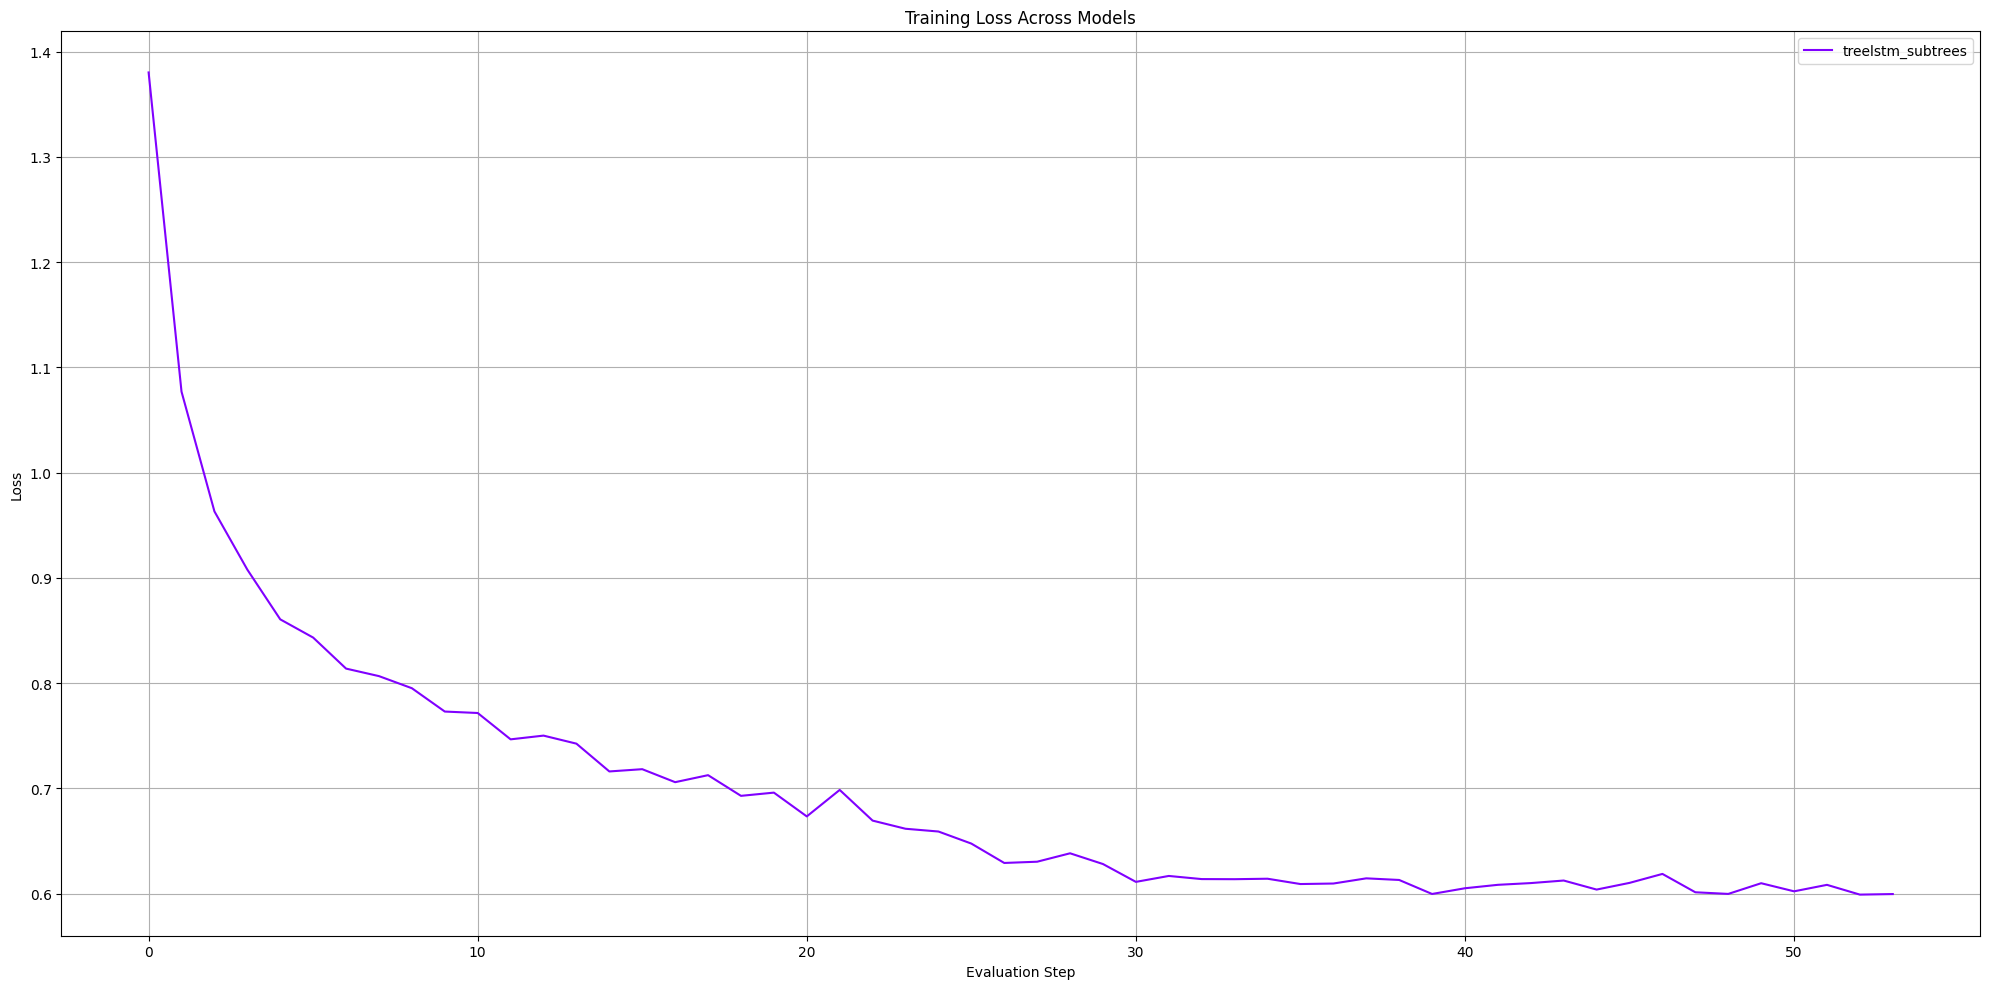

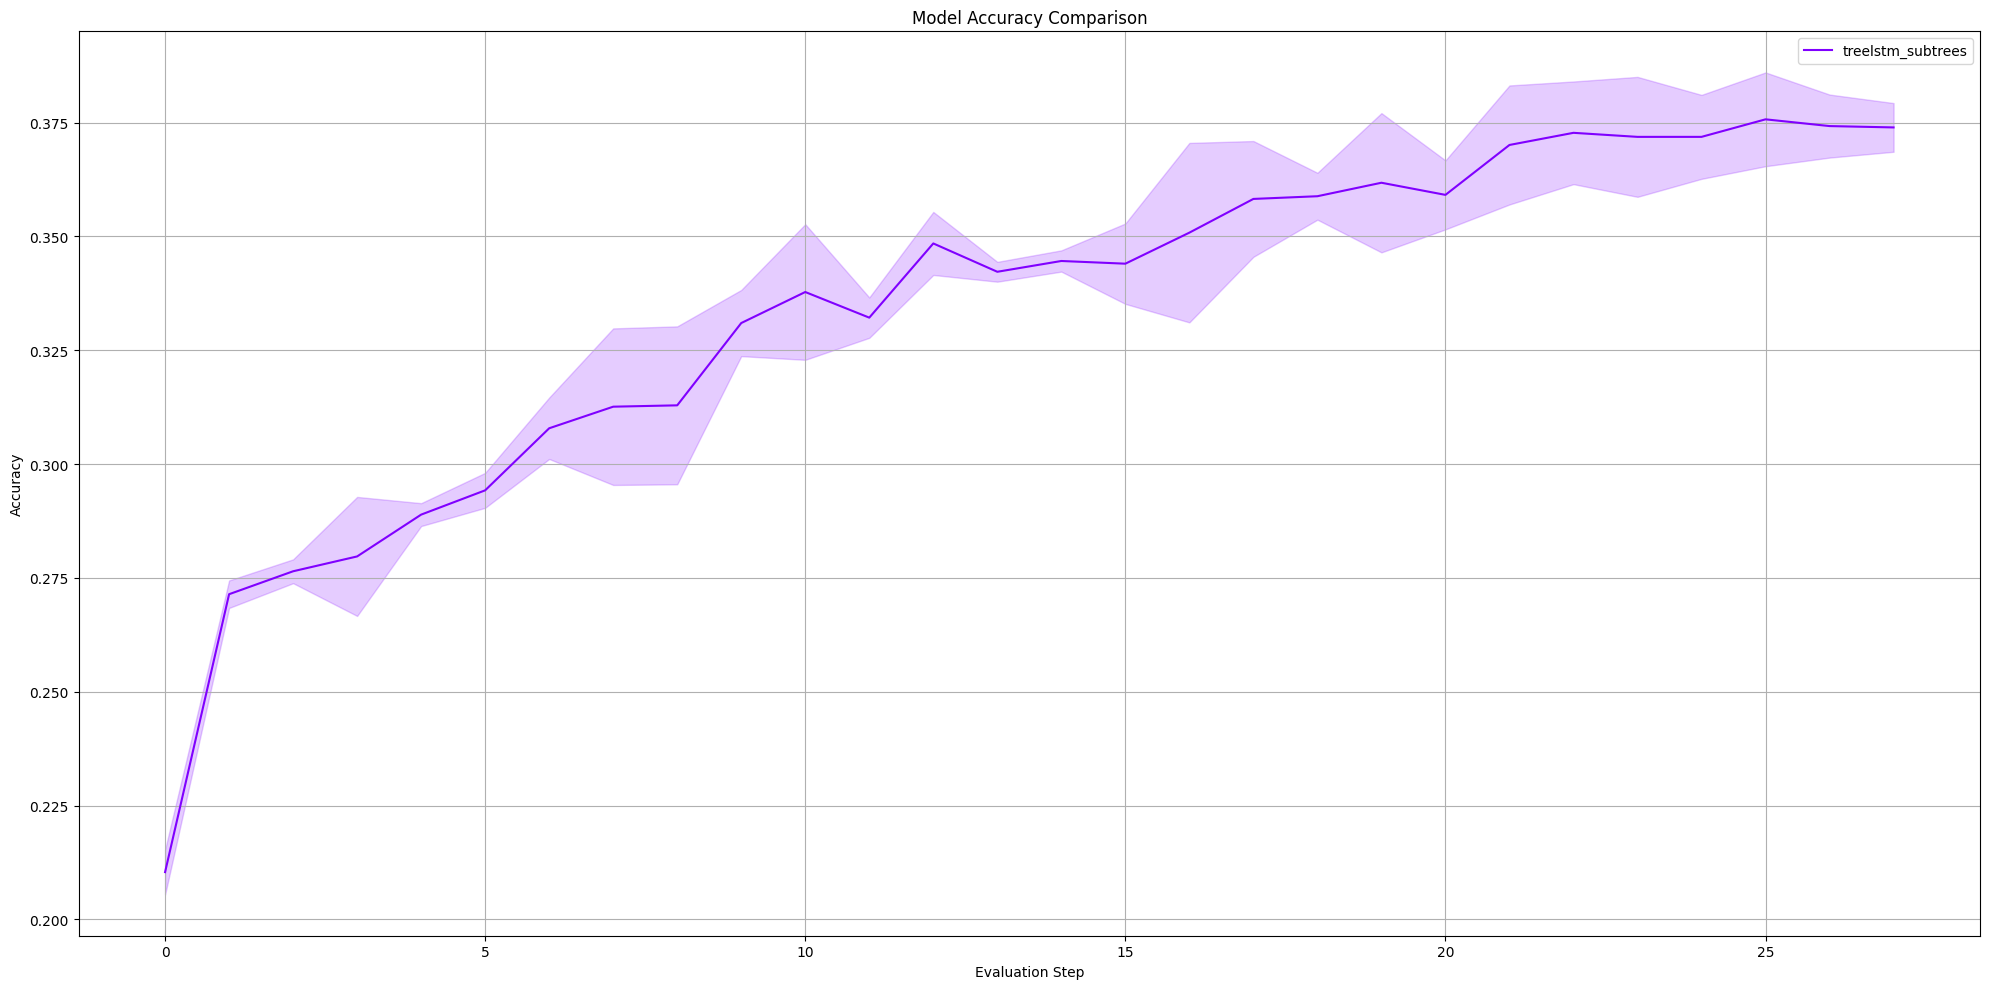

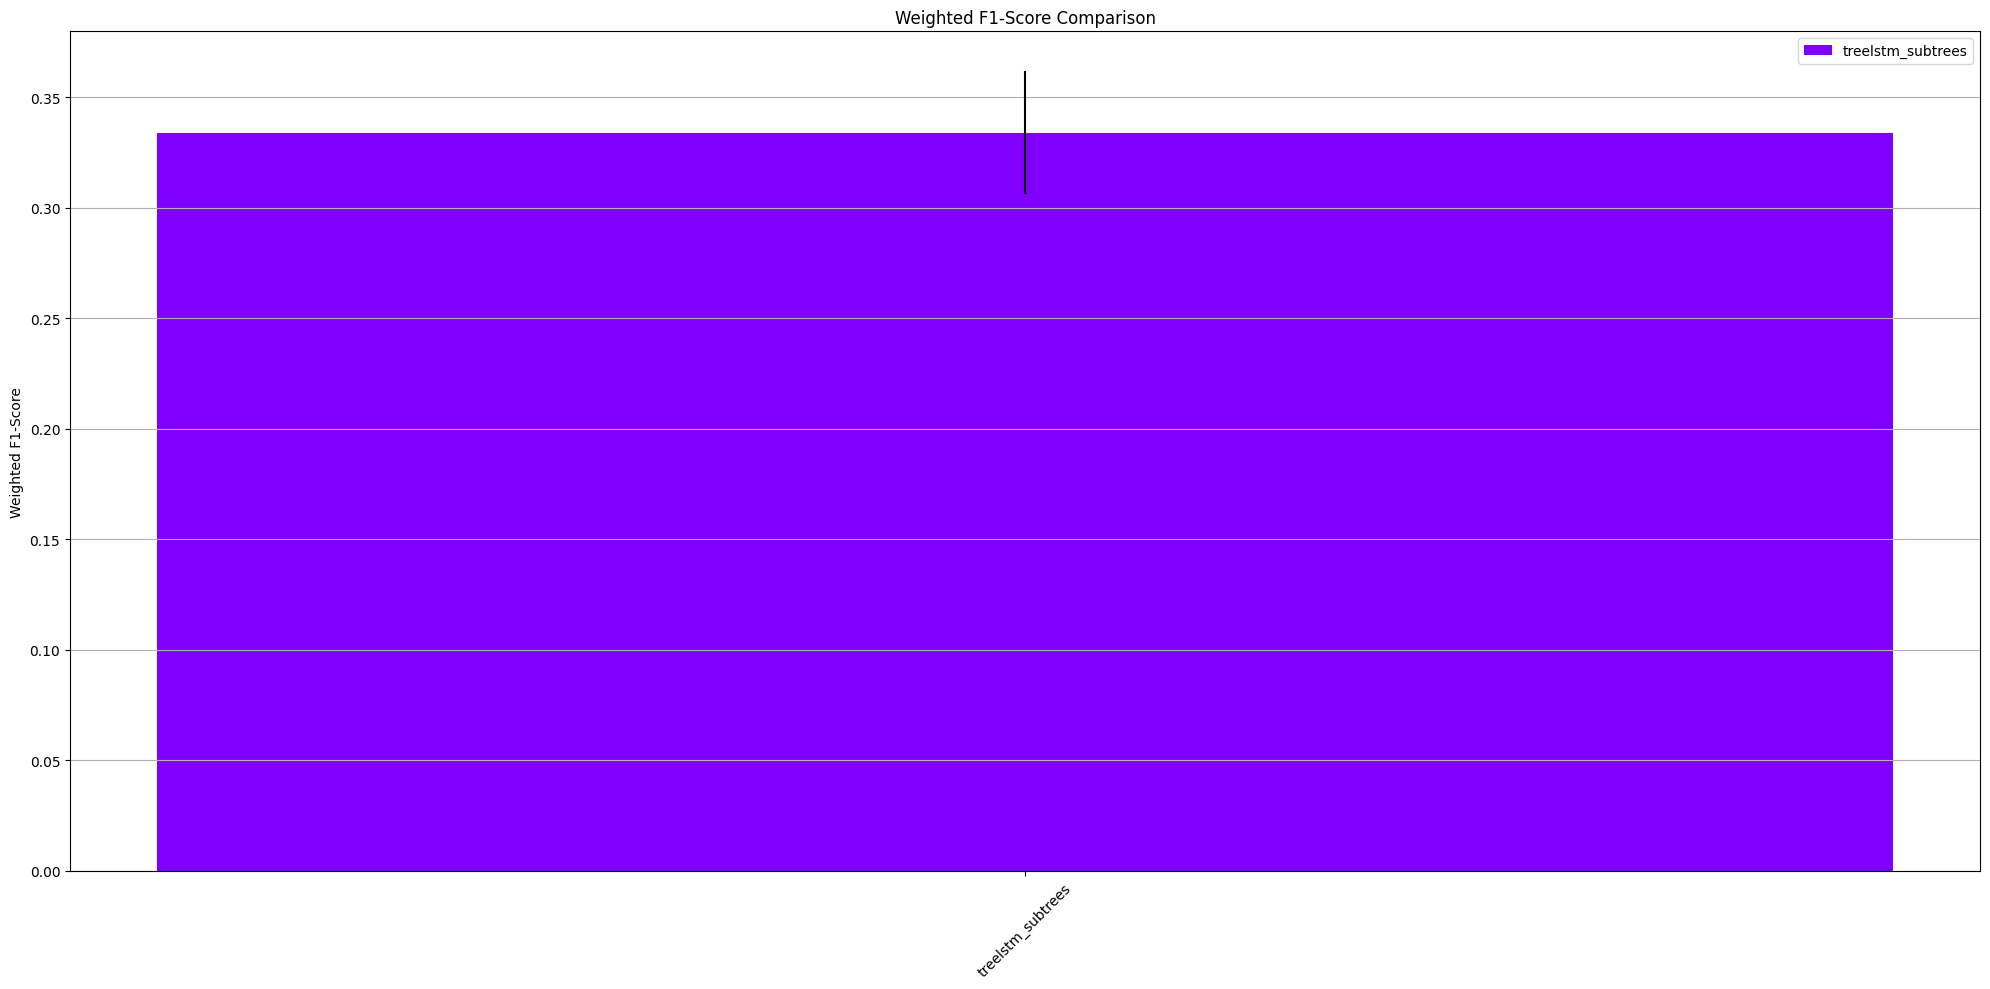

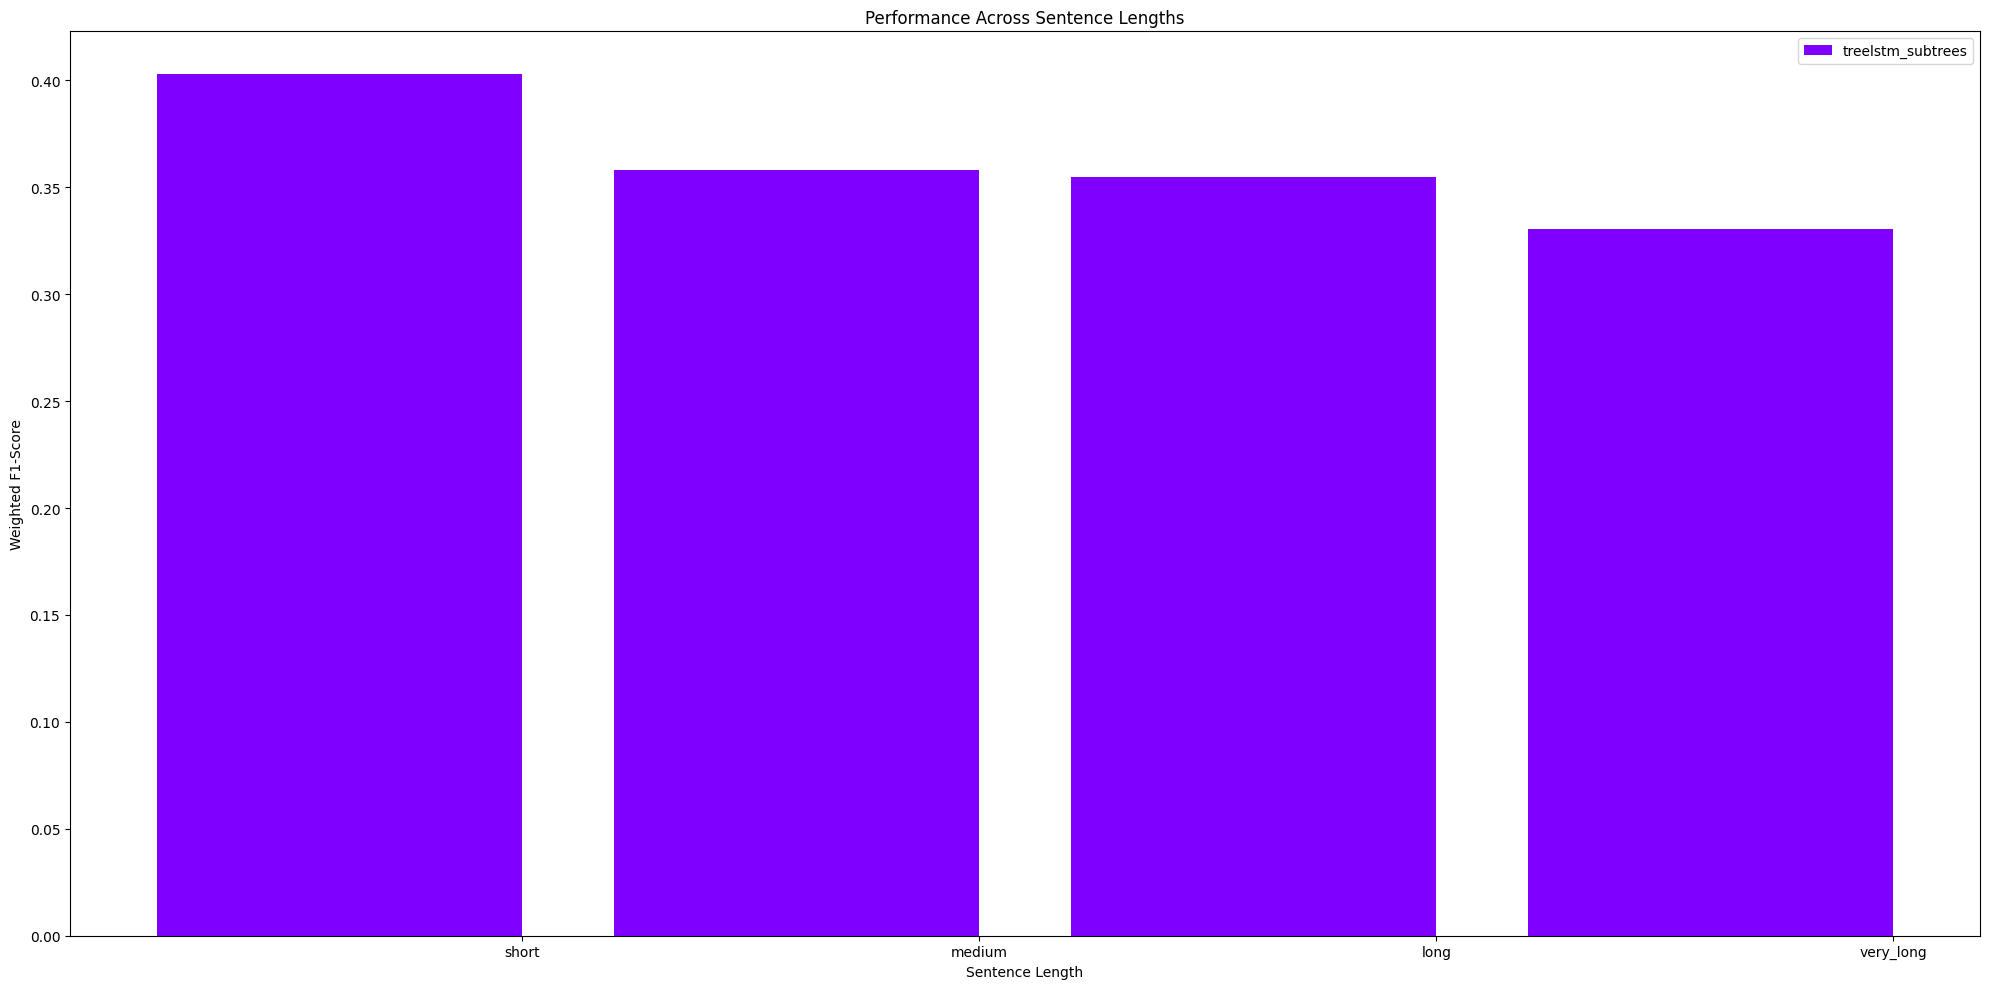

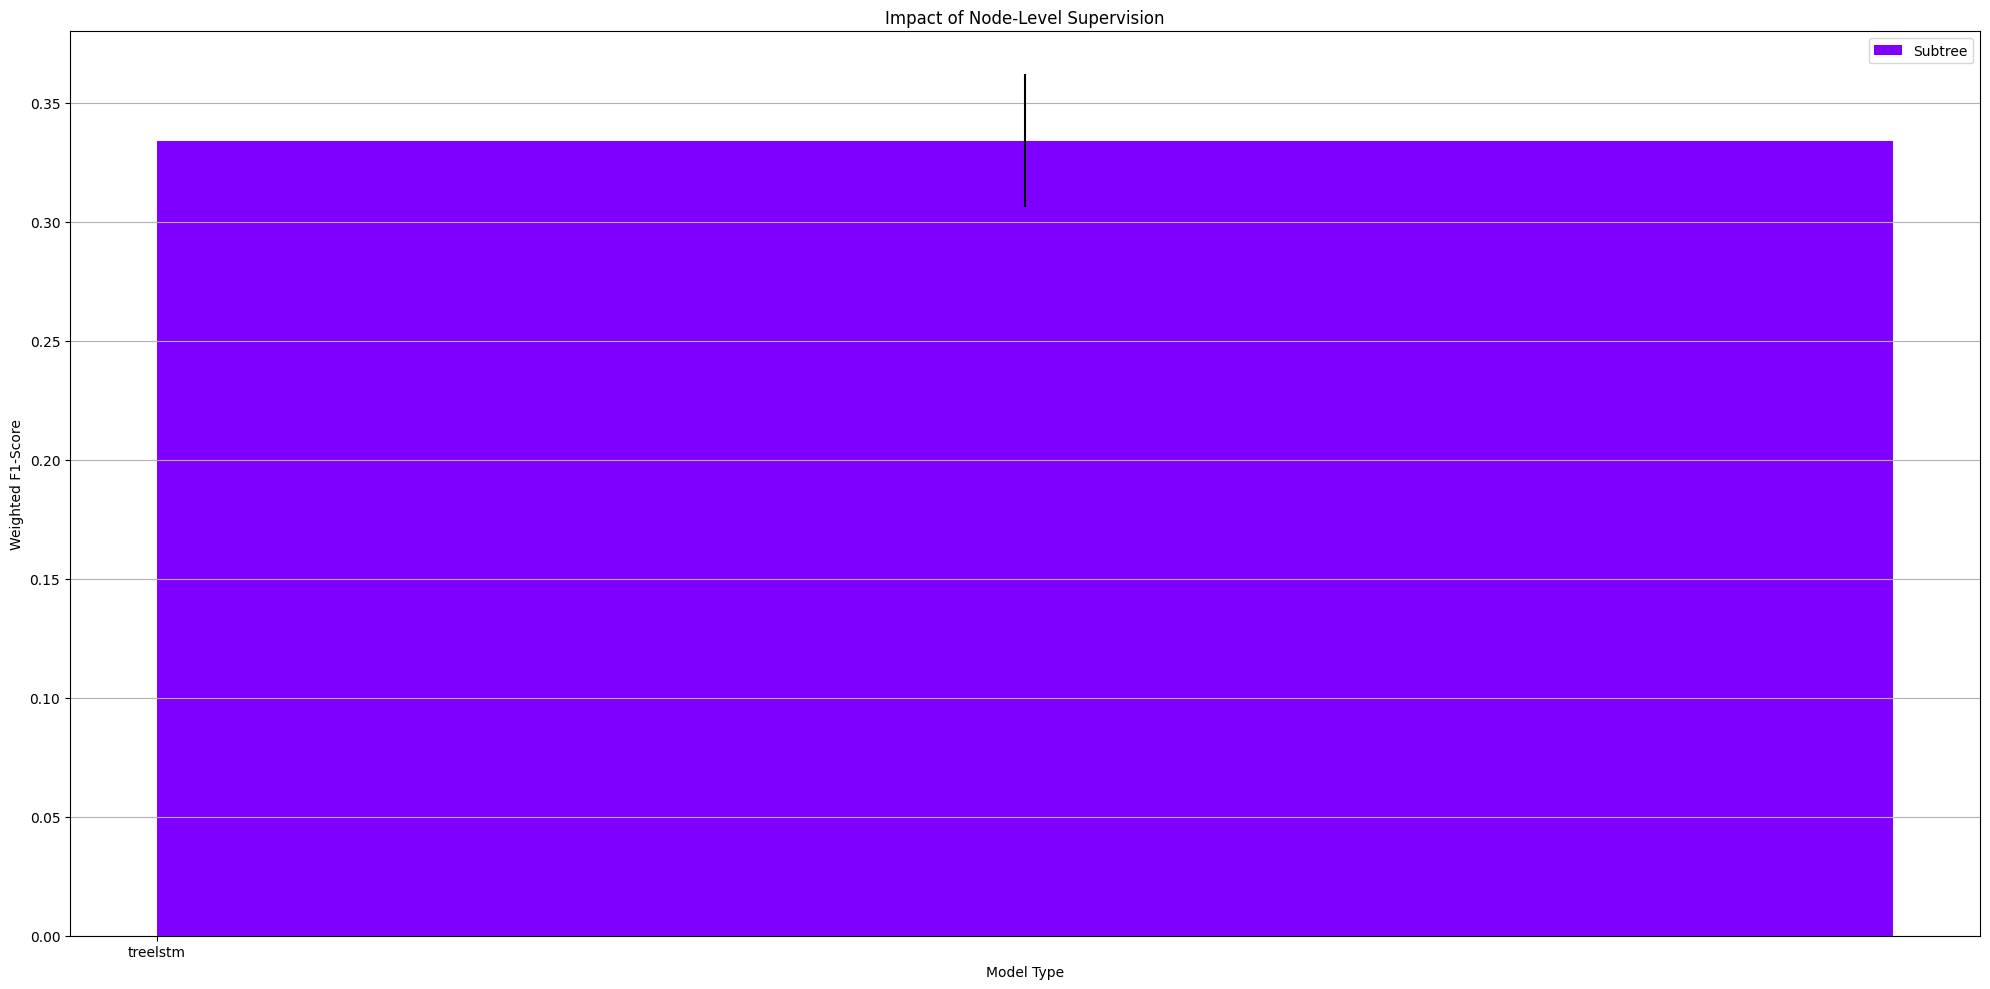

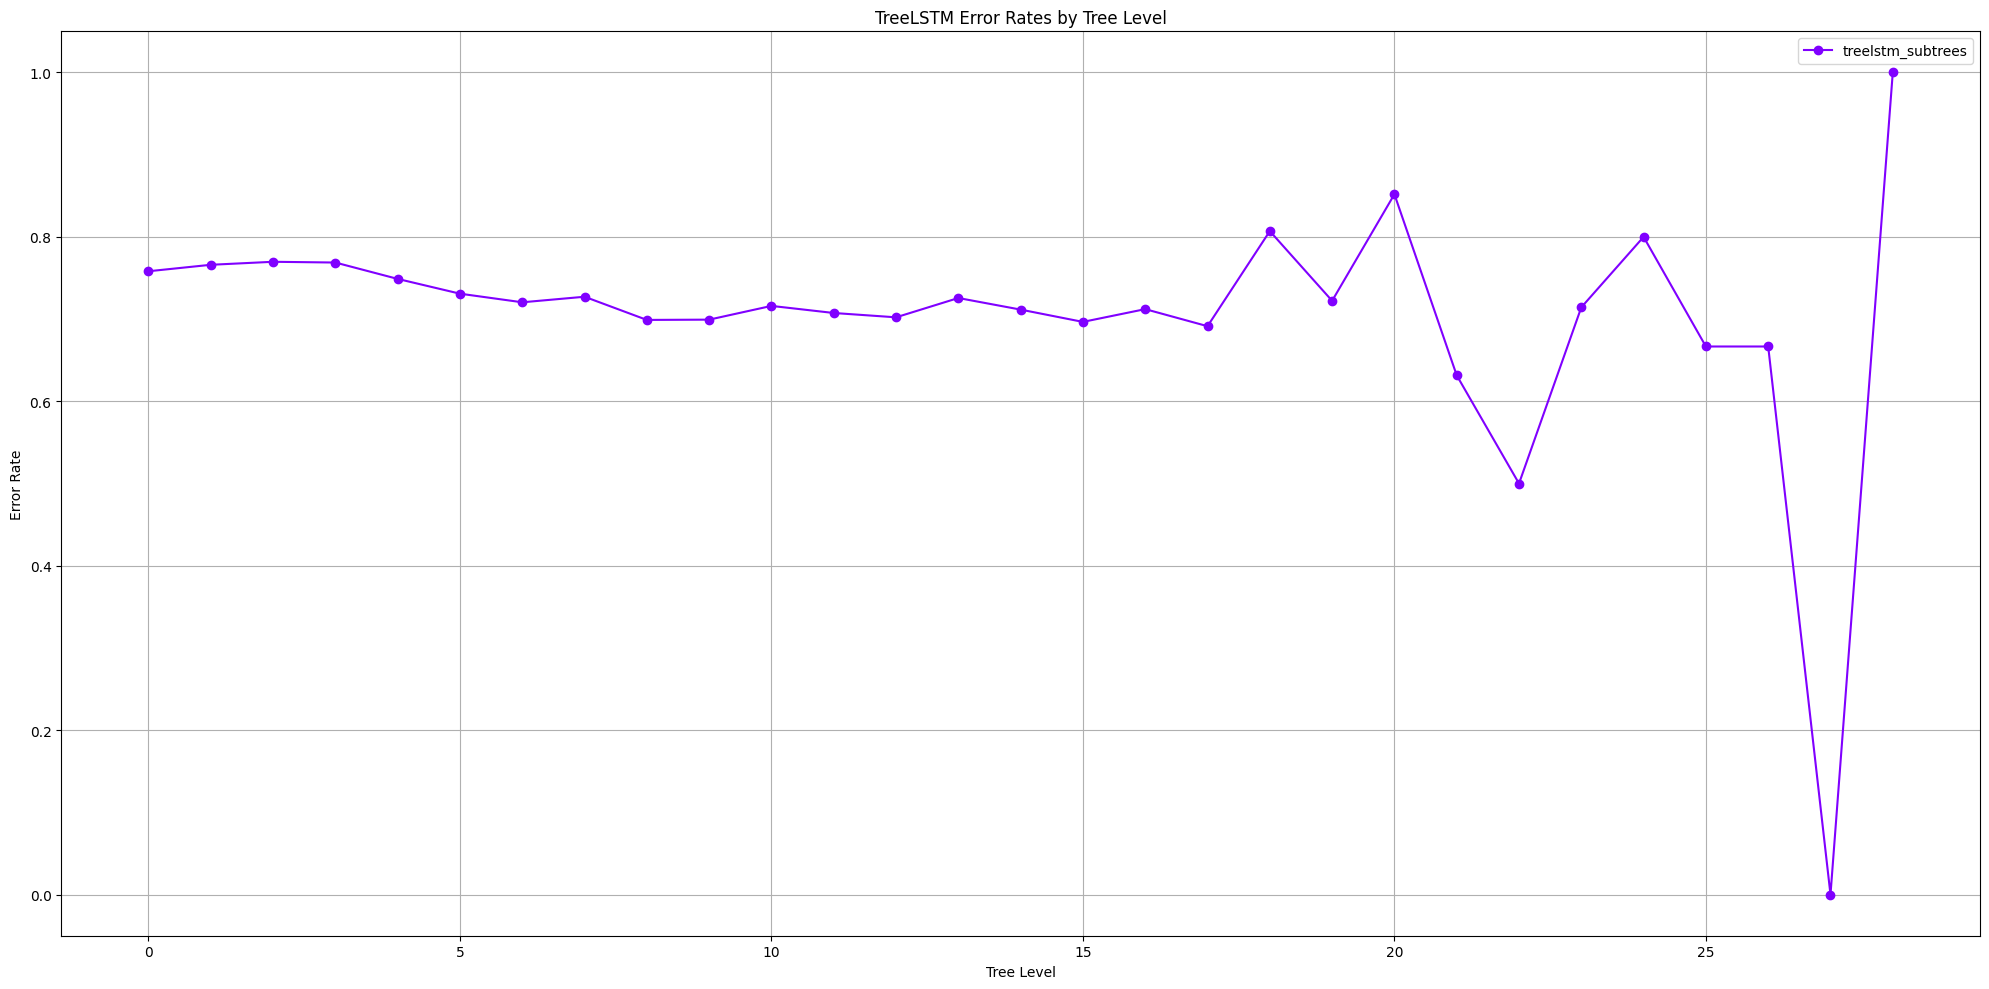

In [73]:
# Plot all results
# This shows only last model, due to failure.
plot_research_results(
    training_stats_list=list(results.values()),
    model_names=list(results.keys())
)

In [72]:
import shutil
import pickle
import json

def save_to_gdrive_mounted(results, local_dir="checkpoints",
                          gdrive_path="/gdrive/My Drive/experiment_checkpoints"):
    """Save checkpoints and results with timestamp to mounted Google Drive"""
    try:


        os.makedirs(gdrive_path, exist_ok=True)

        timestamp = time.strftime('%Y%m%d_%H%M%S')
        dst = os.path.join(gdrive_path, f"checkpoints_{timestamp}")

        shutil.copytree(local_dir, dst)

        results_path = os.path.join(dst, 'results.pkl')
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)

        json_results = {}
        for model_name, stats in results.items():
            json_results[model_name] = {
                'mean_test_acc': float(stats['mean_test_acc']),
                'std_test_acc': float(stats['std_test_acc']),
                'mean_test_f1': float(stats['mean_test_f1']),
                'std_test_f1': float(stats['std_test_f1'])
            }

        with open(os.path.join(dst, 'results_summary.json'), 'w') as f:
            json.dump(json_results, f, indent=4)

        summary = []
        for checkpoint in Path(local_dir).glob("*.pt"):
            ckpt = torch.load(checkpoint)
            summary.append({
                'filename': checkpoint.name,
                'best_eval': ckpt['best_eval'],
                'iteration': ckpt['current_iter']
            })

        with open(os.path.join(dst, 'summary.txt'), 'w') as f:
            for item in summary:
                f.write(f"{item['filename']}: best_eval={item['best_eval']:.4f}, "
                       f"iter={item['iteration']}\n")

        print(f"Saved checkpoints, results, and summary to: {dst}")

    except Exception as e:
        print(f"Error saving to Google Drive: {str(e)}")

def load_results(results_path):
    """Load saved results for plotting"""
    with open(results_path, 'rb') as f:
        return pickle.load(f)

# save_to_gdrive_mounted(results)
# gdrive_path = "/gdrive/My Drive/experiment_checkpoints/checkpoints_20241213_154755/results.pkl"
# results_other = load_results(gdrive_path)
# results_other.update(results)
# plot_research_results(list(results_other.values()), list(results_other.keys()))
# # plot_research_results(list(results.values()), list(results.keys()))
# # results = load_results('/path/to/results.pkl')
# # plot_research_results(list(results.values()), list(results.keys()))

# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring.
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

**To be able to obtain a full grade (10), you should conduct further investigations.** For example, you can also investigate one the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM?
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or... your own research question!

These examples should give you an idea of the expected scope of your further investigations. The maximum number of points awarded for these further investigations depends on the depth of your analysis, and can also be awarded for one of the further research questions already listed above.

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed.
More precisely, you should run each model with 3 different seeds, and for each of these 3 runs, evaluate the best model (according to the validation) on the test dataset. The validation dataset is used for finding the best model over iterations, but the accuracy you report should be on the test dataset.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2023 template which you can download from or edit directly on [Overleaf](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `\aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project.

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Present your research questions
    - Motivate the importance of the questions
    - Present and explain your expectations
    - Make clear whether the research questions are addressed or not addressed in the literature
    - Describe the approach you use to answer the research questions
    - Summarise your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree-LSTM) and intuitions behind them. Be accurate and concise.
    - How does each technique work? (Don't just copy the formulas)
    - What is the relation between the techniques?
3. Models (~1/2 page) - Describe the architecture of the final models.
    - How do you use LSTM or Tree-LSTM for the sentiment classification task?
    - What layers do you have, how do you do classification?
    - What is your loss function?
    - Etc.
4. Experiments (~1/2 page) - Describe your experimental setup. This section should allow someone else to reproduce your experiments. Describe how you evaluate the models.
    - Task and the data
    - Training (model, data, parameters and hyper parameters, training algorithms, supervision signals, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Present the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Use figures and tables to highlight interesting patterns
    - What are the factors that make model A better than model B in task C? Investigate to prove their effect!
6. Conclusion (~1/4 page). Present the conclusions that can be drawn from your experiments.
    - What have you learned from you experiments?
    - How do your findings relate to what is already known in the literature?
    - Were the results as expected? Any surprising results? Why?
    - Based on what you learned, what would you suggest doing next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation).
- Define technical terminology you need.
- Avoid colloquial language – everything can be said in a scientific-sounding way.
- Avoid lengthy sentences, stay to the point.
- Do not spend space on "obvious" things.
- Do not go over the page limit. (We will deduct points for that.)
- The page limit is 4 pages excluding references and appendix. This is a strict limit; points will be deducted for longer reports.
- There is no strict limit to references and appendix. However, the report needs to remain fully self-contained: the appendix should only include content that is not necessary to understand your work. For example, preprocessing decisions, model parameters, pseudocode, sample system inputs/outputs, and other details that are necessary for the exact replication of your work can be put into the appendix.


An ideal report:
- Precise, scientific, technical, to the point
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)
